# IMPORTS

In [65]:
SEED = 42
BATCH_SIZE = 64

import torch.nn.functional as nn_functional
from typing import Literal, Optional, Tuple, List, Dict, Callable
import numpy as np
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from lion_pytorch import Lion
from pytorch_ranger import Ranger

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from torchvision.transforms.functional import to_pil_image

# !pip install torchview
# !pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

import random

import timm
import os
import torch
torch.manual_seed(SEED)
from torch import nn
from torchvision import models
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
import torch.nn.functional as F
import torch.optim as optim
import gc
from tqdm import tqdm
from scipy import ndimage as ndi

from torch.utils.data import Dataset
from PIL import Image
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

from torchinfo import summary
from torchview import draw_graph

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
gc.collect()
torch.cuda.empty_cache()
       
SRC_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_preprocessed_images"    # pasta de saída
SRC_CONTEXT_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_context_images"    # pasta de saída
SRC_LABELS = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_preprocessed_labels.csv"  # arquivo CSV de saída
DST_MODEL_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models"  # pasta de saída dos modelos treinados


SRC_TILE_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_images"
SRC_TILE_LABELS = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_labels.csv"
TEST_TILE_CORRESPONDANCE = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_tile_correspondance.csv"
TEST_TILE_FOLDER = f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_test_images"

os.makedirs(DST_MODEL_FOLDER, exist_ok=True)



PyTorch version: 2.5.1+cu121
Device: cuda


# CREATING DATASET

## Labels

In [66]:
label_df = pd.read_csv(SRC_LABELS)
label_df['id'] = label_df['sample_index'].str.replace("img_","").str.replace(".png","")
label_df['label'] = label_df['label'].apply(lambda x: x.strip())

label_to_idx = {
    "Luminal A": 0,
    "Luminal B": 1,
    "HER2(+)": 2,
    "Triple negative": 3,
}

label_df["target"] = label_df["label"].map(label_to_idx)
label_df.head()

,sample_index,label,id,target
0,img_0000.png,Triple negative,0000,3
1,img_0002.png,Luminal B,0002,1
2,img_0003.png,Luminal B,0003,1
3,img_0004.png,Luminal B,0004,1
4,img_0006.png,Luminal A,0006,0


In [67]:
tile_label_df = pd.read_csv(SRC_TILE_LABELS)
tile_label_df['id'] = tile_label_df['tile_index'].str.replace("img_","").str.replace(".png","")
tile_label_df['label'] = tile_label_df['label'].apply(lambda x: x.strip())

tile_label_to_idx = {
    "Luminal A": 0,
    "Luminal B": 1,
    "HER2(+)": 2,
    "Triple negative": 3,
}
tile_label_df["target"] = tile_label_df["label"].map(tile_label_to_idx)
tile_label_df.head() # remember that because of the threshold on the tiling we might have lost some base images along the way


,sample_index,tile_index,label,id,target
0,img_0002.png,img_0000.png,Luminal B,0000,1
1,img_0003.png,img_0001.png,Luminal B,0001,1
2,img_0003.png,img_0002.png,Luminal B,0002,1
3,img_0003.png,img_0003.png,Luminal B,0003,1
4,img_0004.png,img_0004.png,Luminal B,0004,1


In [68]:
correspondance_test_df = pd.read_csv(TEST_TILE_CORRESPONDANCE)
correspondance_test_df['id'] = correspondance_test_df['tile_index'].str.replace("img_","").str.replace(".png","")
print(len(correspondance_test_df))
print(correspondance_test_df['sample_index'].nunique())
correspondance_test_df.head()

3616
477


,sample_index,tile_index,id
0,img_0000.png,img_0000.png,0000
1,img_0000.png,img_0001.png,0001
2,img_0000.png,img_0002.png,0002
3,img_0000.png,img_0003.png,0003
4,img_0001.png,img_0004.png,0004


## Class & Functions

In [69]:
class MedicalSet(Dataset):
    def __init__(self,
                 label_df: pd.DataFrame,
                 img_src_folder: str,
                 transforms = None):
        self.img_folder = img_src_folder
        self.df = label_df
        self.transforms = transforms


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        target = torch.tensor(row["target"], dtype=torch.long)
        img_id = row['id']

        # load image
        img_path = os.path.join(self.img_folder, f"img_{img_id}.png")
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

## Splitting

In [70]:
train_df, val_df = train_test_split(label_df, test_size=0.2, stratify=label_df["target"], random_state=42)

In [71]:
tile_train_df, tile_val_df = train_test_split(tile_label_df, test_size=0.2, stratify=tile_label_df["target"], random_state=42)

## Transforms

### Transforms Visualization

#### Get average fill
getting the mean average color for the whole dataset to use as fill after rotation

In [72]:

# Path to your dataset folder
dataset_path = SRC_FOLDER
# dataset_path = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/train_context_images"

# List all image files (you can filter for extensions if needed)
image_files = [os.path.join(dataset_path, f) 
               for f in os.listdir(dataset_path) 
               if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Transform to tensor (no normalization)
to_tensor = transforms.ToTensor()  # converts to [0,1] range

# Initialize sums
mean_sum = torch.zeros(3)  # RGB channels
std_sum = torch.zeros(3)  # RGB channels
pixel_count = 0

for img_file in tqdm(image_files, desc="Processing images"):
    img = Image.open(img_file).convert("RGB")
    img_tensor = to_tensor(img)  # shape [3, H, W]
    
    # Sum over H and W dimensions
    mean_sum += img_tensor.sum(dim=[1,2])
    pixel_count += img_tensor.shape[1] * img_tensor.shape[2]

# Compute mean per channel
dataset_mean = mean_sum / pixel_count
print("Dataset mean RGB (0-1 range):", dataset_mean)

for img_file in tqdm(image_files, desc="Processing images for std"):
    img = Image.open(img_file).convert("RGB")
    img_tensor = to_tensor(img)  # shape [3, H, W]
    
    # Compute squared differences from the mean
    diff = img_tensor - dataset_mean[:, None, None]
    sq_diff = diff ** 2
    
    # Sum squared differences over H and W dimensions
    std_sum += sq_diff.sum(dim=[1,2])

# compute std per channel
dataset_std = torch.sqrt(std_sum / pixel_count)
print("Dataset std RGB (0-1 range):", dataset_std)


Processing images: 100%|██████████| 1156/1156 [00:25<00:00, 45.71it/s]


Dataset mean RGB (0-1 range): tensor([0.0553, 0.0513, 0.0555])


Processing images for std: 100%|██████████| 1156/1156 [00:01<00:00, 988.43it/s] 

Dataset std RGB (0-1 range): tensor([0.2026, 0.1953, 0.2028])


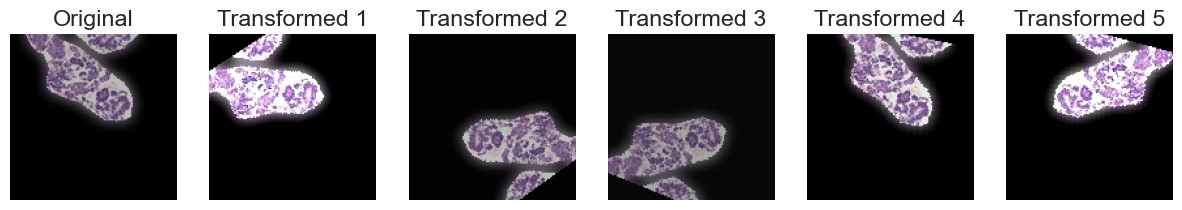

In [112]:
# Original transform
try_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=(-45,45), fill = (0,0,0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.3),
    #transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

# Load image
img = Image.open("C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_images/img_0003.png")  # replace with your image path

# Plot original and 5 transformed versions
plt.figure(figsize=(15,5))

plt.subplot(1,6,1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

for i in range(5):
    transformed_tensor = try_transforms(img)
    transformed_img = transforms.ToPILImage()(transformed_tensor)
    plt.subplot(1,6,i+2)
    plt.title(f"Transformed {i+1}")
    plt.imshow(transformed_img)
    plt.axis('off')

plt.show()


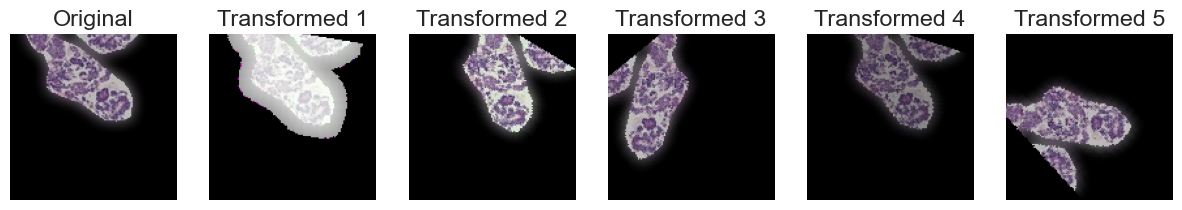

In [90]:
# Original transform
try_transforms = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=9, fill=(0,0,0)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=(-45,45), fill = (0,0,0)),
    #transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
    ])

# Load image
img = Image.open("C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_train_images/img_0003.png")  # replace with your image path

# Plot original and 5 transformed versions
plt.figure(figsize=(15,5))

plt.subplot(1,6,1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

for i in range(5):
    transformed_tensor = try_transforms(img)
    transformed_img = transforms.ToPILImage()(transformed_tensor)
    plt.subplot(1,6,i+2)
    plt.title(f"Transformed {i+1}")
    plt.imshow(transformed_img)
    plt.axis('off')

plt.show()

### Defined Transformation

In [113]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=(-45,45), fill = (0,0,0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAdjustSharpness(sharpness_factor=0.5, p=0.3),
    #transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

surrender_transforms = transforms.Compose([
    transforms.RandAugment(num_ops=2, magnitude=9, fill=(0,0,0)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    #transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

pass_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

## Dataset Objects

In [114]:
train_dataset = MedicalSet(label_df=train_df,
                img_src_folder = SRC_FOLDER,
                transforms = train_transforms)

val_dataset = MedicalSet(label_df=val_df,
                img_src_folder = SRC_FOLDER,
                transforms = pass_transforms) # Applying transforms can be a strategy but needs to be applied on submission too

tile_train_dataset = MedicalSet(label_df=tile_train_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms = train_transforms)

tile_val_dataset = MedicalSet(label_df=tile_val_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms = pass_transforms) # Applying transforms can be a strategy but needs to be applied on submission too


# CREATING DATALOADER

In [115]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

tile_train_loader = DataLoader(tile_train_dataset, batch_size=BATCH_SIZE*2, shuffle=True, num_workers=0)
tile_val_loader = DataLoader(tile_val_dataset, batch_size=BATCH_SIZE*2, shuffle=True, num_workers=0)

# CREATING MODEL

## Auxiliar functions


### Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Args:
            alpha (Tensor, optional): Class weights (for imbalance).
                                      E.g., [0.25, 0.25, 0.75, 0.75] if you want to weight HER2/TN.
            gamma (float): Focusing factor. gamma=2 is the default from the original paper.
                           Higher gamma = more focus on hard examples.
            reduction (str): 'mean' or 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 1. Compute standard CrossEntropy (log_softmax + nll_loss)
        # inputs: logits [Batch, C]
        # targets: labels [Batch]
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        
        # 2. Compute probability pt = exp(-ce_loss)
        pt = torch.exp(-ce_loss)
        
        # 3. Apply the Focal factor: (1 - pt)^gamma
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # 4. Reduction (Mean or Sum)
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# HER2 and TN are rarer, so we give higher weights.
class_weights = torch.tensor([1.0, 1.0, 1.5, 3.0]).to(device)

# Instantiating
#criterion = FocalLoss(alpha=class_weights, gamma=2.0)

# pass 'criterion' to fit function


### Parameter Functions

In [ ]:
def set_parameter_requires_grad(model, freeze_backbone=True):
    """
    Function to freeze or unfreeze the model backbone.
    """
    if freeze_backbone:
        # Freeze all backbone weights
        for param in model.backbone.parameters():
            param.requires_grad = False
        print("❄️ Backbone FROZEN. Only the 'head' will be trained.")
    else:
        # Unfreeze everything
        for param in model.backbone.parameters():
            param.requires_grad = True
        print("🔥 Backbone UNFROZEN. The whole model will be trained.")


def unfreeze_last_k_layers(model, k=20):
    """
    Unfreezes the last 'k' parameter tensors of the model.
    Useful for generic fine-tuning without knowing layer names.
    """
    # 1. Freeze everything first
    for param in model.parameters():
        param.requires_grad = False
        
    # 2. Get all parameters as a list
    # (Note: 'parameters' returns individual weight and bias tensors)
    all_params = list(model.parameters())
    
    # 3. Unfreeze the last k
    # If k is larger than total, unfreeze all
    k = min(k, len(all_params))
    
    for param in all_params[-k:]:
        param.requires_grad = True
        
    print(f"🔓 Last {k} parameter tensors unfrozen (Total: {len(all_params)})\nUnfrozen percentage: {100*k/len(all_params)}%")


### Train, Validate and fit

In [80]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, use_amp:bool=True):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)
        else:
            logits = model(inputs)
            loss = criterion(logits, targets)
            
        if scaler is None:
            loss.backward()
            optimizer.step()
        else:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_score = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='macro'
    )

    return epoch_loss, epoch_score


def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_score = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='macro'
    )

    return epoch_loss, epoch_score


def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, verbose=5, experiment_name="", save_folder=DST_MODEL_FOLDER, use_amp:bool=True):
    """Train the neural network model."""

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_score = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, use_amp=use_amp
        )

        val_loss, val_score = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_score)
        training_history['val_f1'].append(val_score)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_score:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1={val_score:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), save_folder+"/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(save_folder+"/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), save_folder+"/"+experiment_name+'_model.pt')

    return model, training_history

## Transfer Learning 

### Simple Transfer

#### finetuning fit function

In [ ]:
def train_fine_tuning_pipeline(model, train_loader, val_loader, criterion, device, 
                               epochs_warmup=10, patience_warmup=3, epochs_finetune=30, patience_finetune=10, 
                               lr_warmup=1e-3, lr_finetune=1e-6,
                               experiment_name="MyExp"):
    
    # ==========================================
    # PHASE 1: TRAIN ONLY THE CLASSIFIER (HEAD)
    # ==========================================
    print("\n🔒 PHASE 1: Warmup (Only Head)...")
    
    # 1. Freeze the backbone (helper function defined earlier)
    set_parameter_requires_grad(model, freeze_backbone=True)
    
    # 2. Create optimizer for active parameters only (Head)
    # Tip: Use Lion or AdamW
    # optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_warmup)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr_warmup, weight_decay=1e-3)
    scaler = torch.amp.GradScaler('cuda') # If using GPU

    # 3. Train (Warmup)
    model, history_warmup = fit(
        model, train_loader, val_loader, 
        epochs=epochs_warmup, 
        criterion=criterion, 
        optimizer=optimizer, 
        scaler=scaler, 
        device=device,
        patience=patience_warmup,  # Short patience during warmup
        experiment_name=f"{experiment_name}_warmup"
    )

    # ==========================================
    # PHASE 2: FINE-TUNING (FULL MODEL)
    # ==========================================
    print("\n🔓 PHASE 2: Fine-Tuning (Full Model)...")
    
    # 1. Load best weights from Phase 1 (to start from the best point)
    model.load_state_dict(torch.load(f"models/{experiment_name}_warmup_model.pt", weights_only=True))
    
    # 2. Unfreeze everything
    set_parameter_requires_grad(model, freeze_backbone=False)
    
    # 3. RE-CREATE optimizer with lower LR (CRITICAL!)
    # Now we pass full 'model.parameters()' as everything is unfrozen
    optimizer = torch.optim.AdamW([{'params': model.backbone.parameters(), 'lr':lr_finetune},
            {'params': model.head.parameters(), 'lr': lr_warmup/100}], weight_decay=1e-2)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs_finetune)
   
    # 4. Train (Fine-Tuning)
    model, history_finetune = fit(
        model, train_loader, val_loader, 
        epochs=epochs_finetune, 
        criterion=criterion, 
        optimizer=optimizer, 
        scaler=scaler, 
        device=device,
        patience=patience_finetune,  # Longer patience here
        experiment_name=f"{experiment_name}_finetune"
    )
    
    return model, history_warmup, history_finetune


#### Model

In [ ]:
class SimpleTransfer_v1(nn.Module):
    def __init__(self, model_name='convnext_tiny', num_classes=4, pretrained=True, norm_method:Literal['batchnorm', 'layernorm']='batchnorm'):
        """
        Args:
            model_name: Model name in timm (e.g., 'convnext_tiny')
            num_classes: Number of subtypes (4 in our case)
            pretrained: If True, use ImageNet weights (Transfer Learning)
            norm_method: Normalization method ('batchnorm', 'layernorm', etc.), batchnorm for Batch Size >= 32
        """
        super().__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0,       # Remove original classification head
            global_pool='avg'    # Average pooling for output features
        )
        num_features = self.backbone.num_features
        self.head = nn.Sequential(
            nn.BatchNorm1d(num_features) if norm_method=='batchnorm' else nn.LayerNorm(num_features, eps=1e-6), # Stabilize training with small batch
            nn.Flatten(),
            nn.Dropout(0.2),                      # Avoid memorizing dataset (Overfitting)
            nn.Linear(num_features, num_classes)  # Final decision (4 classes)
        )
        
    def forward(self, x):
        # Pass the image through the backbone (extract features)
        features = self.backbone(x)
        
        # Pass features through the head (classify)
        logits = self.head(features)
        
        return logits


#### Training

In [ ]:
# ==========================================
# MODEL INITIALIZATION
# ==========================================
model = SimpleTransfer_v1(
    model_name='densenet121', 
    num_classes=4, 
    pretrained=True
).to(device)

# Loss Function (CrossEntropy)
# Label smoothing helps with noisy medical labels
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)


In [225]:
# ==========================================
# EXECUTE TRAINING (The Pipeline)
# ==========================================
# Note: You need the helper functions defined in previous steps 
# (train_fine_tuning_pipeline, set_parameter_requires_grad, fit)

print("\n🚀 Starting Training Pipeline...")

final_model, history_warmup, history_finetune = train_fine_tuning_pipeline(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    epochs_warmup=25,
    patience_warmup=7,    # Quick warmup for the head
    epochs_finetune=40,    # Longer time for full body adjustment
    patience_finetune=10,  
    lr_warmup=1e-3,        # High LR for head
    lr_finetune=1e-9,      # Low LR for delicate fine-tuning
    experiment_name="SimpleTransfer_Run_01",
)


🚀 Starting Training Pipeline...

🔒 FASE 1: Warmup (Apenas Head)...
❄️ Backbone CONGELADO. Apenas a 'head' será treinada.
Training 25 epochs...
Epoch   1/25 | Train: Loss=1.3247, F1=0.3455 | Val: Loss=1.4551, F1=0.2463
Epoch   5/25 | Train: Loss=1.2810, F1=0.4009 | Val: Loss=1.4892, F1=0.2089
Early stopping triggered after 8 epochs.
Best model restored from epoch 1 with val_f1 0.2463

🔓 FASE 2: Fine-Tuning (Modelo Completo)...
🔥 Backbone DESCONGELADO. O modelo todo será treinado.
Training 40 epochs...
Epoch   1/40 | Train: Loss=1.3187, F1=0.3316 | Val: Loss=1.4448, F1=0.2194
Epoch   5/40 | Train: Loss=1.2624, F1=0.3643 | Val: Loss=1.4671, F1=0.2151
Epoch  10/40 | Train: Loss=1.3272, F1=0.3080 | Val: Loss=1.4669, F1=0.2062
Epoch  15/40 | Train: Loss=1.3371, F1=0.3188 | Val: Loss=1.4620, F1=0.1816
Early stopping triggered after 19 epochs.
Best model restored from epoch 9 with val_f1 0.2604


In [ ]:
# ==========================================
# VISUALIZE RESULTS
# ==========================================
def plot_full_history(h1, h2):
    # Combine histories
    F1 = h1['train_f1'] + h2['train_f1']
    val_f1 = h1['val_f1'] + h2['val_f1']
    loss = h1['train_loss'] + h2['train_loss']
    val_loss = h1['val_loss'] + h2['val_loss']
    
    epochs = range(1, len(F1) + 1)
    
    plt.figure(figsize=(18, 5))
    
    # F1
    plt.subplot(1, 2, 1)
    plt.plot(epochs, F1, label='Train f1')
    plt.plot(epochs, val_f1, label='Val f1')
    plt.axvline(x=len(h1['train_f1']), color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title('Training F1')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.axvline(x=len(h1['train_loss']), color='r', linestyle='--', label='Start Fine-Tuning')
    plt.title('Training Loss')
    plt.legend()
    
    plt.show()

plot_full_history(history_warmup, history_finetune)

### Partial Transfer

#### finetuning fit function

In [ ]:
def partial_unfreeze_tune_fit(model, train_loader, val_loader, criterion, device, 
                               epochs:int=100, patience:int=20, 
                               lr_head=1e-3, lr_finetune=1e-6,
                               unfreeze_k:int=20,
                               experiment_name="MyExp",
                               use_amp:bool=True,
                               save_folder=DST_MODEL_FOLDER,
                               verbose:int=5,
                               optimizer:Literal["AdamW", 'Ranger', "Lion"]="AdamW"):

    unfreeze_last_k_layers(model=model, k=unfreeze_k)
    
    if optimizer=="AdamW":
        optimizer = torch.optim.AdamW([{'params': filter(lambda p: p.requires_grad, model.backbone.parameters()), 'lr':lr_finetune},
                                       {'params': model.head.parameters(), 'lr': lr_head}], weight_decay=1e-2)
    elif optimizer=="Ranger":
        optimizer = Ranger([{'params': filter(lambda p: p.requires_grad, model.backbone.parameters()), 'lr':lr_finetune},
                            {'params': model.head.parameters(), 'lr': lr_head}], weight_decay=1e-2)
    elif optimizer=="Lion":
        optimizer = Lion([{'params': filter(lambda p: p.requires_grad, model.backbone.parameters()), 'lr':lr_finetune},
                          {'params': model.head.parameters(), 'lr': lr_head}], weight_decay=1e-2)
        
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.amp.GradScaler('cuda') if use_amp else None  

    model, history = fit(
        model, train_loader, val_loader, 
        epochs=epochs, 
        criterion=criterion, 
        optimizer=optimizer, 
        scaler=scaler, 
        device=device,
        patience=patience,
        experiment_name=f"{experiment_name}",
        use_amp=use_amp,
        save_folder=save_folder,
        verbose=verbose
    )

    return model, history

#### Training

In [ ]:
# ==========================================
# MODEL INITIALIZATION
# ==========================================
model = SimpleTransfer_v1(
    model_name='densenet121', 
    num_classes=4, 
    pretrained=True,
    norm_method='batchnorm'
).to(device)

# Loss Function (CrossEntropy)
# Label smoothing helps with noisy medical labels 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [500]:
final_model, history = partial_unfreeze_tune_fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=20,
    lr_head=1e-3,
    lr_finetune=1e-6,
    unfreeze_k=40,
    experiment_name="PartialUnfreeze_Run_02",
    optimizer="Ranger"
)

🔓 Últimos 40 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.92896174863388%
Training 100 epochs...
Epoch   1/100 | Train: Loss=1.5434, F1=0.2326 | Val: Loss=1.7632, F1=0.0551
Epoch   5/100 | Train: Loss=1.5252, F1=0.2245 | Val: Loss=1.7318, F1=0.1875
Epoch  10/100 | Train: Loss=1.4358, F1=0.2690 | Val: Loss=3.7359, F1=0.1314
Epoch  15/100 | Train: Loss=1.4761, F1=0.2483 | Val: Loss=4.5279, F1=0.1306
Epoch  20/100 | Train: Loss=1.4151, F1=0.3055 | Val: Loss=3.1532, F1=0.1314
Early stopping triggered after 24 epochs.
Best model restored from epoch 4 with val_f1 0.2250


#### optimizer study

In [ ]:
import optuna
import torch
import torch.nn as nn
import gc # Garbage Collector to clear VRAM between trials

OPTIM_SAVE_FOLDER = DST_MODEL_FOLDER + "/optim_models"
os.makedirs(OPTIM_SAVE_FOLDER, exist_ok=True)

# ==========================================
# 1. OBJECTIVE FUNCTION (The Brain of Optuna)
# ==========================================
def objective(trial, train_loader, val_loader, experiment_name):
    
    # --- A. Search Space (Hyperparameters) ---
    
    # 1. Model Architecture
    # Added efficientnet and resnet as alternatives to convnext/densenet
    model_name = trial.suggest_categorical('model_name', [
        'convnext_tiny', 
        'convnext_small', 
        'densenet121',  
    ])
    
    # 2. Fine-Tuning Strategy
    # K=0 means train only the head. K=60 unfreezes a good portion of the backbone.
    unfreeze_k = trial.suggest_int('unfreeze_k', 30, 80)

    # 3. Learning Rates (Log scale is crucial)
    lr_head = trial.suggest_float('lr_head', 8e-6, 1e-3, log=True)
    lr_finetune = trial.suggest_float('lr_finetune', 8e-7, 1e-4, log=True)
    
    # 4. Others (Optional: Weight Decay, Label Smoothing)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
    norm_method = trial.suggest_categorical('norm_method', ['batchnorm', 'layernorm'])
    optim_choice = trial.suggest_categorical('optimizer', ['Ranger', 'Lion'])

    w0 = trial.suggest_float('w0', 1.0, 1.5)
    w1 = trial.suggest_float('w1', 1.0, 1.5)
    w2 = trial.suggest_float('w2', 1.3, 1.7)
    w3 = trial.suggest_float('w3', 1.5, 2.5)

    class_weights = torch.tensor([w0, w1, w2, w3]).to(device)
    
    criterion_choice = trial.suggest_categorical('criterion', ["FocalLoss", "CrossEntropyLoss"])

    if criterion_choice == "FocalLoss":
        criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    elif criterion_choice == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing) 

    loader_kind = trial.suggest_categorical('loader', ["tiles", "full image"])

    if loader_kind == "tiles":
        t_loader = tile_train_loader
        v_loader = tile_val_loader
    else:
        t_loader = train_loader
        v_loader = val_loader

    print(f"\n--- Trial {trial.number}: {model_name} | K={unfreeze_k} | LRs: {lr_head:.1e}/{lr_finetune:.1e} ---")
    print(f"### Loader type: {loader_kind}\n### Optimizer: {optim_choice}\n### Normalization: {norm_method}\n### Label Smoothing: {label_smoothing}")
    print(f"### Criterion: {criterion_choice}", end=' ')
    if criterion_choice == "FocalLoss":
        print(f"Weights for Criterion Loss: LumA:{w0}, LumB:{w1}, HER2+:{w2}, TN:{w3}", end=' ')
    print("")

    # --- B. Initialization ---
    
    # Instantiate model using existing wrapper class
    model = SimpleTransfer_v1(
        model_name=model_name, 
        num_classes=4, 
        pretrained=True,
        norm_method=norm_method 
    ).to(device)
    
    # --- C. Training ---
    
    # Using try/except to catch OOM errors without crashing the study
    try:
        # Reuse existing training function
        # Reduce epochs and patience to make Optuna run faster (e.g., 15-20 epochs)
        # Goal is to find potential, not perfect final model
        final_model, history = partial_unfreeze_tune_fit(
            model=model,
            train_loader=t_loader,
            val_loader=v_loader,
            criterion=criterion,
            device=device,
            epochs=200,       
            patience=30,      
            lr_head=lr_head,
            lr_finetune=lr_finetune,
            unfreeze_k=unfreeze_k,
            experiment_name=f"optuna_{experiment_name}_{trial.number}",
            save_folder=OPTIM_SAVE_FOLDER,
            verbose=30,
            optimizer=optim_choice
        )
        
        # Metric to optimize is the Best Validation F1 Score
        best_f1 = max(history['val_f1'])
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("💀 OOM: Out of Memory. Pruning trial.")
            # Clear memory and return a bad value
            torch.cuda.empty_cache()
            return 0.0 
        else:
            raise e
        
    except Exception as e:
        print(f"❗ Unexpected error: {e}. Pruning trial.")
        print(f"Failed parameters: model_name={model_name}, unfreeze_k={unfreeze_k}, lr_head={lr_head}, lr_finetune={lr_finetune}, label_smoothing={label_smoothing}")
        return 0.0

    # --- D. Cleanup ---
    # Crucial: Delete model and clear VRAM for next trial
    del model
    del final_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_f1

# ==========================================
# 2. STUDY EXECUTOR
# ==========================================
def run_study(study_name, train_loader, val_loader, n_trials=15):
    print(f"\n==================================================")
    print(f"🔎 STARTING OPTIMIZATION FOR: {study_name}")
    print(f"==================================================")
    
    # Create study (maximize F1)
    study = optuna.create_study(direction='maximize', study_name=study_name)
    
    # Lambda function to pass extra arguments
    func = lambda trial: objective(trial, train_loader, val_loader, study_name)
    
    # Run optimization
    study.optimize(func, n_trials=n_trials)
    
    print(f"\n🏆 Best parameters for {study_name}:")
    print(study.best_params)
    print(f"Best F1: {study.best_value:.4f}")
    
    return study.best_params

# ==========================================
# 3. RUN FOR THE 3 MODELS
# ==========================================

# A. Gatekeeper (Luminal vs Rest)
best_params_base_model = run_study(
    "Blur_NoNorm_AllTuned_BaseModel_Study", 
    tile_train_loader, 
    tile_val_loader, 
    n_trials=30 
    )

print("Best Parameters:", best_params_base_model)

# Note: Later test with/without blur, with normalization, and with different optimizers.


[I 2025-12-12 04:56:50,250] A new study created in memory with name: Blur_NoNorm_AllTuned_BaseModel_Study



🔎 INICIANDO OTIMIZAÇÃO PARA: Blur_NoNorm_AllTuned_BaseModel_Study

--- Trial 0: convnext_tiny | K=32 | LRs: 1.1e-05/2.3e-05 ---
### Loader type: full image
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.18652432790928858
### Criterion: CrossEntropyLoss 
🔓 Últimos 32 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.391304347826086%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4591, F1=0.2400 | Val: Loss=1.4362, F1=0.2259
Epoch  30/200 | Train: Loss=1.2986, F1=0.3302 | Val: Loss=1.3355, F1=0.2539
Epoch  60/200 | Train: Loss=1.2078, F1=0.4377 | Val: Loss=1.3097, F1=0.3153
Epoch  90/200 | Train: Loss=1.0894, F1=0.5944 | Val: Loss=1.3056, F1=0.3890
Epoch 120/200 | Train: Loss=0.9815, F1=0.7082 | Val: Loss=1.3168, F1=0.4273
Epoch 150/200 | Train: Loss=0.8995, F1=0.7692 | Val: Loss=1.3432, F1=0.4353
Epoch 180/200 | Train: Loss=0.8520, F1=0.8170 | Val: Loss=1.3343, F1=0.4559
Best model restored from epoch 176 with val_f1 0.4597


[I 2025-12-12 05:20:27,397] Trial 0 finished with value: 0.4596720773396441 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 32, 'lr_head': 1.0868189771551775e-05, 'lr_finetune': 2.3210519555204377e-05, 'label_smoothing': 0.18652432790928858, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.151857412674297, 'w1': 1.0293302278214178, 'w2': 1.4438506395060027, 'w3': 2.3424743539069612, 'criterion': 'CrossEntropyLoss', 'loader': 'full image'}. Best is trial 0 with value: 0.4596720773396441.



--- Trial 1: densenet121 | K=73 | LRs: 5.6e-04/9.5e-06 ---
### Loader type: tiles
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.1721849929032081
### Criterion: CrossEntropyLoss 
🔓 Últimos 73 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 19.94535519125683%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5379, F1=0.2439 | Val: Loss=1.5870, F1=0.1919
Epoch  30/200 | Train: Loss=1.3625, F1=0.3340 | Val: Loss=1.3595, F1=0.3137
Epoch  60/200 | Train: Loss=1.2880, F1=0.3491 | Val: Loss=1.3079, F1=0.3208
Epoch  90/200 | Train: Loss=1.2487, F1=0.3924 | Val: Loss=1.2907, F1=0.3651
Epoch 120/200 | Train: Loss=1.2493, F1=0.3970 | Val: Loss=1.2860, F1=0.3831
Early stopping triggered after 148 epochs.
Best model restored from epoch 118 with val_f1 0.3962


[I 2025-12-12 05:38:16,219] Trial 1 finished with value: 0.396207264957265 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 73, 'lr_head': 0.0005553652853158466, 'lr_finetune': 9.50127126015313e-06, 'label_smoothing': 0.1721849929032081, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.1191676061503368, 'w1': 1.290736037031989, 'w2': 1.5137179390201083, 'w3': 1.5336706814138137, 'criterion': 'CrossEntropyLoss', 'loader': 'tiles'}. Best is trial 0 with value: 0.4596720773396441.



--- Trial 2: convnext_tiny | K=51 | LRs: 1.9e-04/1.7e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.19602077319436045
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.2033851191639533, LumB:1.0778796819183705, HER2+1.5198448572197527, TN1.8492522130959608 
🔓 Últimos 51 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 27.717391304347824%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4425, F1=0.2619 | Val: Loss=1.3201, F1=0.2909
Epoch  30/200 | Train: Loss=0.2059, F1=0.8760 | Val: Loss=1.7037, F1=0.4515
Early stopping triggered after 51 epochs.
Best model restored from epoch 21 with val_f1 0.5193


[I 2025-12-12 05:44:43,431] Trial 2 finished with value: 0.5193063981727978 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 51, 'lr_head': 0.0001939065359224653, 'lr_finetune': 1.6751636825706947e-05, 'label_smoothing': 0.19602077319436045, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2033851191639533, 'w1': 1.0778796819183705, 'w2': 1.5198448572197527, 'w3': 1.8492522130959608, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 3: convnext_small | K=66 | LRs: 4.9e-04/1.1e-06 ---
### Loader type: tiles
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.14940297832378233
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.208850657986691, LumB:1.3041004280200068, HER2+1.323155537419456, TN1.642068003802136 
🔓 Últimos 66 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 19.07514450867052%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3585, F1=0.2549 | Val: Loss=1.2383, F1=0.2396
Epoch  30/200 | Train: Loss=0.9294, F1=0.4950 | Val: Loss=1.1798, F1=0.3804
Epoch  60/200 | Train: Loss=0.6944, F1=0.6209 | Val: Loss=1.2566, F1=0.4208
Epoch  90/200 | Train: Loss=0.5163, F1=0.7147 | Val: Loss=1.3892, F1=0.4099
Early stopping triggered after 93 epochs.
Best model restored from epoch 63 with val_f1 0.4440


[I 2025-12-12 05:57:48,609] Trial 3 finished with value: 0.44399987019730014 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 66, 'lr_head': 0.00048577220072048844, 'lr_finetune': 1.1049500825189195e-06, 'label_smoothing': 0.14940297832378233, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.208850657986691, 'w1': 1.3041004280200068, 'w2': 1.323155537419456, 'w3': 1.642068003802136, 'criterion': 'FocalLoss', 'loader': 'tiles'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 4: convnext_small | K=35 | LRs: 1.8e-05/1.2e-05 ---
### Loader type: full image
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.07551087105229481
### Criterion: CrossEntropyLoss 
🔓 Últimos 35 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 10.115606936416185%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5169, F1=0.2236 | Val: Loss=1.5189, F1=0.2450
Epoch  30/200 | Train: Loss=1.2979, F1=0.3014 | Val: Loss=1.2967, F1=0.2828
Epoch  60/200 | Train: Loss=1.2183, F1=0.3834 | Val: Loss=1.2671, F1=0.2924
Epoch  90/200 | Train: Loss=1.0948, F1=0.5062 | Val: Loss=1.2589, F1=0.3368
Epoch 120/200 | Train: Loss=0.9658, F1=0.5950 | Val: Loss=1.2584, F1=0.3579
Epoch 150/200 | Train: Loss=0.8407, F1=0.7038 | Val: Loss=1.2791, F1=0.3827
Early stopping triggered after 164 epochs.
Best model restored from epoch 134 with val_f1 0.4201


[I 2025-12-12 06:20:22,918] Trial 4 finished with value: 0.42014689936056715 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 35, 'lr_head': 1.8070303800289218e-05, 'lr_finetune': 1.203868670161408e-05, 'label_smoothing': 0.07551087105229481, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.0231850762788948, 'w1': 1.1084112366642924, 'w2': 1.535248334366148, 'w3': 1.7467127633342305, 'criterion': 'CrossEntropyLoss', 'loader': 'full image'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 5: convnext_small | K=78 | LRs: 1.2e-05/2.4e-05 ---
### Loader type: tiles
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.11249238906411607
### Criterion: CrossEntropyLoss 
🔓 Últimos 78 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 22.54335260115607%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4184, F1=0.2615 | Val: Loss=1.3174, F1=0.2777
Epoch  30/200 | Train: Loss=0.5415, F1=0.9277 | Val: Loss=1.4895, F1=0.4448
Epoch  60/200 | Train: Loss=0.4386, F1=0.9818 | Val: Loss=1.4745, F1=0.4569
Early stopping triggered after 86 epochs.
Best model restored from epoch 56 with val_f1 0.5001


[I 2025-12-12 06:32:50,440] Trial 5 finished with value: 0.500137796023872 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 78, 'lr_head': 1.1960892011275744e-05, 'lr_finetune': 2.4383981571381654e-05, 'label_smoothing': 0.11249238906411607, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.2722454832224281, 'w1': 1.2371167832911336, 'w2': 1.646829474988136, 'w3': 1.9706863678415751, 'criterion': 'CrossEntropyLoss', 'loader': 'tiles'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 6: densenet121 | K=31 | LRs: 5.7e-05/2.2e-05 ---
### Loader type: tiles
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.04343781372298461
### Criterion: CrossEntropyLoss 
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 8.469945355191257%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5189, F1=0.2471 | Val: Loss=1.6407, F1=0.1926
Epoch  30/200 | Train: Loss=1.4457, F1=0.2768 | Val: Loss=1.4427, F1=0.2772
Epoch  60/200 | Train: Loss=1.3903, F1=0.2730 | Val: Loss=1.3718, F1=0.2867
Epoch  90/200 | Train: Loss=1.3558, F1=0.2649 | Val: Loss=1.3371, F1=0.3091
Early stopping triggered after 104 epochs.
Best model restored from epoch 74 with val_f1 0.3196


[I 2025-12-12 06:45:12,984] Trial 6 finished with value: 0.3195900100061385 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 31, 'lr_head': 5.696300018014204e-05, 'lr_finetune': 2.1656339681240652e-05, 'label_smoothing': 0.04343781372298461, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.141919829138473, 'w1': 1.4768806403606936, 'w2': 1.6468214973126276, 'w3': 1.6758819034427836, 'criterion': 'CrossEntropyLoss', 'loader': 'tiles'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 7: convnext_small | K=67 | LRs: 7.9e-04/2.6e-06 ---
### Loader type: full image
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.19918834781419492
### Criterion: CrossEntropyLoss 
🔓 Últimos 67 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 19.36416184971098%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5542, F1=0.2259 | Val: Loss=1.4811, F1=0.2412
Epoch  30/200 | Train: Loss=1.3445, F1=0.3138 | Val: Loss=1.3145, F1=0.3378
Early stopping triggered after 57 epochs.
Best model restored from epoch 27 with val_f1 0.3548


[I 2025-12-12 06:53:20,096] Trial 7 finished with value: 0.3548398117102426 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 67, 'lr_head': 0.0007936610431270031, 'lr_finetune': 2.559635667733219e-06, 'label_smoothing': 0.19918834781419492, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.4297553121370141, 'w1': 1.4808613297236513, 'w2': 1.5930148250317986, 'w3': 2.469781654058828, 'criterion': 'CrossEntropyLoss', 'loader': 'full image'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 8: densenet121 | K=39 | LRs: 1.7e-04/1.8e-05 ---
### Loader type: full image
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.16551176914096524
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3814741791227378, LumB:1.4638727848239648, HER2+1.3411933139901377, TN1.9633493756813691 
🔓 Últimos 39 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.655737704918034%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.8192, F1=0.2261 | Val: Loss=1.8262, F1=0.2155
Epoch  30/200 | Train: Loss=1.6552, F1=0.2766 | Val: Loss=1.6434, F1=0.2883
Epoch  60/200 | Train: Loss=1.5167, F1=0.3145 | Val: Loss=1.5044, F1=0.3302
Epoch  90/200 | Train: Loss=1.4245, F1=0.3327 | Val: Loss=1.4184, F1=0.3488
Epoch 120/200 | Train: Loss=1.3264, F1=0.3781 | Val: Loss=1.3649, F1=0.3440
Epoch 150/200 | Train: Loss=1.3073, F1=0.3648 | Val: Loss=1.3450, F1=0.3671
Early stopping triggered after 172 epochs.


[I 2025-12-12 07:12:40,079] Trial 8 finished with value: 0.3841176616167422 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 39, 'lr_head': 0.0001726149449723817, 'lr_finetune': 1.795317934197397e-05, 'label_smoothing': 0.16551176914096524, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3814741791227378, 'w1': 1.4638727848239648, 'w2': 1.3411933139901377, 'w3': 1.9633493756813691, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 2 with value: 0.5193063981727978.


Best model restored from epoch 142 with val_f1 0.3841

--- Trial 9: densenet121 | K=40 | LRs: 6.8e-04/5.0e-06 ---
### Loader type: tiles
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.10570263550162762
### Criterion: CrossEntropyLoss 
🔓 Últimos 40 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.92896174863388%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5469, F1=0.2412 | Val: Loss=1.6332, F1=0.1840
Epoch  30/200 | Train: Loss=1.3455, F1=0.3197 | Val: Loss=1.3548, F1=0.3291
Epoch  60/200 | Train: Loss=1.2596, F1=0.3702 | Val: Loss=1.2955, F1=0.3357
Early stopping triggered after 80 epochs.
Best model restored from epoch 50 with val_f1 0.3644


[I 2025-12-12 07:21:41,202] Trial 9 finished with value: 0.36444601937160404 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 40, 'lr_head': 0.0006762325501402809, 'lr_finetune': 5.032716942641067e-06, 'label_smoothing': 0.10570263550162762, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.1241782188068108, 'w1': 1.1328515580515641, 'w2': 1.6242350571192419, 'w3': 1.9835689701513552, 'criterion': 'CrossEntropyLoss', 'loader': 'tiles'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 10: convnext_tiny | K=52 | LRs: 1.3e-04/6.9e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.020917793259562514
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3017310611249389, LumB:1.0086902677630438, HER2+1.4239052087553548, TN2.233126558396985 
🔓 Últimos 52 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 28.26086956521739%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4948, F1=0.2596 | Val: Loss=1.2551, F1=0.3514
Epoch  30/200 | Train: Loss=0.1787, F1=0.8993 | Val: Loss=1.8387, F1=0.4471
Epoch  60/200 | Train: Loss=0.1090, F1=0.9383 | Val: Loss=1.8672, F1=0.4853
Early stopping triggered after 78 epochs.
Best model restored from epoch 48 with val_f1 0.5178


[I 2025-12-12 07:29:52,899] Trial 10 finished with value: 0.5177833481033312 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 52, 'lr_head': 0.00013387478376406485, 'lr_finetune': 6.864842812086969e-05, 'label_smoothing': 0.020917793259562514, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.3017310611249389, 'w1': 1.0086902677630438, 'w2': 1.4239052087553548, 'w3': 2.233126558396985, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 2 with value: 0.5193063981727978.



--- Trial 11: convnext_tiny | K=51 | LRs: 1.5e-04/8.3e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.009955464390684482
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3031775517612856, LumB:1.0021182175760859, HER2+1.4199293559325281, TN2.184181370003976 
🔓 Últimos 51 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 27.717391304347824%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4158, F1=0.2815 | Val: Loss=1.3712, F1=0.2507
Epoch  30/200 | Train: Loss=0.1996, F1=0.8910 | Val: Loss=1.7384, F1=0.4584
Epoch  60/200 | Train: Loss=0.0842, F1=0.9482 | Val: Loss=1.8730, F1=0.4457
Epoch  90/200 | Train: Loss=0.0845, F1=0.9503 | Val: Loss=1.9334, F1=0.4493
Early stopping triggered after 107 epochs.
Best model restored from epoch 77 with val_f1 0.5320


[I 2025-12-12 07:42:46,745] Trial 11 finished with value: 0.5319603704392861 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 51, 'lr_head': 0.00015493209370883771, 'lr_finetune': 8.341840950033762e-05, 'label_smoothing': 0.009955464390684482, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.3031775517612856, 'w1': 1.0021182175760859, 'w2': 1.4199293559325281, 'w3': 2.184181370003976, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 12: convnext_tiny | K=51 | LRs: 5.7e-05/8.5e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.06663125793387323
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.354871081702372, LumB:1.1125314775956732, HER2+1.4298171641067374, TN2.1807324970220714 
🔓 Últimos 51 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 27.717391304347824%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5183, F1=0.2768 | Val: Loss=1.3520, F1=0.3273
Epoch  30/200 | Train: Loss=0.2082, F1=0.8943 | Val: Loss=1.8540, F1=0.4632
Early stopping triggered after 53 epochs.
Best model restored from epoch 23 with val_f1 0.5139


[I 2025-12-12 07:48:26,830] Trial 12 finished with value: 0.5138668345455084 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 51, 'lr_head': 5.701017588580826e-05, 'lr_finetune': 8.532053146162887e-05, 'label_smoothing': 0.06663125793387323, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.354871081702372, 'w1': 1.1125314775956732, 'w2': 1.4298171641067374, 'w3': 2.1807324970220714, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 13: convnext_tiny | K=46 | LRs: 2.3e-04/4.9e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.0059388764375295664
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.2176182217020246, LumB:1.187176011170218, HER2+1.3820258057764818, TN1.8419746720892642 
🔓 Últimos 46 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 25.0%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4387, F1=0.2687 | Val: Loss=1.3581, F1=0.3164
Epoch  30/200 | Train: Loss=0.1913, F1=0.8987 | Val: Loss=1.9080, F1=0.4969
Epoch  60/200 | Train: Loss=0.1215, F1=0.9326 | Val: Loss=1.8630, F1=0.4463
Early stopping triggered after 69 epochs.
Best model restored from epoch 39 with val_f1 0.5012


[I 2025-12-12 07:56:09,707] Trial 13 finished with value: 0.5011915647859553 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 46, 'lr_head': 0.00023499567722015782, 'lr_finetune': 4.865023307461905e-05, 'label_smoothing': 0.0059388764375295664, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2176182217020246, 'w1': 1.187176011170218, 'w2': 1.3820258057764818, 'w3': 1.8419746720892642, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 14: convnext_tiny | K=59 | LRs: 2.8e-04/3.8e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.13297369952694438
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.4827689507519275, LumB:1.0569462928099236, HER2+1.5710141120602885, TN2.1313529306386383 
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 32.06521739130435%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6045, F1=0.2715 | Val: Loss=1.4819, F1=0.2769
Epoch  30/200 | Train: Loss=0.1634, F1=0.9138 | Val: Loss=2.3181, F1=0.4481
Epoch  60/200 | Train: Loss=0.1156, F1=0.9434 | Val: Loss=2.0828, F1=0.4669
Epoch  90/200 | Train: Loss=0.0733, F1=0.9628 | Val: Loss=2.3156, F1=0.4889
Early stopping triggered after 97 epochs.
Best model restored from epoch 67 with val_f1 0.5244


[I 2025-12-12 08:06:48,407] Trial 14 finished with value: 0.5243961546581505 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 59, 'lr_head': 0.0002806574584354892, 'lr_finetune': 3.838365949709319e-05, 'label_smoothing': 0.13297369952694438, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.4827689507519275, 'w1': 1.0569462928099236, 'w2': 1.5710141120602885, 'w3': 2.1313529306386383, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 15: convnext_tiny | K=61 | LRs: 3.2e-04/3.8e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.13544716829842315
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.4884350432028397, LumB:1.0420672811595246, HER2+1.573411634520033, TN2.1479843905713474 
🔓 Últimos 61 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 33.15217391304348%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6471, F1=0.2545 | Val: Loss=1.4070, F1=0.3201
Epoch  30/200 | Train: Loss=0.1983, F1=0.9009 | Val: Loss=2.2115, F1=0.4776
Epoch  60/200 | Train: Loss=0.1094, F1=0.9406 | Val: Loss=2.5195, F1=0.4815
Early stopping triggered after 79 epochs.
Best model restored from epoch 49 with val_f1 0.5166


[I 2025-12-12 08:15:13,507] Trial 15 finished with value: 0.5166449776639379 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 61, 'lr_head': 0.00031730736463356083, 'lr_finetune': 3.807752209115229e-05, 'label_smoothing': 0.13544716829842315, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.4884350432028397, 'w1': 1.0420672811595246, 'w2': 1.573411634520033, 'w3': 2.1479843905713474, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 16: convnext_tiny | K=61 | LRs: 8.3e-05/9.4e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.0760122613509722
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.4784145647996483, LumB:1.1753674171708934, HER2+1.4692618430825033, TN2.1182489340040958 
🔓 Últimos 61 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 33.15217391304348%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6127, F1=0.2944 | Val: Loss=1.6496, F1=0.2432
Epoch  30/200 | Train: Loss=0.1940, F1=0.9007 | Val: Loss=1.9675, F1=0.4927
Epoch  60/200 | Train: Loss=0.1249, F1=0.9400 | Val: Loss=2.2033, F1=0.4879
Early stopping triggered after 64 epochs.
Best model restored from epoch 34 with val_f1 0.5145


[I 2025-12-12 08:22:52,836] Trial 16 finished with value: 0.5144665388152292 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 61, 'lr_head': 8.318982232106405e-05, 'lr_finetune': 9.359812900814509e-05, 'label_smoothing': 0.0760122613509722, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.4784145647996483, 'w1': 1.1753674171708934, 'w2': 1.4692618430825033, 'w3': 2.1182489340040958, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 17: convnext_tiny | K=59 | LRs: 3.3e-05/4.6e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.12815227441079458
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.329897470403785, LumB:1.364102884713228, HER2+1.5598105056408014, TN2.3398881821617468 
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 32.06521739130435%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7898, F1=0.2536 | Val: Loss=1.5738, F1=0.2386
Epoch  30/200 | Train: Loss=0.2140, F1=0.8995 | Val: Loss=2.0399, F1=0.4739
Epoch  60/200 | Train: Loss=0.1051, F1=0.9496 | Val: Loss=2.2136, F1=0.5015
Early stopping triggered after 80 epochs.
Best model restored from epoch 50 with val_f1 0.5299


[I 2025-12-12 08:31:30,024] Trial 17 finished with value: 0.5298738222008014 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 59, 'lr_head': 3.289858288295005e-05, 'lr_finetune': 4.637809767000493e-05, 'label_smoothing': 0.12815227441079458, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.329897470403785, 'w1': 1.364102884713228, 'w2': 1.5598105056408014, 'w3': 2.3398881821617468, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 18: convnext_tiny | K=45 | LRs: 2.8e-05/5.9e-06 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.04450146211188322
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3134719959388061, LumB:1.3846514974410475, HER2+1.6985052646705185, TN2.490415638008242 
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 24.456521739130434%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.9943, F1=0.2249 | Val: Loss=1.8057, F1=0.2804
Epoch  30/200 | Train: Loss=0.7154, F1=0.7135 | Val: Loss=1.5709, F1=0.4530
Epoch  60/200 | Train: Loss=0.2359, F1=0.8924 | Val: Loss=1.9963, F1=0.4601
Early stopping triggered after 63 epochs.
Best model restored from epoch 33 with val_f1 0.4851


[I 2025-12-12 08:38:07,582] Trial 18 finished with value: 0.48509041839997247 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 45, 'lr_head': 2.7674375905540917e-05, 'lr_finetune': 5.8890799137209415e-06, 'label_smoothing': 0.04450146211188322, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.3134719959388061, 'w1': 1.3846514974410475, 'w2': 1.6985052646705185, 'w3': 2.490415638008242, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 11 with value: 0.5319603704392861.



--- Trial 19: convnext_tiny | K=56 | LRs: 3.3e-05/5.3e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.12649963356089233
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.381849823741992, LumB:1.3785702047430053, HER2+1.3836176694680624, TN2.3304413518115115 
🔓 Últimos 56 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 30.434782608695652%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7407, F1=0.2887 | Val: Loss=1.7279, F1=0.3074
Epoch  30/200 | Train: Loss=0.2048, F1=0.9112 | Val: Loss=2.2998, F1=0.4404
Epoch  60/200 | Train: Loss=0.1019, F1=0.9530 | Val: Loss=2.4180, F1=0.4575
Epoch  90/200 | Train: Loss=0.0533, F1=0.9713 | Val: Loss=2.0340, F1=0.5024
Early stopping triggered after 117 epochs.
Best model restored from epoch 87 with val_f1 0.5341


[I 2025-12-12 08:52:16,679] Trial 19 finished with value: 0.5340942794021715 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 56, 'lr_head': 3.269097611290309e-05, 'lr_finetune': 5.284549623318227e-05, 'label_smoothing': 0.12649963356089233, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.381849823741992, 'w1': 1.3785702047430053, 'w2': 1.3836176694680624, 'w3': 2.3304413518115115, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 19 with value: 0.5340942794021715.



--- Trial 20: convnext_tiny | K=43 | LRs: 3.9e-05/6.7e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.09914922918237244
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.4043902298591042, LumB:1.4034451926624294, HER2+1.3825767189644875, TN2.317383543095113 
🔓 Últimos 43 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 23.369565217391305%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7354, F1=0.2877 | Val: Loss=1.6454, F1=0.2656
Epoch  30/200 | Train: Loss=0.2610, F1=0.8895 | Val: Loss=1.8332, F1=0.4975
Epoch  60/200 | Train: Loss=0.1208, F1=0.9463 | Val: Loss=1.9602, F1=0.4758
Early stopping triggered after 72 epochs.


[I 2025-12-12 09:00:20,923] Trial 20 finished with value: 0.5167316974093735 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 43, 'lr_head': 3.888326808776469e-05, 'lr_finetune': 6.730607978704621e-05, 'label_smoothing': 0.09914922918237244, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.4043902298591042, 'w1': 1.4034451926624294, 'w2': 1.3825767189644875, 'w3': 2.317383543095113, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 19 with value: 0.5340942794021715.


Best model restored from epoch 42 with val_f1 0.5167

--- Trial 21: convnext_tiny | K=57 | LRs: 2.0e-05/4.7e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.12482569044789785
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3439321038446683, LumB:1.3622124666881392, HER2+1.3736753227413654, TN2.3672344940996277 
🔓 Últimos 57 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 30.97826086956522%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6825, F1=0.2762 | Val: Loss=1.6580, F1=0.2602
Epoch  30/200 | Train: Loss=0.1934, F1=0.9253 | Val: Loss=2.1681, F1=0.4434
Epoch  60/200 | Train: Loss=0.1261, F1=0.9480 | Val: Loss=2.5915, F1=0.4261
Early stopping triggered after 69 epochs.
Best model restored from epoch 39 with val_f1 0.4946


[I 2025-12-12 09:07:39,868] Trial 21 finished with value: 0.4946034778298274 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 57, 'lr_head': 2.0376110418386046e-05, 'lr_finetune': 4.671324234110775e-05, 'label_smoothing': 0.12482569044789785, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.3439321038446683, 'w1': 1.3622124666881392, 'w2': 1.3736753227413654, 'w3': 2.3672344940996277, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 19 with value: 0.5340942794021715.



--- Trial 22: convnext_tiny | K=66 | LRs: 9.9e-05/3.1e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.15233477179005894
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.2599383722191708, LumB:1.3444436552441035, HER2+1.4759022699594606, TN2.277040024569494 
🔓 Últimos 66 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 35.869565217391305%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6805, F1=0.2661 | Val: Loss=1.5234, F1=0.2889
Epoch  30/200 | Train: Loss=0.1707, F1=0.9146 | Val: Loss=2.2223, F1=0.4833
Early stopping triggered after 56 epochs.
Best model restored from epoch 26 with val_f1 0.5417


[I 2025-12-12 09:13:42,646] Trial 22 finished with value: 0.5417362119013063 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 66, 'lr_head': 9.930474727792113e-05, 'lr_finetune': 3.1014951554626155e-05, 'label_smoothing': 0.15233477179005894, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2599383722191708, 'w1': 1.3444436552441035, 'w2': 1.4759022699594606, 'w3': 2.277040024569494, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 23: convnext_tiny | K=67 | LRs: 1.1e-04/3.1e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.15480332918392326
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.249176106775018, LumB:1.3162011095186648, HER2+1.4762097415915498, TN2.2476317659177734 
🔓 Últimos 67 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 36.41304347826087%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6489, F1=0.2790 | Val: Loss=1.6479, F1=0.2064
Epoch  30/200 | Train: Loss=0.1690, F1=0.9240 | Val: Loss=2.1125, F1=0.4953
Epoch  60/200 | Train: Loss=0.0789, F1=0.9632 | Val: Loss=2.1143, F1=0.5217
Early stopping triggered after 68 epochs.
Best model restored from epoch 38 with val_f1 0.5274


[I 2025-12-12 09:21:17,206] Trial 23 finished with value: 0.5274223784326478 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 67, 'lr_head': 0.00011455310430983974, 'lr_finetune': 3.0850164022590314e-05, 'label_smoothing': 0.15480332918392326, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.249176106775018, 'w1': 1.3162011095186648, 'w2': 1.4762097415915498, 'w3': 2.2476317659177734, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 24: convnext_tiny | K=72 | LRs: 7.2e-05/6.3e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.09268092939037795
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.2631195650151879, LumB:1.4271068659000734, HER2+1.4078063148337783, TN2.0566737194996056 
🔓 Últimos 72 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 39.130434782608695%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7057, F1=0.2544 | Val: Loss=1.4765, F1=0.3239
Epoch  30/200 | Train: Loss=0.1810, F1=0.9223 | Val: Loss=2.1722, F1=0.5230
Epoch  60/200 | Train: Loss=0.0824, F1=0.9601 | Val: Loss=2.1283, F1=0.5080
Early stopping triggered after 61 epochs.
Best model restored from epoch 31 with val_f1 0.5304


[I 2025-12-12 09:28:27,080] Trial 24 finished with value: 0.5304362811984763 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 72, 'lr_head': 7.212009288574004e-05, 'lr_finetune': 6.253263991377762e-05, 'label_smoothing': 0.09268092939037795, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2631195650151879, 'w1': 1.4271068659000734, 'w2': 1.4078063148337783, 'w3': 2.0566737194996056, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 25: convnext_tiny | K=55 | LRs: 1.2e-04/3.1e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.15148643075048587
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.4369907565180355, LumB:1.2283798813771456, HER2+1.4743608519804579, TN2.411238094193865 
🔓 Últimos 55 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 29.891304347826086%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7461, F1=0.2300 | Val: Loss=1.5340, F1=0.2891
Epoch  30/200 | Train: Loss=0.1912, F1=0.9122 | Val: Loss=2.2173, F1=0.4478
Early stopping triggered after 41 epochs.
Best model restored from epoch 11 with val_f1 0.4920


[I 2025-12-12 09:32:41,111] Trial 25 finished with value: 0.49197045968145703 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 55, 'lr_head': 0.00012137902069298138, 'lr_finetune': 3.057097082425253e-05, 'label_smoothing': 0.15148643075048587, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.4369907565180355, 'w1': 1.2283798813771456, 'w2': 1.4743608519804579, 'w3': 2.411238094193865, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 26: convnext_tiny | K=63 | LRs: 5.7e-05/9.4e-05 ---
### Loader type: tiles
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.17421247120237898
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3768877121009087, LumB:1.3344458481919617, HER2+1.3520463004292242, TN2.2582229169284136 
🔓 Últimos 63 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 34.23913043478261%
Training 200 epochs...
Epoch   1/200 | Train: Loss=2.3736, F1=0.2600 | Val: Loss=1.5305, F1=0.2923
Epoch  30/200 | Train: Loss=0.4382, F1=0.7955 | Val: Loss=1.4909, F1=0.4902
Early stopping triggered after 59 epochs.
Best model restored from epoch 29 with val_f1 0.5286


[I 2025-12-12 09:38:56,830] Trial 26 finished with value: 0.5285731447256041 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 63, 'lr_head': 5.744747701726169e-05, 'lr_finetune': 9.409146751545075e-05, 'label_smoothing': 0.17421247120237898, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.3768877121009087, 'w1': 1.3344458481919617, 'w2': 1.3520463004292242, 'w3': 2.2582229169284136, 'criterion': 'FocalLoss', 'loader': 'tiles'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 27: convnext_tiny | K=54 | LRs: 3.9e-05/1.5e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.05161254891226741
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.2907041490395317, LumB:1.2679597085702992, HER2+1.3037552457997714, TN2.2764360920000724 
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 29.347826086956523%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6174, F1=0.2485 | Val: Loss=1.4763, F1=0.2959
Epoch  30/200 | Train: Loss=0.2499, F1=0.8758 | Val: Loss=1.5608, F1=0.4888
Epoch  60/200 | Train: Loss=0.0956, F1=0.9509 | Val: Loss=2.0868, F1=0.4589
Early stopping triggered after 74 epochs.
Best model restored from epoch 44 with val_f1 0.5198


[I 2025-12-12 09:46:43,716] Trial 27 finished with value: 0.5197501558837667 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 54, 'lr_head': 3.908440792087074e-05, 'lr_finetune': 1.51152218417603e-05, 'label_smoothing': 0.05161254891226741, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2907041490395317, 'w1': 1.2679597085702992, 'w2': 1.3037552457997714, 'w3': 2.2764360920000724, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 28: convnext_small | K=47 | LRs: 8.2e-06/6.0e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.11591230624723574
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.176820267297167, LumB:1.4279635995476563, HER2+1.4049124007381968, TN2.049260008092055 
🔓 Últimos 47 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 13.583815028901734%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6919, F1=0.2415 | Val: Loss=1.6453, F1=0.2543
Epoch  30/200 | Train: Loss=0.2188, F1=0.9042 | Val: Loss=1.9143, F1=0.4344
Early stopping triggered after 55 epochs.
Best model restored from epoch 25 with val_f1 0.4925


[I 2025-12-12 09:53:07,606] Trial 28 finished with value: 0.4925295252107831 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 47, 'lr_head': 8.212310016290293e-06, 'lr_finetune': 5.956333533096577e-05, 'label_smoothing': 0.11591230624723574, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.176820267297167, 'w1': 1.4279635995476563, 'w2': 1.4049124007381968, 'w3': 2.049260008092055, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.



--- Trial 29: densenet121 | K=71 | LRs: 9.7e-05/2.7e-05 ---
### Loader type: full image
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.028810939045065775
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.0546657464851137, LumB:1.3451751629123958, HER2+1.4609559835076538, TN2.4156172017551394 
🔓 Últimos 71 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 19.398907103825138%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7598, F1=0.2325 | Val: Loss=1.6572, F1=0.2184
Epoch  30/200 | Train: Loss=1.0654, F1=0.4729 | Val: Loss=1.2217, F1=0.4319
Epoch  60/200 | Train: Loss=0.7717, F1=0.6156 | Val: Loss=1.2530, F1=0.4332
Epoch  90/200 | Train: Loss=0.5974, F1=0.6907 | Val: Loss=1.3292, F1=0.4492
Early stopping triggered after 101 epochs.


[I 2025-12-12 10:03:25,677] Trial 29 finished with value: 0.4681619272189992 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 71, 'lr_head': 9.690598362912904e-05, 'lr_finetune': 2.6670122175878823e-05, 'label_smoothing': 0.028810939045065775, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.0546657464851137, 'w1': 1.3451751629123958, 'w2': 1.4609559835076538, 'w3': 2.4156172017551394, 'criterion': 'FocalLoss', 'loader': 'full image'}. Best is trial 22 with value: 0.5417362119013063.


Best model restored from epoch 71 with val_f1 0.4682

🏆 Melhores parâmetros para Blur_NoNorm_AllTuned_BaseModel_Study:
{'model_name': 'convnext_tiny', 'unfreeze_k': 66, 'lr_head': 9.930474727792113e-05, 'lr_finetune': 3.1014951554626155e-05, 'label_smoothing': 0.15233477179005894, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2599383722191708, 'w1': 1.3444436552441035, 'w2': 1.4759022699594606, 'w3': 2.277040024569494, 'criterion': 'FocalLoss', 'loader': 'full image'}
Best F1: 0.5417
Best Parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 66, 'lr_head': 9.930474727792113e-05, 'lr_finetune': 3.1014951554626155e-05, 'label_smoothing': 0.15233477179005894, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.2599383722191708, 'w1': 1.3444436552441035, 'w2': 1.4759022699594606, 'w3': 2.277040024569494, 'criterion': 'FocalLoss', 'loader': 'full image'}


#### Training with Tilling

In [ ]:
# ==========================================
# MODEL INITIALIZATION
# ==========================================
model = SimpleTransfer_v1(
    model_name='efficientnet_b0', 
    num_classes=4, 
    pretrained=True,
    norm_method='batchnorm'
).to(device)

# Loss Function (CrossEntropy)
# Label smoothing helps with noisy medical labels 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [493]:
final_model, history = partial_unfreeze_tune_fit(
    model=model,
    train_loader=tile_train_loader,
    val_loader=tile_val_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=20,
    lr_head=1e-3,
    lr_finetune=1e-6,
    unfreeze_k=40,
    experiment_name="Tiled_PartialUnfreeze_Run_01",
    optimizer="Ranger"
)

🔓 Últimos 40 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 18.6046511627907%
Training 100 epochs...
Epoch   1/100 | Train: Loss=1.5363, F1=0.2327 | Val: Loss=1.4481, F1=0.2397
Epoch   5/100 | Train: Loss=1.4863, F1=0.2612 | Val: Loss=1.4547, F1=0.2435
Epoch  10/100 | Train: Loss=1.4362, F1=0.3072 | Val: Loss=1.3995, F1=0.2755
Epoch  15/100 | Train: Loss=1.3983, F1=0.3034 | Val: Loss=1.3615, F1=0.2835
Epoch  20/100 | Train: Loss=1.3536, F1=0.3511 | Val: Loss=1.3412, F1=0.3113
Epoch  25/100 | Train: Loss=1.3321, F1=0.3532 | Val: Loss=1.3298, F1=0.3163
Epoch  30/100 | Train: Loss=1.3182, F1=0.3425 | Val: Loss=1.3205, F1=0.2963
Epoch  35/100 | Train: Loss=1.3130, F1=0.3316 | Val: Loss=1.3121, F1=0.3198
Epoch  40/100 | Train: Loss=1.2776, F1=0.3637 | Val: Loss=1.3037, F1=0.3209
Epoch  45/100 | Train: Loss=1.2714, F1=0.3544 | Val: Loss=1.2988, F1=0.3182
Epoch  50/100 | Train: Loss=1.2656, F1=0.3636 | Val: Loss=1.3010, F1=0.3262
Epoch  55/100 | Train: Loss=1.2620

## From Scratch

### Model

In [502]:
class ScratchCNNBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, out_channels, 
                 use_pooling: bool=False, pool_size: int=2,
                 stride: int=1, padding: int=1, 
                 norm_mode: Literal['batch', 'group', 'layer']='group', num_groups: int=8):
        super().__init__()

        self.inchannels = in_channels
        self.outchannels = out_channels

        self.convolution = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        if norm_mode == 'batch':
            self.normalization = nn.BatchNorm2d(out_channels)
        elif norm_mode == 'group':
            self.normalization = nn.GroupNorm(num_groups=num_groups, num_channels=out_channels)
        elif norm_mode == 'layer':
            raise NotImplementedError("LayerNorm can be substituded by group norm with num_groups=1")
            self.normalization = nn.LayerNorm([out_channels, 1, 1])
        
        self.activation = nn.ReLU()

        if use_pooling:
            self.pooling = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        x = self.convolution(x)
        x = self.normalization(x)
        x = self.activation(x)

        if hasattr(self, 'pooling'):
            x = self.pooling(x)

        return x
        

class FromScratchCNN(nn.Module):
    def __init__(self, num_classes=4, num_blocks: int=4, input_shape: Tuple[int, int, int]=(3, 224, 224), #channels, height, width
                 initial_channels: int=32, channel_multiplier: int=2, kernel_size: int=5,
                 use_pooling: bool=False, pool_size: int=2,
                 stride: int=1, padding: int=1, 
                 norm_mode: Literal['batch', 'group', 'layer']='group', num_groups: int=8):
        super().__init__()
        in_channels = input_shape[0]
        out_channels = initial_channels
        self.blocks = nn.ModuleList()

        for layer in range(num_blocks):
            use_pooling = False if layer == num_blocks - 1 else use_pooling
            block = ScratchCNNBlock(
                in_channels=in_channels,
                kernel_size=kernel_size,
                out_channels=out_channels,
                use_pooling=use_pooling,
                pool_size=pool_size,
                stride=stride,
                padding=padding,
                norm_mode=norm_mode,
                num_groups=num_groups
            )
            self.blocks.append(block)
            in_channels = out_channels
            out_channels *=channel_multiplier
        
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)

        return logits
        


### Training

In [ ]:
model = FromScratchCNN(
    num_classes=4,
    num_blocks=4,
    input_shape=(3,128,128),
    initial_channels=16,
    channel_multiplier=2,
    kernel_size=5,
    use_pooling=True,
    pool_size=2,
    stride=1,
    padding=1,
    norm_mode='batch',
    num_groups=1
).to(device)

for param in model.parameters():
    param.requires_grad = True

# Loss Function (CrossEntropy)
# Label smoothing helps with noisy medical labels 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = Lion(model.parameters(), lr=1e-4)
scaler = torch.amp.GradScaler('cuda') 

In [ ]:
trained_model, history = fit(model=model, train_loader=tile_train_loader, val_loader=tile_val_loader,
                        epochs=100, criterion=criterion, optimizer=optimizer, scaler=scaler, device=device,
                        patience=20, evaluation_metric="val_f1", mode='max',
                        restore_best_weights=True, verbose=5, experiment_name="Scratch_Run_01", save_folder=DST_MODEL_FOLDER)

## Ensemble Models

### Labels & Sets Organized

In [253]:
TEST_SIZE = 0.2

# EPP CLASS MAPPINGS
epp_bin_map = {
    "Luminal A": 0,
    "Luminal B": 0,
    "HER2(+)": 1,
    "Triple negative": 1,
}

epp_Lum_map = {
    "Luminal A": 0,
    "Luminal B": 1,
}

epp_HorT_map = {
    "HER2(+)": 0,
    "Triple negative": 1,
}

# SEPARATE DATAFRAMES FOR BINARY AND LUMINAL/HER2-TN CLASSIFICATION
eppdf = label_df.copy()
eppdf['target'] = eppdf['label'].map(epp_bin_map)

eppdf_Lum = eppdf[eppdf['label'].isin(['Luminal A', 'Luminal B'])].reset_index(drop=True)
eppdf_Lum['target'] = eppdf_Lum['label'].map(epp_Lum_map)

eppdf_HorT = eppdf[eppdf['label'].isin(['HER2(+)', 'Triple negative'])].reset_index(drop=True)
eppdf_HorT['target'] = eppdf_HorT['label'].map(epp_HorT_map)


# FIRST SPLIT FOR BINARY CLASSIFICATION LUMINAL VS HER2/TN ==== GATEKEEPER MODELING
epp_train_df, epp_val_df = train_test_split(eppdf, test_size=TEST_SIZE, stratify=eppdf["target"], random_state=SEED)

# SECOND SPLIT FOR LUMINAL A VS LUMINAL B AND HER2(+) VS TRIPLE NEGATIVE

# Luminal A vs Luminal B ==== LUMINAL SPECIALIST MODELING
epp_train_Lum_df, epp_val_Lum_df = train_test_split(eppdf_Lum, test_size=TEST_SIZE, stratify=eppdf_Lum["target"], random_state=SEED)

# HER2(+) vs Triple Negative ==== AGRESSIVE CANCER SPECIALIST MODELING
epp_train_HorT_df, epp_val_HorT_df = train_test_split(eppdf_HorT, test_size=TEST_SIZE, stratify=eppdf_HorT["target"], random_state=SEED)

print("Summary of Preprocessed DataFrames:")
print(f"Overall dataset: {label_df.shape[0]} samples")
print(f" - Training set: {epp_train_df.shape[0]} samples")
print(f" - Validation set: {epp_val_df.shape[0]} samples")
print(f"Luminal subset: {eppdf_Lum.shape[0]} samples")
print(f" - Luminal Training set: {epp_train_Lum_df.shape[0]} samples")
print(f" - Luminal Validation set: {epp_val_Lum_df.shape[0]} samples")
print(f"HER2/TN subset: {eppdf_HorT.shape[0]} samples")
print(f" - HER2/TN Training set: {epp_train_HorT_df.shape[0]} samples")
print(f" - HER2/TN Validation set: {epp_val_HorT_df.shape[0]} samples")



Summary of Preprocessed DataFrames:
Overall dataset: 578 samples
 - Training set: 462 samples
 - Validation set: 116 samples
Luminal subset: 357 samples
 - Luminal Training set: 285 samples
 - Luminal Validation set: 72 samples
HER2/TN subset: 221 samples
 - HER2/TN Training set: 176 samples
 - HER2/TN Validation set: 45 samples


### Auxiliar Functions

In [ ]:
def ensemble2view_train(model, train_loader, val_loader, criterion, device, 
                               epochs:int=100, patience:int=20, 
                               lr_head=1e-3, lr_finetune=1e-6,
                               experiment_name="BinaryEnsemble",
                               unfreeze_k:int=20,
                               fit_function:Callable=fit,
                               optim_choice:Literal['Ranger','Lion']="Ranger",
                               save_folder:str=DST_MODEL_FOLDER,
                               verbose:int=30):
    
    unfreeze_last_k_layers(model=model.branch1.backbone, k=unfreeze_k) # unfreeze on branch 1
    unfreeze_last_k_layers(model=model.branch2.backbone, k=unfreeze_k) # unfreeze on branch 2

    if optim_choice == "Ranger":
        optimizer = Ranger([{'params': filter(lambda p: p.requires_grad, model.branch1.backbone.parameters()), 'lr':lr_finetune},
                                    {'params': filter(lambda p: p.requires_grad, model.branch2.backbone.parameters()), 'lr':lr_finetune},
                                    {'params': model.head.parameters(), 'lr': lr_head}], 
                                    weight_decay=1e-2)
    elif optim_choice == "Lion":
        optimizer = Lion([{'params': filter(lambda p: p.requires_grad, model.branch1.backbone.parameters()), 'lr':lr_finetune},
                                        {'params': filter(lambda p: p.requires_grad, model.branch2.backbone.parameters()), 'lr':lr_finetune},
                                        {'params': model.head.parameters(), 'lr': lr_head}], 
                                        weight_decay=1e-2)
        
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.amp.GradScaler('cuda') 

    # 3. Treinar (Warmup)
    model, history = fit_function(
        model, train_loader, val_loader, 
        epochs=epochs, 
        criterion=criterion, 
        optimizer=optimizer, 
        scaler=scaler, 
        device=device,
        patience=patience,  
        experiment_name=f"{experiment_name}",
        save_folder=save_folder,
        verbose=verbose
    )

    return model, history

### Ensemble Multiview Transfer

#### Model

In [ ]:
class TransferBranch(nn.Module):
    def __init__(self,model_name='convnext_tiny', pretrained=True, 
                 norm_method:Literal['batchnorm', 'layernorm']='batchnorm',
                 projection_dim: int=128):
        """
        Args:
            model_name: Name of the model in timm (e.g., 'convnext_tiny')
            num_classes: Number of subtypes (4 in our case)
            pretrained: If True, uses ImageNet weights (Transfer Learning)
            norm_method: Normalization method ('batchnorm', 'layernorm', etc.), batchnorm for Batch Size >= 32
        """
        super().__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            num_classes=0,       
            global_pool='avg'    
        )
        num_features = self.backbone.num_features
        self.projection_head = nn.Sequential(
            nn.BatchNorm1d(num_features) if norm_method=='batchnorm' else nn.LayerNorm(num_features, eps=1e-6), # Estabiliza treino com batch pequeno
            nn.Flatten(),
            nn.Linear(num_features, projection_dim)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.projection_head(x)
        return x
    
class MultiviewLearner(nn.Module):
    def __init__(self, model_name='convnext_tiny', num_classes=2, pretrained=True,
                norm_method:Literal['batchnorm', 'layernorm']='batchnorm',
                projection_dim: int=128, head_dropout: float=0.3):
        super().__init__()
        self.branch1 = TransferBranch(model_name=model_name, 
                                    pretrained=pretrained,
                                    norm_method=norm_method,
                                    projection_dim=projection_dim)
        self.branch2 = TransferBranch(model_name=model_name, 
                                    pretrained=pretrained,
                                    norm_method=norm_method,
                                    projection_dim=projection_dim)
        self.head = nn.Sequential(nn.Linear(projection_dim*2, projection_dim),
                                    nn.Dropout(head_dropout),
                                    nn.Linear(projection_dim, num_classes),
                                    )
    def forward(self, x1, x2):
                x1 = self.branch1(x1)
                x2 = self.branch2(x2)
                x = torch.cat((x1, x2), dim=1)
                logits = self.head(x)
                return logits
        

#### Multiview Dataset

In [123]:
class Medical2viewSet(Dataset):
    def __init__(self,
                label_df,
                view1_img_src_folder: str,
                view2_img_src_folder: str,
                transforms = None):
        self.view1_img_folder = view1_img_src_folder
        self.view2_img_folder = view2_img_src_folder
        self.df = label_df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        target = torch.tensor(row["target"], dtype=torch.long)
        img_id = row['id']

        # load view 1 image
        img1_path = os.path.join(self.view1_img_folder, f"img_{img_id}.png")
        img1 = Image.open(img1_path).convert("RGB")

        # load view 2 image
        img2_path = os.path.join(self.view2_img_folder, f"img_{img_id}.png")
        img2 = Image.open(img2_path).convert("RGB")

        if self.transforms is not None:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)

        return img1, img2, target

#### Dataset & Loaders

In [126]:
TEST_SIZE = 0.2
BATCH_SIZE_REDUCED = 16 #implies also changing the model batchnorm to layernorm, groupnorm or instance if batch size <32 
# batch size reduction also implies going from densenet121 to a lighter model like convnext_tiny wich also uses layer norm instead of batch norm
label_to_idx = {
    "Luminal A": 0,
    "Luminal B": 1,
    "HER2(+)": 2,
    "Triple negative": 3,
}

mvdf = label_df.copy()
mvdf['target'] = mvdf['label'].map(label_to_idx)

mvdf_train, mvdf_val = train_test_split(mvdf, test_size=TEST_SIZE, stratify=mvdf["target"], random_state=SEED)

# Create datasets
mv_train_dataset = Medical2viewSet(label_df=mvdf_train,
                view1_img_src_folder = SRC_FOLDER,
                view2_img_src_folder = SRC_CONTEXT_FOLDER,
                transforms = surrender_transforms)
mv_val_dataset = Medical2viewSet(label_df=mvdf_val,
                view1_img_src_folder = SRC_FOLDER,
                view2_img_src_folder = SRC_CONTEXT_FOLDER,
                transforms= pass_transforms)

# Create Dataloaders
mv_train_loader = DataLoader(mv_train_dataset, batch_size=BATCH_SIZE_REDUCED, shuffle=True, num_workers=0)
mv_val_loader = DataLoader(mv_val_dataset, batch_size=BATCH_SIZE_REDUCED, shuffle=False, num_workers=0)


#### adapted train functions

In [135]:
def mv_train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, use_amp:bool=True):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs1, inputs2, targets in train_loader:
        inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs1, inputs2)
                loss = criterion(logits, targets)
        else:
            logits = model(inputs1, inputs2)
            loss = criterion(logits, targets)
            
        if scaler is None:
            loss.backward()
            optimizer.step()
        else:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * inputs1.size(0) ########## is this line correct?
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_score = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='macro'
    )

    return epoch_loss, epoch_score


def mv_validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs1, inputs2, targets in val_loader:
            inputs1, inputs2, targets = inputs1.to(device), inputs2.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs1, inputs2)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs1.size(0) ########## is this line correct?
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_score = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='macro'
    )

    return epoch_loss, epoch_score


def mv_fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, verbose=5, experiment_name="MultiViewExp", save_folder=DST_MODEL_FOLDER, use_amp:bool=True):
    """Train the neural network model."""

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_score = mv_train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, use_amp=use_amp
        )

        val_loss, val_score = mv_validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_score)
        training_history['val_f1'].append(val_score)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1={train_score:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1={val_score:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), save_folder+"/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(save_folder+"/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), save_folder+"/"+experiment_name+'_model.pt')

    return model, training_history

#### Training

In [143]:
mv_model = MultiviewLearner(  
    model_name='convnext_tiny', 
    num_classes=4, 
    pretrained=True,
    norm_method='layernorm',
    projection_dim=64,
    head_dropout=0.3
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

mv_model, history = ensemble2view_train( 
    fit_function=mv_fit,
    model=mv_model,
    train_loader=mv_train_loader,
    val_loader=mv_val_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-4,
    lr_finetune=5e-6,
    unfreeze_k=40,
    experiment_name="MultiViewRun_01",
    optim_choice="Lion")


🔓 Últimos 40 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 22.22222222222222%
🔓 Últimos 40 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 22.22222222222222%
Training 100 epochs...
Epoch   1/100 | Train: Loss=1.3638, F1=0.2050 | Val: Loss=1.3550, F1=0.1306
Epoch   5/100 | Train: Loss=1.3243, F1=0.2400 | Val: Loss=1.3478, F1=0.2099
Epoch  10/100 | Train: Loss=1.2126, F1=0.4366 | Val: Loss=1.3820, F1=0.2340
Epoch  15/100 | Train: Loss=1.0991, F1=0.5607 | Val: Loss=1.4245, F1=0.2188
Epoch  20/100 | Train: Loss=1.0352, F1=0.6098 | Val: Loss=1.4298, F1=0.2400
Epoch  25/100 | Train: Loss=0.9659, F1=0.7774 | Val: Loss=1.4565, F1=0.2252
Epoch  30/100 | Train: Loss=0.9563, F1=0.7919 | Val: Loss=1.4510, F1=0.2606
Epoch  35/100 | Train: Loss=0.9122, F1=0.8777 | Val: Loss=1.4512, F1=0.2510
Epoch  40/100 | Train: Loss=0.8976, F1=0.8939 | Val: Loss=1.4781, F1=0.2336
Epoch  45/100 | Train: Loss=0.9039, F1=0.8934 | Val: Loss=1.4361, F1=0.2761
E

#### Optimizer study

In [ ]:
import optuna
import torch
import torch.nn as nn
import gc # Garbage Collector to clear VRAM between trials

OPTIM_SAVE_FOLDER = DST_MODEL_FOLDER+"/optim_models"
os.makedirs(OPTIM_SAVE_FOLDER, exist_ok=True)

# ==========================================
# 1. OBJECTIVE FUNCTION (The Brain of Optuna)
# ==========================================
def objective(trial, t_loader, v_loader, experiment_name):
    
    # --- A. Search Space (Hyperparameters) ---
    
    # 1. Model Architecture
    # Added efficientnet and resnet as good alternatives to convnext/densenet
    model_name = trial.suggest_categorical('model_name', [
        'convnext_tiny', 
        'convnext_small', 
        'densenet121',  
    ])
    
    # 2. Fine-Tuning Strategy
    # K=0 means train only the head. K=60 takes a large part of the backbone.
    unfreeze_k = trial.suggest_int('unfreeze_k', 15, 70)

    # 3. Learning Rates (Log scale is crucial)
    lr_head = trial.suggest_float('lr_head', 8e-6, 1e-3, log=True)
    lr_finetune = trial.suggest_float('lr_finetune', 8e-7, 1e-4, log=True)
    
    # 4. Others (Optional: Weight Decay, Label Smoothing)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
    norm_method = trial.suggest_categorical('norm_method', ['batchnorm', 'layernorm'])
    optim_choice = trial.suggest_categorical('optimizer', ['Ranger', 'Lion'])

    w0 = trial.suggest_float('w0', 1.0, 1.5)
    w1 = trial.suggest_float('w1', 1.0, 1.5)
    w2 = trial.suggest_float('w2', 1.3, 1.7)
    w3 = trial.suggest_float('w3', 1.5, 2.5)

    class_weights = torch.tensor([w0, w1, w2, w3]).to(device)
    
    criterion_choice = trial.suggest_categorical('criterion', ["FocalLoss", "CrossEntropyLoss"])

    if criterion_choice == "FocalLoss":
        criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    elif criterion_choice == "CrossEntropyLoss":
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing) 

    proj_dim = trial.suggest_categorical('projection_dimension', [64, 128])
    head_dropout = trial.suggest_float('head_dropout', 0, 0.6)

    print(f"\n--- Trial {trial.number}: {model_name} | K={unfreeze_k} | LRs: {lr_head:.1e}/{lr_finetune:.1e} | ProjDim: {proj_dim} | Head Dropout: {head_dropout}---")
    print(f"### Optimizer: {optim_choice}\n### Normalization: {norm_method}\n### Label Smoothing: {label_smoothing}")
    print(f"### Criterion: {criterion_choice}", end=' ')
    if criterion_choice == "FocalLoss":
        print(f"Weights for Criterion Loss: LumA:{w0}, LumB:{w1}, HER2+{w2}, TN{w3}", end=' ')
    print("")

    # --- B. Initialization ---
    
    # Instantiate the model using your existing wrapper class
    mv_model = MultiviewLearner(  
        model_name=model_name, 
        num_classes=4, 
        pretrained=True,
        norm_method=norm_method,
        projection_dim=proj_dim,
        head_dropout=head_dropout
        ).to(device)
    
    # --- C. Training ---
    
    # Using try/except to catch OOM (Out of Memory) errors without crashing the study
    try:
        # Reuse your existing training function
        # Reduced epochs and patience to make Optuna run faster (e.g., 15-20 epochs)
        # The goal is to find potential, not the perfect final model.
        final_model, history = ensemble2view_train(
            model=mv_model,
            train_loader=t_loader,
            val_loader=v_loader,
            criterion=criterion,
            device=device,
            epochs=200,       
            patience=30,      
            lr_head=lr_head,
            lr_finetune=lr_finetune,
            unfreeze_k=unfreeze_k,
            experiment_name=f"optuna_{experiment_name}_{trial.number}",
            save_folder=OPTIM_SAVE_FOLDER,
            verbose=30,
            optim_choice=optim_choice,
            fit_function=mv_fit
        )
        
        # Metric to optimize is the Best Validation F1 Score
        best_f1 = max(history['val_f1'])
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("💀 OOM: Out of Memory. Pruning trial.")
            # Clear memory and return a bad value
            torch.cuda.empty_cache()
            return 0.0 
        else:
            raise e
        
    except Exception as e:
        print(f"❗ Unexpected error: {e}. Pruning trial.")
        print(f"Failed parameters: model_name={model_name}, unfreeze_k={unfreeze_k}, lr_head={lr_head}, lr_finetune={lr_finetune}, label_smoothing={label_smoothing}")
        return 0.0

    # --- D. Cleanup ---
    # Crucial: Delete model and clear VRAM for the next trial
    del mv_model
    del final_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_f1

# ==========================================
# 2. STUDY EXECUTOR
# ==========================================
def run_study(study_name, train_loader, val_loader, n_trials=15):
    print(f"\n==================================================")
    print(f"🔎 STARTING OPTIMIZATION FOR: {study_name}")
    print(f"==================================================")
    
    # Create the study (maximize F1)
    study = optuna.create_study(direction='maximize', study_name=study_name)
    
    # Lambda function to pass extra arguments
    func = lambda trial: objective(trial, train_loader, val_loader, study_name)
    
    # Run the optimization
    study.optimize(func, n_trials=n_trials)
    
    print(f"\n🏆 Best parameters for {study_name}:")
    print(study.best_params)
    print(f"Best F1: {study.best_value:.4f}")
    
    return study.best_params

# ==========================================
# 3. RUN FOR THE 3 MODELS
# ==========================================

# A. Gatekeeper (Luminal vs Rest)
best_params_base_model = run_study(
    "MultiView_Tune_FullImg", 
    mv_train_loader, 
    mv_val_loader, 
    n_trials=30 
    )

print("Best Parameters:", best_params_base_model)


#Still need to test without blur and with normalization and optimizers, or with blur and normalization and optimizers


[I 2025-12-12 15:50:10,493] A new study created in memory with name: MultiView_Tune_FullImg



🔎 INICIANDO OTIMIZAÇÃO PARA: MultiView_Tune_FullImg

--- Trial 0: convnext_small | K=22 | LRs: 3.9e-05/7.3e-06 | ProjDim: 64 | Head Dropout: 0.44258665739157693---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.003961020697316764
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.084828040110031, LumB:1.2260747401524128, HER2+1.3429321303418644, TN2.1589116622395084 
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 6.432748538011696%
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 6.432748538011696%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3137, F1=0.2697 | Val: Loss=1.3075, F1=0.2077
Epoch  30/200 | Train: Loss=1.2615, F1=0.4190 | Val: Loss=1.2954, F1=0.2784
Epoch  60/200 | Train: Loss=1.1609, F1=0.5006 | Val: Loss=1.2920, F1=0.3129
Epoch  90/200 | Train: Loss=0.9802, F1=0.6191 | Val: Loss=1.3365, F1=0.2902
Early stopping triggered after 109 epochs.
Best model 

[I 2025-12-12 16:10:44,444] Trial 0 finished with value: 0.34805010489941995 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 22, 'lr_head': 3.901906791227371e-05, 'lr_finetune': 7.282276796868711e-06, 'label_smoothing': 0.003961020697316764, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.084828040110031, 'w1': 1.2260747401524128, 'w2': 1.3429321303418644, 'w3': 2.1589116622395084, 'criterion': 'FocalLoss', 'projection_dimension': 64, 'head_dropout': 0.44258665739157693}. Best is trial 0 with value: 0.34805010489941995.



--- Trial 1: convnext_small | K=58 | LRs: 2.3e-04/6.0e-05 | ProjDim: 64 | Head Dropout: 0.12522147640707573---
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.1284420463522963
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.1842238960232396, LumB:1.4017973572808677, HER2+1.6661208154758764, TN2.3389870255642604 
🔓 Últimos 58 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 16.95906432748538%
🔓 Últimos 58 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 16.95906432748538%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.6284, F1=0.2584 | Val: Loss=1.6474, F1=0.1945
Epoch  30/200 | Train: Loss=1.0777, F1=0.6749 | Val: Loss=1.7990, F1=0.2221
Early stopping triggered after 55 epochs.
Best model restored from epoch 25 with val_f1 0.3424


[I 2025-12-12 16:21:17,631] Trial 1 finished with value: 0.34243414537532185 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 58, 'lr_head': 0.00023432065702160904, 'lr_finetune': 6.043549446295894e-05, 'label_smoothing': 0.1284420463522963, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.1842238960232396, 'w1': 1.4017973572808677, 'w2': 1.6661208154758764, 'w3': 2.3389870255642604, 'criterion': 'FocalLoss', 'projection_dimension': 64, 'head_dropout': 0.12522147640707573}. Best is trial 0 with value: 0.34805010489941995.



--- Trial 2: convnext_tiny | K=53 | LRs: 5.0e-04/3.5e-05 | ProjDim: 128 | Head Dropout: 0.4807186347216804---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.12961294164952145
### Criterion: CrossEntropyLoss 
🔓 Últimos 53 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 29.444444444444443%
🔓 Últimos 53 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 29.444444444444443%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3803, F1=0.2514 | Val: Loss=1.3708, F1=0.1721
Epoch  30/200 | Train: Loss=1.0741, F1=0.6092 | Val: Loss=1.4363, F1=0.2010
Epoch  60/200 | Train: Loss=0.9044, F1=0.9165 | Val: Loss=1.4484, F1=0.2171
Early stopping triggered after 76 epochs.
Best model restored from epoch 46 with val_f1 0.3555


[I 2025-12-12 16:38:45,582] Trial 2 finished with value: 0.35545455408469107 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 53, 'lr_head': 0.0004962864786368944, 'lr_finetune': 3.497694892303247e-05, 'label_smoothing': 0.12961294164952145, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.3937098632349467, 'w1': 1.0103067834998565, 'w2': 1.3843210451307866, 'w3': 2.384364289327211, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.4807186347216804}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 3: densenet121 | K=22 | LRs: 5.8e-05/4.6e-05 | ProjDim: 128 | Head Dropout: 0.3520578647900911---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.06900837616475648
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.390240094261672, LumB:1.4721020659044912, HER2+1.5392006700617433, TN2.313827133844442 
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 6.077348066298343%
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 6.077348066298343%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.7137, F1=0.2401 | Val: Loss=1.7214, F1=0.1727
Epoch  30/200 | Train: Loss=1.6664, F1=0.2527 | Val: Loss=1.7005, F1=0.1884
Epoch  60/200 | Train: Loss=1.6276, F1=0.2629 | Val: Loss=1.6801, F1=0.2295
Early stopping triggered after 79 epochs.
Best model restored from epoch 49 with val_f1 0.2554


[I 2025-12-12 16:58:08,419] Trial 3 finished with value: 0.25541353971232017 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 22, 'lr_head': 5.8474775153058856e-05, 'lr_finetune': 4.598604311008959e-05, 'label_smoothing': 0.06900837616475648, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.390240094261672, 'w1': 1.4721020659044912, 'w2': 1.5392006700617433, 'w3': 2.313827133844442, 'criterion': 'FocalLoss', 'projection_dimension': 128, 'head_dropout': 0.3520578647900911}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 4: convnext_small | K=30 | LRs: 5.8e-04/3.4e-06 | ProjDim: 128 | Head Dropout: 0.27617695344398774---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.18549162175545553
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3109606320593312, LumB:1.3102055124874803, HER2+1.3999813101644427, TN2.1593028206650766 
🔓 Últimos 30 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 8.771929824561404%
🔓 Últimos 30 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 8.771929824561404%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.4793, F1=0.2656 | Val: Loss=1.4731, F1=0.3125
Epoch  30/200 | Train: Loss=1.3577, F1=0.3530 | Val: Loss=1.4643, F1=0.2162
Early stopping triggered after 31 epochs.
Best model restored from epoch 1 with val_f1 0.3125


[I 2025-12-12 17:08:15,790] Trial 4 finished with value: 0.31249439964157705 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 30, 'lr_head': 0.0005760954746865071, 'lr_finetune': 3.4088984885622674e-06, 'label_smoothing': 0.18549162175545553, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.3109606320593312, 'w1': 1.3102055124874803, 'w2': 1.3999813101644427, 'w3': 2.1593028206650766, 'criterion': 'FocalLoss', 'projection_dimension': 128, 'head_dropout': 0.27617695344398774}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 5: convnext_small | K=22 | LRs: 1.7e-05/7.6e-06 | ProjDim: 64 | Head Dropout: 0.17553821393545418---
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.14743504782998748
### Criterion: CrossEntropyLoss 
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 6.432748538011696%
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 6.432748538011696%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3697, F1=0.2115 | Val: Loss=1.3610, F1=0.1306
Epoch  30/200 | Train: Loss=0.9907, F1=0.8109 | Val: Loss=1.4344, F1=0.2341
Early stopping triggered after 48 epochs.
Best model restored from epoch 18 with val_f1 0.3131


[I 2025-12-12 17:22:35,824] Trial 5 finished with value: 0.3131260631260631 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 22, 'lr_head': 1.6751249727093994e-05, 'lr_finetune': 7.559279155007728e-06, 'label_smoothing': 0.14743504782998748, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.3013205102520153, 'w1': 1.0688465787282224, 'w2': 1.5367769648154779, 'w3': 1.957691543116297, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 64, 'head_dropout': 0.17553821393545418}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 6: densenet121 | K=50 | LRs: 1.1e-05/5.5e-06 | ProjDim: 64 | Head Dropout: 0.2793014113075583---
### Optim: Lion
### Normalization: batchnorm
### Label Smoothing: 0.03974155888732065
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.3063033456118704, LumB:1.2493554367470665, HER2+1.6577343566950467, TN2.0175298076493524 
🔓 Últimos 50 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 13.812154696132596%
🔓 Últimos 50 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 13.812154696132596%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5299, F1=0.2187 | Val: Loss=1.5143, F1=0.2770
Epoch  30/200 | Train: Loss=1.4716, F1=0.3539 | Val: Loss=1.5073, F1=0.2176
Early stopping triggered after 41 epochs.
Best model restored from epoch 11 with val_f1 0.3220


[I 2025-12-12 17:33:17,926] Trial 6 finished with value: 0.3219891663638094 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 50, 'lr_head': 1.0879760065849325e-05, 'lr_finetune': 5.4981441368046575e-06, 'label_smoothing': 0.03974155888732065, 'norm_method': 'batchnorm', 'optimizer': 'Lion', 'w0': 1.3063033456118704, 'w1': 1.2493554367470665, 'w2': 1.6577343566950467, 'w3': 2.0175298076493524, 'criterion': 'FocalLoss', 'projection_dimension': 64, 'head_dropout': 0.2793014113075583}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 7: convnext_tiny | K=26 | LRs: 1.0e-05/1.3e-05 | ProjDim: 64 | Head Dropout: 0.23978206355807352---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.03577764272522723
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.136846013753766, LumB:1.3885927691271516, HER2+1.509777912413827, TN2.41265786637356 
🔓 Últimos 26 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 14.444444444444445%
🔓 Últimos 26 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 14.444444444444445%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.5520, F1=0.2258 | Val: Loss=1.5450, F1=0.2811
Epoch  30/200 | Train: Loss=1.4332, F1=0.2944 | Val: Loss=1.4880, F1=0.2118
Early stopping triggered after 31 epochs.
Best model restored from epoch 1 with val_f1 0.2811


[I 2025-12-12 17:40:52,413] Trial 7 finished with value: 0.28106176806466787 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 26, 'lr_head': 1.0236124670668337e-05, 'lr_finetune': 1.275226640550818e-05, 'label_smoothing': 0.03577764272522723, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.136846013753766, 'w1': 1.3885927691271516, 'w2': 1.509777912413827, 'w3': 2.41265786637356, 'criterion': 'FocalLoss', 'projection_dimension': 64, 'head_dropout': 0.23978206355807352}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 8: convnext_tiny | K=39 | LRs: 1.8e-05/4.2e-05 | ProjDim: 128 | Head Dropout: 0.19442648974476867---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.013663714104284064
### Criterion: FocalLoss Weights for Criterion Loss: LumA:1.1522708688145102, LumB:1.1929174492750998, HER2+1.3597626292686449, TN2.2818404379439325 
🔓 Últimos 39 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 21.666666666666668%
🔓 Últimos 39 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 21.666666666666668%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3573, F1=0.1852 | Val: Loss=1.3436, F1=0.1572
Epoch  30/200 | Train: Loss=0.7765, F1=0.8106 | Val: Loss=1.4059, F1=0.2057
Epoch  60/200 | Train: Loss=0.5463, F1=0.9380 | Val: Loss=1.3925, F1=0.2606
Epoch  90/200 | Train: Loss=0.4752, F1=0.9718 | Val: Loss=1.3734, F1=0.2938
Early stopping triggered after 115 epochs.
Best model restored from epoch 85 with val_f1 0.3415


[I 2025-12-12 18:10:50,965] Trial 8 finished with value: 0.34147691334598357 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 39, 'lr_head': 1.765320631454296e-05, 'lr_finetune': 4.191249522402821e-05, 'label_smoothing': 0.013663714104284064, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.1522708688145102, 'w1': 1.1929174492750998, 'w2': 1.3597626292686449, 'w3': 2.2818404379439325, 'criterion': 'FocalLoss', 'projection_dimension': 128, 'head_dropout': 0.19442648974476867}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 9: densenet121 | K=22 | LRs: 3.6e-05/3.5e-05 | ProjDim: 64 | Head Dropout: 0.1959710577957136---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.13931061027785366
### Criterion: CrossEntropyLoss 
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 6.077348066298343%
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 6.077348066298343%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3860, F1=0.2154 | Val: Loss=1.3897, F1=0.2197
Epoch  30/200 | Train: Loss=1.3823, F1=0.2630 | Val: Loss=1.3915, F1=0.1584
Early stopping triggered after 31 epochs.
Best model restored from epoch 1 with val_f1 0.2197


[I 2025-12-12 18:18:42,076] Trial 9 finished with value: 0.2196827295511506 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 22, 'lr_head': 3.6443087497900564e-05, 'lr_finetune': 3.468241374449571e-05, 'label_smoothing': 0.13931061027785366, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3223595863388788, 'w1': 1.4777981448258881, 'w2': 1.412735278388035, 'w3': 2.0950762211294656, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 64, 'head_dropout': 0.1959710577957136}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 10: convnext_tiny | K=69 | LRs: 7.5e-04/1.1e-06 | ProjDim: 128 | Head Dropout: 0.5759112040268058---
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.09353602634804836
### Criterion: CrossEntropyLoss 
🔓 Últimos 69 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 38.333333333333336%
🔓 Últimos 69 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 38.333333333333336%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3779, F1=0.2050 | Val: Loss=1.3547, F1=0.1797
Epoch  30/200 | Train: Loss=1.1790, F1=0.5375 | Val: Loss=1.5005, F1=0.1916
Early stopping triggered after 35 epochs.
Best model restored from epoch 5 with val_f1 0.2926


[I 2025-12-12 18:28:22,126] Trial 10 finished with value: 0.29261702719052995 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 69, 'lr_head': 0.0007536934707122131, 'lr_finetune': 1.0957031906628305e-06, 'label_smoothing': 0.09353602634804836, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.4813963156585215, 'w1': 1.0120640367491136, 'w2': 1.447456363025406, 'w3': 1.5852573876587681, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.5759112040268058}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 11: convnext_small | K=37 | LRs: 1.5e-04/1.7e-05 | ProjDim: 128 | Head Dropout: 0.4758859035625155---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.09289880784096467
### Criterion: CrossEntropyLoss 
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 10.818713450292398%
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 342)
Porcentagem descongelada: 10.818713450292398%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3841, F1=0.2242 | Val: Loss=1.3782, F1=0.2209
Epoch  30/200 | Train: Loss=1.2232, F1=0.5290 | Val: Loss=1.3939, F1=0.2133
Early stopping triggered after 57 epochs.
Best model restored from epoch 27 with val_f1 0.3268


[I 2025-12-12 18:46:48,589] Trial 11 finished with value: 0.3267861683193491 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 37, 'lr_head': 0.00014529490680217086, 'lr_finetune': 1.7064524994590252e-05, 'label_smoothing': 0.09289880784096467, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.059297586408384, 'w1': 1.1340452912548609, 'w2': 1.3011725829273275, 'w3': 2.4865739749594997, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.4758859035625155}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 12: convnext_tiny | K=48 | LRs: 3.1e-04/9.9e-05 | ProjDim: 128 | Head Dropout: 0.41941277722867787---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.19477335596507311
### Criterion: CrossEntropyLoss 
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 26.666666666666668%
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 26.666666666666668%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3846, F1=0.2487 | Val: Loss=1.3856, F1=0.2072
Epoch  30/200 | Train: Loss=0.9883, F1=0.8890 | Val: Loss=1.4206, F1=0.2572
Early stopping triggered after 38 epochs.
Best model restored from epoch 8 with val_f1 0.3541


[I 2025-12-12 18:57:06,725] Trial 12 finished with value: 0.3540555935292777 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 48, 'lr_head': 0.00030939896404564025, 'lr_finetune': 9.89255620148249e-05, 'label_smoothing': 0.19477335596507311, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.0008646169246174, 'w1': 1.1250939307020336, 'w2': 1.3395950995919779, 'w3': 1.8353108715189193, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.41941277722867787}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 13: convnext_tiny | K=52 | LRs: 3.3e-04/8.9e-05 | ProjDim: 128 | Head Dropout: 0.3923872298295784---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.19129164936667375
### Criterion: CrossEntropyLoss 
🔓 Últimos 52 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 28.88888888888889%
🔓 Últimos 52 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 28.88888888888889%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3867, F1=0.2353 | Val: Loss=1.3825, F1=0.2488
Epoch  30/200 | Train: Loss=1.0050, F1=0.8557 | Val: Loss=1.4221, F1=0.3020
Early stopping triggered after 36 epochs.
Best model restored from epoch 6 with val_f1 0.3445


[I 2025-12-12 19:06:51,082] Trial 13 finished with value: 0.34446350949439486 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 52, 'lr_head': 0.00032574618680137913, 'lr_finetune': 8.88702091147819e-05, 'label_smoothing': 0.19129164936667375, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.0123087607327517, 'w1': 1.09617910551435, 'w2': 1.4527874618717542, 'w3': 1.7531329646454716, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.3923872298295784}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 14: convnext_tiny | K=62 | LRs: 3.6e-04/2.6e-05 | ProjDim: 128 | Head Dropout: 0.5729548866980176---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.16222231504203383
### Criterion: CrossEntropyLoss 
🔓 Últimos 62 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 34.44444444444444%
🔓 Últimos 62 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 34.44444444444444%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3913, F1=0.2137 | Val: Loss=1.3756, F1=0.1761
Epoch  30/200 | Train: Loss=1.1018, F1=0.5984 | Val: Loss=1.4207, F1=0.1962
Epoch  60/200 | Train: Loss=0.9376, F1=0.9000 | Val: Loss=1.4630, F1=0.2112
Early stopping triggered after 68 epochs.
Best model restored from epoch 38 with val_f1 0.2973


[I 2025-12-12 19:26:54,554] Trial 14 finished with value: 0.29726792815028114 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 62, 'lr_head': 0.00036090791554665937, 'lr_finetune': 2.5504464699802156e-05, 'label_smoothing': 0.16222231504203383, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.491552244705, 'w1': 1.028146774066489, 'w2': 1.3083704379806254, 'w3': 1.7798579496509708, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.5729548866980176}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 15: convnext_tiny | K=48 | LRs: 9.6e-04/9.7e-05 | ProjDim: 128 | Head Dropout: 0.01611352860739229---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.16587474026170207
### Criterion: CrossEntropyLoss 
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 26.666666666666668%
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 26.666666666666668%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3838, F1=0.2564 | Val: Loss=1.3828, F1=0.2428
Epoch  30/200 | Train: Loss=0.9902, F1=0.8553 | Val: Loss=1.4383, F1=0.2090
Early stopping triggered after 37 epochs.
Best model restored from epoch 7 with val_f1 0.3259


[I 2025-12-12 19:37:38,337] Trial 15 finished with value: 0.3259172600424354 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 48, 'lr_head': 0.000958314692967268, 'lr_finetune': 9.670037281151574e-05, 'label_smoothing': 0.16587474026170207, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3890339557194242, 'w1': 1.144987072218256, 'w2': 1.5953227895872042, 'w3': 1.8710502902328936, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.01611352860739229}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 16: convnext_tiny | K=45 | LRs: 1.3e-04/2.0e-05 | ProjDim: 128 | Head Dropout: 0.4888532996607237---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.11693762981071262
### Criterion: CrossEntropyLoss 
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 25.0%
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 25.0%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3815, F1=0.2094 | Val: Loss=1.3814, F1=0.1287
Epoch  30/200 | Train: Loss=1.1805, F1=0.4991 | Val: Loss=1.3876, F1=0.2053
Epoch  60/200 | Train: Loss=0.9844, F1=0.7770 | Val: Loss=1.4369, F1=0.2298
Epoch  90/200 | Train: Loss=0.9050, F1=0.9111 | Val: Loss=1.4141, F1=0.2669
Early stopping triggered after 95 epochs.
Best model restored from epoch 65 with val_f1 0.2907


[I 2025-12-12 20:02:18,237] Trial 16 finished with value: 0.290658723794249 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 45, 'lr_head': 0.00013253028207545707, 'lr_finetune': 1.977021662975065e-05, 'label_smoothing': 0.11693762981071262, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.223190262169791, 'w1': 1.0847528974772724, 'w2': 1.3795120497930653, 'w3': 1.6607471791652613, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.4888532996607237}. Best is trial 2 with value: 0.35545455408469107.



--- Trial 17: convnext_tiny | K=54 | LRs: 1.9e-04/7.1e-05 | ProjDim: 128 | Head Dropout: 0.3762998605378722---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.19728266743837222
### Criterion: CrossEntropyLoss 
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 30.0%
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 30.0%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3875, F1=0.2462 | Val: Loss=1.3781, F1=0.2425
Epoch  30/200 | Train: Loss=1.0210, F1=0.8454 | Val: Loss=1.4516, F1=0.2333
Early stopping triggered after 37 epochs.
Best model restored from epoch 7 with val_f1 0.3659


[I 2025-12-12 20:11:13,698] Trial 17 finished with value: 0.36590418415131054 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 54, 'lr_head': 0.0001893413233224904, 'lr_finetune': 7.073538584566745e-05, 'label_smoothing': 0.19728266743837222, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.4149188209011052, 'w1': 1.0034419856058758, 'w2': 1.4474587469984113, 'w3': 1.8803727621917217, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.3762998605378722}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 18: convnext_tiny | K=57 | LRs: 1.5e-04/2.6e-06 | ProjDim: 128 | Head Dropout: 0.5166461945221321---
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.1623904556120226
### Criterion: CrossEntropyLoss 
🔓 Últimos 57 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 31.666666666666668%
🔓 Últimos 57 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 31.666666666666668%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3674, F1=0.1880 | Val: Loss=1.3559, F1=0.1306
Epoch  30/200 | Train: Loss=0.9908, F1=0.8110 | Val: Loss=1.4384, F1=0.2394
Epoch  60/200 | Train: Loss=0.9364, F1=0.9041 | Val: Loss=1.4557, F1=0.2523
Epoch  90/200 | Train: Loss=0.9278, F1=0.9208 | Val: Loss=1.4251, F1=0.3324
Epoch 120/200 | Train: Loss=0.9301, F1=0.9120 | Val: Loss=1.4138, F1=0.2888
Early stopping triggered after 120 epochs.
Best model restored from epoch 90 with val_f1 0.3324


[I 2025-12-12 20:33:16,289] Trial 18 finished with value: 0.3324471422297509 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 57, 'lr_head': 0.00015352623025243219, 'lr_finetune': 2.637183835436072e-06, 'label_smoothing': 0.1623904556120226, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.4232818747157252, 'w1': 1.0220579133942878, 'w2': 1.4577923867587492, 'w3': 1.9597244918244334, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.5166461945221321}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 19: convnext_tiny | K=70 | LRs: 9.2e-05/2.9e-05 | ProjDim: 128 | Head Dropout: 0.34884881859199657---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.07120586916865941
### Criterion: CrossEntropyLoss 
🔓 Últimos 70 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 38.888888888888886%
🔓 Últimos 70 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 38.888888888888886%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3850, F1=0.2599 | Val: Loss=1.3899, F1=0.1764
Epoch  30/200 | Train: Loss=1.0488, F1=0.6985 | Val: Loss=1.4270, F1=0.2433
Early stopping triggered after 47 epochs.
Best model restored from epoch 17 with val_f1 0.3656


[I 2025-12-12 20:43:00,905] Trial 19 finished with value: 0.36556652806652806 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 70, 'lr_head': 9.164935939136635e-05, 'lr_finetune': 2.923279800059332e-05, 'label_smoothing': 0.07120586916865941, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.4212400138538661, 'w1': 1.181405391312759, 'w2': 1.4255311821544239, 'w3': 2.215398372106664, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.34884881859199657}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 20: densenet121 | K=70 | LRs: 7.6e-05/1.4e-05 | ProjDim: 128 | Head Dropout: 0.3458036538238436---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.06760741046023462
### Criterion: CrossEntropyLoss 
🔓 Últimos 70 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 19.337016574585636%
🔓 Últimos 70 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 19.337016574585636%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3886, F1=0.2388 | Val: Loss=1.3886, F1=0.2763
Epoch  30/200 | Train: Loss=1.3789, F1=0.2762 | Val: Loss=1.3848, F1=0.2697
Early stopping triggered after 48 epochs.
Best model restored from epoch 18 with val_f1 0.2994


[I 2025-12-12 20:49:12,592] Trial 20 finished with value: 0.2994276556776557 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 70, 'lr_head': 7.640991047862315e-05, 'lr_finetune': 1.3633868519411797e-05, 'label_smoothing': 0.06760741046023462, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.452130372110189, 'w1': 1.3154101276784933, 'w2': 1.4886391931186103, 'w3': 2.209450717529646, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.3458036538238436}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 21: convnext_tiny | K=63 | LRs: 4.5e-04/3.0e-05 | ProjDim: 128 | Head Dropout: 0.35854297712876576---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.10277506005951641
### Criterion: CrossEntropyLoss 
🔓 Últimos 63 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 35.0%
🔓 Últimos 63 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 35.0%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3918, F1=0.1901 | Val: Loss=1.3974, F1=0.1348
Epoch  30/200 | Train: Loss=1.0051, F1=0.8125 | Val: Loss=1.4251, F1=0.2594
Early stopping triggered after 42 epochs.
Best model restored from epoch 12 with val_f1 0.3232


[I 2025-12-12 20:55:26,049] Trial 21 finished with value: 0.3231916262896498 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 63, 'lr_head': 0.00044629634608151864, 'lr_finetune': 2.9868496930033705e-05, 'label_smoothing': 0.10277506005951641, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3633272820885733, 'w1': 1.1833665667341147, 'w2': 1.4182180115571688, 'w3': 2.495682979964032, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.35854297712876576}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 22: convnext_tiny | K=56 | LRs: 1.8e-04/5.8e-05 | ProjDim: 128 | Head Dropout: 0.31720488155557086---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.06747872008822686
### Criterion: CrossEntropyLoss 
🔓 Últimos 56 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 31.11111111111111%
🔓 Últimos 56 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 31.11111111111111%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3900, F1=0.2270 | Val: Loss=1.3850, F1=0.2575
Epoch  30/200 | Train: Loss=0.9594, F1=0.8403 | Val: Loss=1.3702, F1=0.3323
Early stopping triggered after 42 epochs.
Best model restored from epoch 12 with val_f1 0.3354


[I 2025-12-12 21:03:36,218] Trial 22 finished with value: 0.33541297797657876 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 56, 'lr_head': 0.00018373372294865195, 'lr_finetune': 5.800588031911749e-05, 'label_smoothing': 0.06747872008822686, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.4446750953924863, 'w1': 1.0460051347784076, 'w2': 1.4840731836911214, 'w3': 2.071271886417784, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.31720488155557086}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 23: convnext_tiny | K=65 | LRs: 9.7e-05/5.8e-05 | ProjDim: 128 | Head Dropout: 0.5298277027503043---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.04840338270820979
### Criterion: CrossEntropyLoss 
🔓 Últimos 65 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 36.111111111111114%
🔓 Últimos 65 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 36.111111111111114%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3817, F1=0.2769 | Val: Loss=1.3801, F1=0.3034
Epoch  30/200 | Train: Loss=0.9541, F1=0.8239 | Val: Loss=1.4017, F1=0.2474
Early stopping triggered after 57 epochs.
Best model restored from epoch 27 with val_f1 0.3146


[I 2025-12-12 21:14:51,517] Trial 23 finished with value: 0.3146393817279302 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 65, 'lr_head': 9.683428603299662e-05, 'lr_finetune': 5.823034596356079e-05, 'label_smoothing': 0.04840338270820979, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.360564699484679, 'w1': 1.0076170862233689, 'w2': 1.430180390755299, 'w3': 2.232065284063734, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.5298277027503043}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 24: convnext_tiny | K=15 | LRs: 9.5e-05/2.4e-05 | ProjDim: 128 | Head Dropout: 0.43588467544820814---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.11239490965545074
### Criterion: CrossEntropyLoss 
🔓 Últimos 15 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 8.333333333333334%
🔓 Últimos 15 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 8.333333333333334%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3863, F1=0.2526 | Val: Loss=1.3842, F1=0.2353
Epoch  30/200 | Train: Loss=1.2990, F1=0.4632 | Val: Loss=1.3581, F1=0.2975
Epoch  60/200 | Train: Loss=1.0895, F1=0.7016 | Val: Loss=1.3924, F1=0.2247
Early stopping triggered after 73 epochs.
Best model restored from epoch 43 with val_f1 0.3257


[I 2025-12-12 21:28:07,971] Trial 24 finished with value: 0.3257103597269387 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 15, 'lr_head': 9.503554895543357e-05, 'lr_finetune': 2.393454200721024e-05, 'label_smoothing': 0.11239490965545074, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.2423150459770023, 'w1': 1.0683905053949385, 'w2': 1.3842607486022929, 'w3': 2.352179389567805, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.43588467544820814}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 25: convnext_tiny | K=41 | LRs: 5.0e-04/1.2e-05 | ProjDim: 128 | Head Dropout: 0.38894851893701965---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.080681634284542
### Criterion: CrossEntropyLoss 
🔓 Últimos 41 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 22.77777777777778%
🔓 Últimos 41 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 22.77777777777778%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3870, F1=0.2417 | Val: Loss=1.3894, F1=0.2518
Epoch  30/200 | Train: Loss=1.1642, F1=0.6262 | Val: Loss=1.3797, F1=0.2771
Early stopping triggered after 35 epochs.
Best model restored from epoch 5 with val_f1 0.3473


[I 2025-12-12 21:34:19,613] Trial 25 finished with value: 0.34729753244819717 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 41, 'lr_head': 0.0005016533928188416, 'lr_finetune': 1.1620432948334417e-05, 'label_smoothing': 0.080681634284542, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.4173443856131411, 'w1': 1.2919405846456833, 'w2': 1.5817426768133982, 'w3': 2.4074390889519606, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.38894851893701965}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 26: convnext_tiny | K=54 | LRs: 2.5e-04/6.5e-05 | ProjDim: 128 | Head Dropout: 0.4623221085955435---
### Optim: Lion
### Normalization: layernorm
### Label Smoothing: 0.14483701151147443
### Criterion: CrossEntropyLoss 
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 30.0%
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 30.0%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3741, F1=0.2172 | Val: Loss=1.3597, F1=0.1306
Epoch  30/200 | Train: Loss=1.3076, F1=0.2890 | Val: Loss=1.3928, F1=0.1662
Epoch  60/200 | Train: Loss=1.2432, F1=0.4061 | Val: Loss=1.4183, F1=0.2318
Early stopping triggered after 88 epochs.
Best model restored from epoch 58 with val_f1 0.2469


[I 2025-12-12 21:50:49,052] Trial 26 finished with value: 0.24692689607943843 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 54, 'lr_head': 0.0002473474785836097, 'lr_finetune': 6.507916034676998e-05, 'label_smoothing': 0.14483701151147443, 'norm_method': 'layernorm', 'optimizer': 'Lion', 'w0': 1.3401196502296389, 'w1': 1.1782017588960203, 'w2': 1.4679203963507579, 'w3': 1.8703816703207166, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.4623221085955435}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 27: convnext_tiny | K=35 | LRs: 5.7e-05/4.1e-05 | ProjDim: 128 | Head Dropout: 0.31519081809387883---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.1745515877534159
### Criterion: CrossEntropyLoss 
🔓 Últimos 35 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 19.444444444444443%
🔓 Últimos 35 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 19.444444444444443%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3854, F1=0.2535 | Val: Loss=1.3836, F1=0.2736
Epoch  30/200 | Train: Loss=1.1238, F1=0.7012 | Val: Loss=1.4014, F1=0.2702
Epoch  60/200 | Train: Loss=0.9561, F1=0.9020 | Val: Loss=1.4345, F1=0.2599
Early stopping triggered after 77 epochs.
Best model restored from epoch 47 with val_f1 0.3185


[I 2025-12-12 22:03:55,606] Trial 27 finished with value: 0.3184876779541711 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 35, 'lr_head': 5.747251348500871e-05, 'lr_finetune': 4.103759804475963e-05, 'label_smoothing': 0.1745515877534159, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.460287688331729, 'w1': 1.1080074897444276, 'w2': 1.3686039943709662, 'w3': 1.5031949416414045, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.31519081809387883}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 28: densenet121 | K=60 | LRs: 2.1e-04/1.9e-05 | ProjDim: 128 | Head Dropout: 0.4111000867814523---
### Optim: Ranger
### Normalization: layernorm
### Label Smoothing: 0.11340896315084154
### Criterion: CrossEntropyLoss 
🔓 Últimos 60 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 16.574585635359117%
🔓 Últimos 60 tensores de parâmetros descongelados (Total: 362)
Porcentagem descongelada: 16.574585635359117%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3826, F1=0.2575 | Val: Loss=1.3868, F1=0.1596
Epoch  30/200 | Train: Loss=1.3339, F1=0.2516 | Val: Loss=1.3591, F1=0.1574
Epoch  60/200 | Train: Loss=1.3013, F1=0.3537 | Val: Loss=1.3578, F1=0.2493
Epoch  90/200 | Train: Loss=1.2660, F1=0.3886 | Val: Loss=1.3625, F1=0.2462
Early stopping triggered after 98 epochs.
Best model restored from epoch 68 with val_f1 0.2813


[I 2025-12-12 22:22:29,816] Trial 28 finished with value: 0.2812752242966232 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 60, 'lr_head': 0.00021463958167900306, 'lr_finetune': 1.91594636798492e-05, 'label_smoothing': 0.11340896315084154, 'norm_method': 'layernorm', 'optimizer': 'Ranger', 'w0': 1.2747626267338314, 'w1': 1.0467676348676598, 'w2': 1.5090069259365784, 'w3': 2.2438739539694788, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 128, 'head_dropout': 0.4111000867814523}. Best is trial 17 with value: 0.36590418415131054.



--- Trial 29: convnext_tiny | K=67 | LRs: 4.0e-05/3.0e-05 | ProjDim: 64 | Head Dropout: 0.5436718038437668---
### Optim: Ranger
### Normalization: batchnorm
### Label Smoothing: 0.020729189013633402
### Criterion: CrossEntropyLoss 
🔓 Últimos 67 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 37.22222222222222%
🔓 Últimos 67 tensores de parâmetros descongelados (Total: 180)
Porcentagem descongelada: 37.22222222222222%
Training 200 epochs...
Epoch   1/200 | Train: Loss=1.3852, F1=0.2428 | Val: Loss=1.3848, F1=0.2119
Epoch  30/200 | Train: Loss=1.1128, F1=0.6969 | Val: Loss=1.3836, F1=0.2878
Epoch  60/200 | Train: Loss=0.8678, F1=0.9175 | Val: Loss=1.3921, F1=0.2589
Epoch  90/200 | Train: Loss=0.8378, F1=0.9188 | Val: Loss=1.3895, F1=0.3186
Early stopping triggered after 110 epochs.
Best model restored from epoch 80 with val_f1 0.3967


[I 2025-12-12 22:43:57,518] Trial 29 finished with value: 0.39672682598094894 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 67, 'lr_head': 4.036469008052361e-05, 'lr_finetune': 2.975099549488249e-05, 'label_smoothing': 0.020729189013633402, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3987758826746601, 'w1': 1.2367564324279918, 'w2': 1.3364377426238947, 'w3': 2.146066657198342, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 64, 'head_dropout': 0.5436718038437668}. Best is trial 29 with value: 0.39672682598094894.



🏆 Melhores parâmetros para MultiView_Tune_FullImg:
{'model_name': 'convnext_tiny', 'unfreeze_k': 67, 'lr_head': 4.036469008052361e-05, 'lr_finetune': 2.975099549488249e-05, 'label_smoothing': 0.020729189013633402, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3987758826746601, 'w1': 1.2367564324279918, 'w2': 1.3364377426238947, 'w3': 2.146066657198342, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 64, 'head_dropout': 0.5436718038437668}
Best F1: 0.3967
Best Parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 67, 'lr_head': 4.036469008052361e-05, 'lr_finetune': 2.975099549488249e-05, 'label_smoothing': 0.020729189013633402, 'norm_method': 'batchnorm', 'optimizer': 'Ranger', 'w0': 1.3987758826746601, 'w1': 1.2367564324279918, 'w2': 1.3364377426238947, 'w3': 2.146066657198342, 'criterion': 'CrossEntropyLoss', 'projection_dimension': 64, 'head_dropout': 0.5436718038437668}


### Ensemble Single view

#### Dataset & Loaders

In [445]:
# Create datasets
epp_train_dataset = MedicalSet(label_df=epp_train_df,
                img_src_folder = SRC_FOLDER,
                transforms = surrender_transforms)
epp_val_dataset = MedicalSet(label_df=epp_val_df,
                img_src_folder = SRC_FOLDER,
                transforms= pass_transforms)
# Create Dataloaders
epp_train_loader = DataLoader(epp_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
epp_val_loader = DataLoader(epp_val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create datasets
epp_train_dataset_Lum = MedicalSet(label_df=epp_train_Lum_df,
                img_src_folder = SRC_FOLDER,
                transforms = surrender_transforms)
epp_val_dataset_Lum = MedicalSet(label_df=epp_val_Lum_df,
                img_src_folder = SRC_FOLDER,
                transforms=pass_transforms)
# Create Dataloaders
epp_train_Lum_loader = DataLoader(epp_train_dataset_Lum, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
epp_val_Lum_loader = DataLoader(epp_val_dataset_Lum, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create datasets
epp_train_dataset_HorT = MedicalSet(label_df=epp_train_HorT_df,
                img_src_folder = SRC_FOLDER,
                transforms = surrender_transforms) 
epp_val_dataset_HorT = MedicalSet(label_df=epp_val_HorT_df,
                img_src_folder = SRC_FOLDER,
                transforms=pass_transforms)
# Create Dataloaders
epp_train_HorT_loader = DataLoader(epp_train_dataset_HorT, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
epp_val_HorT_loader = DataLoader(epp_val_dataset_HorT, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


#### Training

In [ ]:
gatekeeper_model = SimpleTransfer_v1(  
    model_name='efficientnet_b0', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
final_model, history = partial_unfreeze_tune_fit( 
    model=gatekeeper_model,
    train_loader=epp_train_loader,
    val_loader=epp_val_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-5,
    lr_finetune=1e-5,
    unfreeze_k=30,
    experiment_name="SingleView_BinaryGatekeeper_Run_01",
    optimizer="Lion")

# observations: 
# ConvNext seems to perform better than DenseNet for this task
# Overfitting might be becoming an issue
# Aprox 64 f1

In [450]:
luminal_specialist_model = SimpleTransfer_v1(  
    model_name='convnext_small', 
    num_classes=2, 
    pretrained=True,
    norm_method='layernorm',
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
final_model, history = partial_unfreeze_tune_fit(
    model=luminal_specialist_model,
    train_loader=epp_train_Lum_loader,
    val_loader=epp_val_Lum_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-4,
    lr_finetune=5e-7,
    unfreeze_k=20,
    experiment_name="SingleView_LuminalSpecialist_Run_01",
    optimizer="Ranger")

# observations: 
# ConvNext seems to perform better than DenseNet for this task
# Overfitting might be becoming an issue
# Aprox 57 f1

🔓 Últimos 20 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 5.780346820809249%
Training 100 epochs...
Epoch   1/100 | Train: Loss=0.7747, F1=0.4808 | Val: Loss=0.7253, F1=0.4436
Epoch   5/100 | Train: Loss=0.7781, F1=0.4811 | Val: Loss=0.7210, F1=0.4667
Epoch  10/100 | Train: Loss=0.7612, F1=0.4926 | Val: Loss=0.7105, F1=0.4896
Epoch  15/100 | Train: Loss=0.7665, F1=0.5181 | Val: Loss=0.7011, F1=0.5259
Epoch  20/100 | Train: Loss=0.7788, F1=0.4663 | Val: Loss=0.6948, F1=0.5325
Epoch  25/100 | Train: Loss=0.7795, F1=0.4280 | Val: Loss=0.6897, F1=0.5325
Epoch  30/100 | Train: Loss=0.7480, F1=0.5123 | Val: Loss=0.6881, F1=0.5325
Epoch  35/100 | Train: Loss=0.7830, F1=0.4981 | Val: Loss=0.6870, F1=0.5325
Epoch  40/100 | Train: Loss=0.7716, F1=0.4804 | Val: Loss=0.6859, F1=0.5499
Epoch  45/100 | Train: Loss=0.7387, F1=0.4806 | Val: Loss=0.6853, F1=0.5499
Epoch  50/100 | Train: Loss=0.7248, F1=0.5119 | Val: Loss=0.6848, F1=0.5499
Epoch  55/100 | Train: Loss=0.749

In [451]:

aggressive_specialist_model = SimpleTransfer_v1(
    model_name='efficientnet_b0', 
    num_classes=2, 
    pretrained=True,
    norm_method='layernorm',
).to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
final_model, history = partial_unfreeze_tune_fit(
    model=aggressive_specialist_model,
    train_loader=epp_train_HorT_loader,
    val_loader=epp_val_HorT_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-3,
    lr_finetune=1e-6,
    unfreeze_k=40,
    experiment_name="SingleView_AgressiveSpecialist_Run_01",
    optimizer="Ranger")

# observations: 
# ConvNext seems to perform better than DenseNet for this task
# Overfitting might be becoming an issue
# Aprox 62 f1

🔓 Últimos 40 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 18.6046511627907%
Training 100 epochs...
Epoch   1/100 | Train: Loss=0.8455, F1=0.4308 | Val: Loss=0.9211, F1=0.2713
Epoch   5/100 | Train: Loss=0.7798, F1=0.4555 | Val: Loss=0.7446, F1=0.4623
Epoch  10/100 | Train: Loss=0.7890, F1=0.4622 | Val: Loss=0.7715, F1=0.4400
Epoch  15/100 | Train: Loss=0.7503, F1=0.4605 | Val: Loss=0.7689, F1=0.4341
Epoch  20/100 | Train: Loss=0.7546, F1=0.5199 | Val: Loss=0.7727, F1=0.3260
Epoch  25/100 | Train: Loss=0.6889, F1=0.5318 | Val: Loss=0.7859, F1=0.3631
Epoch  30/100 | Train: Loss=0.6594, F1=0.5714 | Val: Loss=0.7921, F1=0.3182
Early stopping triggered after 32 epochs.
Best model restored from epoch 7 with val_f1 0.5558


#### Optimizer Study

In [ ]:
import optuna
import torch
import torch.nn as nn
import gc # Garbage Collector to clear VRAM between trials

OPTIM_SAVE_FOLDER = DST_MODEL_FOLDER+"/optim_models"
os.makedirs(OPTIM_SAVE_FOLDER, exist_ok=True)

# ==========================================
# 1. OBJECTIVE FUNCTION (The Brain of Optuna)
# ==========================================
def objective(trial, train_loader, val_loader, experiment_name):
    
    # --- A. Search Space (Hyperparameters) ---
    
    # 1. Model Architecture
    # Added efficientnet and resnet as good alternatives to convnext/densenet
    model_name = trial.suggest_categorical('model_name', [
        'convnext_tiny', 
        'convnext_small', 
        'densenet121', 
        'efficientnet_b0', 
    ])
    
    # 2. Fine-Tuning Strategy
    # K=0 means train only the head. K=60 takes a large part of the backbone.
    unfreeze_k = trial.suggest_int('unfreeze_k', 10, 60)
    
    # 3. Learning Rates (Log scale is crucial)
    lr_head = trial.suggest_float('lr_head', 1e-5, 5e-3, log=True)
    lr_finetune = trial.suggest_float('lr_finetune', 5e-7, 5e-5, log=True)
    
    # 4. Others (Optional: Weight Decay, Label Smoothing)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
    norm_method = trial.suggest_categorical('norm_method', ['batchnorm', 'layernorm'])
    optim_choice = trial.suggest_categorical('optimizer', ['AdamW', 'Ranger', 'Lion'])

    print(f"\n--- Trial {trial.number}: {model_name} | K={unfreeze_k} | LRs: {lr_head:.1e}/{lr_finetune:.1e} ---")
    print(f"    Optimizer: {optim_choice} - Normalization: {norm_method} - Label Smoothing: {label_smoothing}")
    
    # --- B. Initialization ---
    
    # Instantiate the model using your existing wrapper class
    model = SimpleTransfer_v1(
        model_name=model_name, 
        num_classes=2, 
        pretrained=True,
        norm_method=norm_method 
    ).to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    
    # --- C. Training ---
    
    # Using try/except to catch OOM (Out of Memory) errors without crashing the study
    try:
        # Reuse your existing training function
        # Reduced epochs and patience to make Optuna run faster (e.g., 15-20 epochs)
        # The goal is to find potential, not the perfect final model.
        final_model, history = partial_unfreeze_tune_fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            device=device,
            epochs=75,       
            patience=20,      
            lr_head=lr_head,
            lr_finetune=lr_finetune,
            unfreeze_k=unfreeze_k,
            experiment_name=f"optuna_{experiment_name}_{trial.number}",
            save_folder=OPTIM_SAVE_FOLDER,
            verbose=15,
            optimizer=optim_choice
        )
        
        # Metric to optimize is the Best Validation F1 Score
        best_f1 = max(history['val_f1'])
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("💀 OOM: Out of Memory. Pruning trial.")
            # Clear memory and return a bad value
            torch.cuda.empty_cache()
            return 0.0 
        else:
            raise e
        
    except Exception as e:
        print(f"❗ Unexpected error: {e}. Pruning trial.")
        print(f"Failed parameters: model_name={model_name}, unfreeze_k={unfreeze_k}, lr_head={lr_head}, lr_finetune={lr_finetune}, label_smoothing={label_smoothing}")
        return 0.0

    # --- D. Cleanup ---
    # Crucial: Delete model and clear VRAM for the next trial
    del model
    del final_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_f1

# ==========================================
# 2. STUDY EXECUTOR
# ==========================================
def run_study(study_name, train_loader, val_loader, n_trials=15):
    print(f"\n==================================================")
    print(f"🔎 STARTING OPTIMIZATION FOR: {study_name}")
    print(f"==================================================")
    
    # Create the study (maximize F1)
    study = optuna.create_study(direction='maximize', study_name=study_name)
    
    # Lambda function to pass extra arguments
    func = lambda trial: objective(trial, train_loader, val_loader, study_name)
    
    # Run the optimization
    study.optimize(func, n_trials=n_trials)
    
    print(f"\n🏆 Best parameters for {study_name}:")
    print(study.best_params)
    print(f"Best F1: {study.best_value:.4f}")
    
    return study.best_params

# ==========================================
# 3. RUN FOR THE 3 MODELS
# ==========================================

# A. Gatekeeper (Luminal vs Rest)
best_params_gate = run_study(
    "Gatekeeper", 
    epp_train_loader, 
    epp_val_loader, 
    n_trials=25 # Recommend at least 20 trials
)

# B. Luminal Specialist (A vs B)
best_params_lum = run_study(
    "Luminal_Specialist", 
    epp_train_Lum_loader, 
    epp_val_Lum_loader, 
    n_trials=25
)

# C. Aggressive Specialist (HER2 vs TN)
best_params_agg = run_study(
    "Aggressive_Specialist", 
    epp_train_HorT_loader, 
    epp_val_HorT_loader, 
    n_trials=25
)


[I 2025-12-10 03:16:25,341] A new study created in memory with name: Gatekeeper



🔎 INICIANDO OTIMIZAÇÃO PARA: Gatekeeper

--- Trial 0: densenet121 | K=15 | LRs: 1.1e-03/2.0e-05 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.14986134165010498
🔓 Últimos 15 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 4.098360655737705%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8222, F1=0.4768 | Val: Loss=0.7593, F1=0.4131
Epoch  15/75 | Train: Loss=0.7104, F1=0.5064 | Val: Loss=0.7962, F1=0.4067
Early stopping triggered after 24 epochs.
Best model restored from epoch 4 with val_f1 0.4652


[I 2025-12-10 03:18:03,897] Trial 0 finished with value: 0.465195374499282 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 15, 'lr_head': 0.0011069322320831074, 'lr_finetune': 1.9605020464787396e-05, 'label_smoothing': 0.14986134165010498, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 0 with value: 0.465195374499282.



--- Trial 1: convnext_small | K=30 | LRs: 1.4e-05/1.8e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.04688073364966865
🔓 Últimos 30 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 8.670520231213873%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7432, F1=0.5327 | Val: Loss=0.7792, F1=0.4821
Epoch  15/75 | Train: Loss=0.6882, F1=0.5631 | Val: Loss=0.7186, F1=0.4776
Epoch  30/75 | Train: Loss=0.6500, F1=0.6047 | Val: Loss=0.7334, F1=0.4642
Early stopping triggered after 30 epochs.
Best model restored from epoch 10 with val_f1 0.5276


[I 2025-12-10 03:20:39,852] Trial 1 finished with value: 0.5276018099547511 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 30, 'lr_head': 1.406901833784116e-05, 'lr_finetune': 1.8071637996306278e-06, 'label_smoothing': 0.04688073364966865, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 1 with value: 0.5276018099547511.



--- Trial 2: densenet121 | K=38 | LRs: 2.8e-05/6.4e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.14838193766429106
🔓 Últimos 38 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.382513661202186%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7619, F1=0.5159 | Val: Loss=0.7024, F1=0.4483
Epoch  15/75 | Train: Loss=0.6911, F1=0.5277 | Val: Loss=0.6847, F1=0.5568
Epoch  30/75 | Train: Loss=0.6709, F1=0.5477 | Val: Loss=0.6744, F1=0.5291
Early stopping triggered after 41 epochs.
Best model restored from epoch 21 with val_f1 0.5751


[I 2025-12-10 03:23:26,113] Trial 2 finished with value: 0.575091575091575 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 38, 'lr_head': 2.7878941684056436e-05, 'lr_finetune': 6.4363028473863965e-06, 'label_smoothing': 0.14838193766429106, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 3: convnext_small | K=12 | LRs: 1.1e-04/7.2e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.05683519384343003
🔓 Últimos 12 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 3.468208092485549%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7759, F1=0.4964 | Val: Loss=0.8195, F1=0.4741
Epoch  15/75 | Train: Loss=0.6893, F1=0.5518 | Val: Loss=0.7046, F1=0.4779
Early stopping triggered after 26 epochs.
Best model restored from epoch 6 with val_f1 0.5542


[I 2025-12-10 03:25:37,303] Trial 3 finished with value: 0.5542474041370289 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 12, 'lr_head': 0.00010751660769582302, 'lr_finetune': 7.205917833756387e-06, 'label_smoothing': 0.05683519384343003, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 4: convnext_tiny | K=16 | LRs: 5.8e-05/1.1e-06 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.14203201430230591
🔓 Últimos 16 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 8.695652173913043%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7474, F1=0.4898 | Val: Loss=0.7282, F1=0.3920
Epoch  15/75 | Train: Loss=0.7055, F1=0.4693 | Val: Loss=0.6899, F1=0.4498
Epoch  30/75 | Train: Loss=0.6924, F1=0.4798 | Val: Loss=0.6874, F1=0.4094
Early stopping triggered after 30 epochs.
Best model restored from epoch 10 with val_f1 0.4713


[I 2025-12-10 03:27:42,895] Trial 4 finished with value: 0.47126436781609193 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 16, 'lr_head': 5.797215699819063e-05, 'lr_finetune': 1.1263584083036188e-06, 'label_smoothing': 0.14203201430230591, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 5: efficientnet_b0 | K=21 | LRs: 3.6e-04/3.8e-05 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.14879145863687235
🔓 Últimos 21 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 9.767441860465116%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7553, F1=0.4975 | Val: Loss=0.7965, F1=0.4203
Epoch  15/75 | Train: Loss=0.7002, F1=0.5310 | Val: Loss=0.7355, F1=0.4885
Epoch  30/75 | Train: Loss=0.6849, F1=0.5377 | Val: Loss=0.7234, F1=0.5152
Epoch  45/75 | Train: Loss=0.6401, F1=0.5854 | Val: Loss=0.7240, F1=0.5028
Early stopping triggered after 54 epochs.
Best model restored from epoch 34 with val_f1 0.5626


[I 2025-12-10 03:30:36,768] Trial 5 finished with value: 0.5626309174696271 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 21, 'lr_head': 0.0003613843048266636, 'lr_finetune': 3.785579160343004e-05, 'label_smoothing': 0.14879145863687235, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 6: convnext_tiny | K=51 | LRs: 3.9e-05/1.9e-06 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.00021501838961270894
🔓 Últimos 51 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 27.717391304347824%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7631, F1=0.4789 | Val: Loss=0.7078, F1=0.4023
Epoch  15/75 | Train: Loss=0.6709, F1=0.4550 | Val: Loss=0.6718, F1=0.3797
Early stopping triggered after 26 epochs.
Best model restored from epoch 6 with val_f1 0.4646


[I 2025-12-10 03:32:36,201] Trial 6 finished with value: 0.46461538461538465 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 51, 'lr_head': 3.9304314754949265e-05, 'lr_finetune': 1.943165279810552e-06, 'label_smoothing': 0.00021501838961270894, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 7: densenet121 | K=51 | LRs: 6.2e-04/2.2e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.02226906801013482
🔓 Últimos 51 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 13.934426229508198%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7601, F1=0.4580 | Val: Loss=0.6947, F1=0.4885
Epoch  15/75 | Train: Loss=0.7322, F1=0.5442 | Val: Loss=0.7113, F1=0.5503
Epoch  30/75 | Train: Loss=0.7730, F1=0.5343 | Val: Loss=0.7479, F1=0.4622
Early stopping triggered after 40 epochs.
Best model restored from epoch 20 with val_f1 0.5591


[I 2025-12-10 03:35:15,948] Trial 7 finished with value: 0.5591493490741489 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 51, 'lr_head': 0.0006180320578658075, 'lr_finetune': 2.1797606883074323e-06, 'label_smoothing': 0.02226906801013482, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 8: densenet121 | K=59 | LRs: 6.5e-04/1.9e-05 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.14737796193891692
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 16.120218579234972%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7324, F1=0.4893 | Val: Loss=0.7827, F1=0.4124
Epoch  15/75 | Train: Loss=0.7193, F1=0.5032 | Val: Loss=0.7089, F1=0.4534
Early stopping triggered after 23 epochs.
Best model restored from epoch 3 with val_f1 0.5462


[I 2025-12-10 03:36:50,745] Trial 8 finished with value: 0.5461658841940532 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 59, 'lr_head': 0.0006456985362984994, 'lr_finetune': 1.9484537929720907e-05, 'label_smoothing': 0.14737796193891692, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 9: convnext_small | K=38 | LRs: 3.1e-04/7.5e-06 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.08551966037625765
🔓 Últimos 38 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 10.982658959537572%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7586, F1=0.4817 | Val: Loss=0.6724, F1=0.4449
Epoch  15/75 | Train: Loss=0.6417, F1=0.6073 | Val: Loss=0.6984, F1=0.4646
Epoch  30/75 | Train: Loss=0.5970, F1=0.6796 | Val: Loss=0.7331, F1=0.4848
Early stopping triggered after 36 epochs.
Best model restored from epoch 16 with val_f1 0.5097


[I 2025-12-10 03:39:55,674] Trial 9 finished with value: 0.5097210481825867 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 38, 'lr_head': 0.00030694632170802827, 'lr_finetune': 7.4888256990376e-06, 'label_smoothing': 0.08551966037625765, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 10: efficientnet_b0 | K=37 | LRs: 4.3e-03/4.0e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.1983577219614668
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 17.209302325581394%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8346, F1=0.5079 | Val: Loss=0.7726, F1=0.4996
Epoch  15/75 | Train: Loss=1.4146, F1=0.5696 | Val: Loss=1.7291, F1=0.4691
Early stopping triggered after 26 epochs.
Best model restored from epoch 6 with val_f1 0.5657


[I 2025-12-10 03:41:15,523] Trial 10 finished with value: 0.565738244983528 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 37, 'lr_head': 0.004318893679722978, 'lr_finetune': 3.956279487627161e-06, 'label_smoothing': 0.1983577219614668, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.575091575091575.



--- Trial 11: efficientnet_b0 | K=37 | LRs: 4.6e-03/4.3e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.19369562595992218
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 17.209302325581394%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.9088, F1=0.4745 | Val: Loss=0.8217, F1=0.5255
Epoch  15/75 | Train: Loss=1.6810, F1=0.5222 | Val: Loss=1.3635, F1=0.4907
Epoch  30/75 | Train: Loss=1.3932, F1=0.5286 | Val: Loss=1.0645, F1=0.4961
Early stopping triggered after 31 epochs.
Best model restored from epoch 11 with val_f1 0.5782


[I 2025-12-10 03:42:55,440] Trial 11 finished with value: 0.5781818181818181 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 37, 'lr_head': 0.004630173584727911, 'lr_finetune': 4.324968733451338e-06, 'label_smoothing': 0.19369562595992218, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 11 with value: 0.5781818181818181.



--- Trial 12: efficientnet_b0 | K=29 | LRs: 4.2e-03/5.7e-07 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.19766167740946322
🔓 Últimos 29 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 13.488372093023257%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8279, F1=0.5199 | Val: Loss=0.9433, F1=0.3920
Epoch  15/75 | Train: Loss=1.3669, F1=0.5643 | Val: Loss=1.3515, F1=0.5079
Epoch  30/75 | Train: Loss=1.3089, F1=0.5072 | Val: Loss=1.3306, F1=0.5149
Early stopping triggered after 30 epochs.
Best model restored from epoch 10 with val_f1 0.5789


[I 2025-12-10 03:44:32,041] Trial 12 finished with value: 0.5789141414141414 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 29, 'lr_head': 0.0041995662973324565, 'lr_finetune': 5.718092703754929e-07, 'label_smoothing': 0.19766167740946322, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.5789141414141414.



--- Trial 13: efficientnet_b0 | K=27 | LRs: 2.1e-03/5.0e-07 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.1884566703979646
🔓 Últimos 27 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 12.55813953488372%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7710, F1=0.5032 | Val: Loss=0.7527, F1=0.4706
Epoch  15/75 | Train: Loss=1.0815, F1=0.5447 | Val: Loss=1.1243, F1=0.4706
Epoch  30/75 | Train: Loss=1.1589, F1=0.4834 | Val: Loss=1.0262, F1=0.5583
Epoch  45/75 | Train: Loss=0.9996, F1=0.5449 | Val: Loss=1.0075, F1=0.4592
Early stopping triggered after 50 epochs.
Best model restored from epoch 30 with val_f1 0.5583


[I 2025-12-10 03:47:08,476] Trial 13 finished with value: 0.5583307950045691 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 27, 'lr_head': 0.002115577531139187, 'lr_finetune': 5.023645975001761e-07, 'label_smoothing': 0.1884566703979646, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.5789141414141414.



--- Trial 14: efficientnet_b0 | K=45 | LRs: 4.9e-03/7.4e-07 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.17516281878630377
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 20.930232558139537%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8818, F1=0.4836 | Val: Loss=0.7967, F1=0.4994
Epoch  15/75 | Train: Loss=1.4854, F1=0.5534 | Val: Loss=1.9104, F1=0.4121
Epoch  30/75 | Train: Loss=1.3447, F1=0.5280 | Val: Loss=1.3481, F1=0.5137
Epoch  45/75 | Train: Loss=1.0951, F1=0.5012 | Val: Loss=1.1607, F1=0.4253
Early stopping triggered after 52 epochs.
Best model restored from epoch 32 with val_f1 0.5678


[I 2025-12-10 03:49:54,929] Trial 14 finished with value: 0.5678160919540229 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 45, 'lr_head': 0.004853101483759872, 'lr_finetune': 7.40621800220748e-07, 'label_smoothing': 0.17516281878630377, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.5789141414141414.



--- Trial 15: efficientnet_b0 | K=28 | LRs: 1.9e-03/3.8e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.11023577686403094
🔓 Últimos 28 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 13.023255813953488%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7853, F1=0.4978 | Val: Loss=0.7127, F1=0.4802
Epoch  15/75 | Train: Loss=1.1124, F1=0.5288 | Val: Loss=1.1268, F1=0.5108
Epoch  30/75 | Train: Loss=1.0584, F1=0.5603 | Val: Loss=0.9604, F1=0.5368
Epoch  45/75 | Train: Loss=0.9784, F1=0.5265 | Val: Loss=1.0525, F1=0.4992
Early stopping triggered after 48 epochs.
Best model restored from epoch 28 with val_f1 0.6081


[I 2025-12-10 03:52:23,889] Trial 15 finished with value: 0.6080773159424845 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 28, 'lr_head': 0.0018827350432513749, 'lr_finetune': 3.7709798712076204e-06, 'label_smoothing': 0.11023577686403094, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 16: efficientnet_b0 | K=25 | LRs: 1.5e-03/9.9e-07 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.10906952623350627
🔓 Últimos 25 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 11.627906976744185%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7982, F1=0.4596 | Val: Loss=0.6956, F1=0.5505
Epoch  15/75 | Train: Loss=0.8789, F1=0.5613 | Val: Loss=1.0939, F1=0.4372
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.5505


[I 2025-12-10 03:53:30,258] Trial 16 finished with value: 0.550521609538003 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 25, 'lr_head': 0.0015494889394084162, 'lr_finetune': 9.898790081155117e-07, 'label_smoothing': 0.10906952623350627, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 17: efficientnet_b0 | K=31 | LRs: 2.3e-03/1.4e-05 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.10957182470111167
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 14.418604651162791%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7586, F1=0.5091 | Val: Loss=0.7995, F1=0.4179
Epoch  15/75 | Train: Loss=1.0725, F1=0.5594 | Val: Loss=1.2944, F1=0.4456
Epoch  30/75 | Train: Loss=1.1153, F1=0.5668 | Val: Loss=1.1415, F1=0.5196
Early stopping triggered after 40 epochs.
Best model restored from epoch 20 with val_f1 0.5862


[I 2025-12-10 03:55:36,211] Trial 17 finished with value: 0.5862068965517242 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 31, 'lr_head': 0.002307985103297189, 'lr_finetune': 1.3520761133600815e-05, 'label_smoothing': 0.10957182470111167, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 18: efficientnet_b0 | K=21 | LRs: 1.6e-04/1.4e-05 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.10412098607458024
🔓 Últimos 21 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 9.767441860465116%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7730, F1=0.4949 | Val: Loss=0.7691, F1=0.3998
Epoch  15/75 | Train: Loss=0.7628, F1=0.4942 | Val: Loss=0.7504, F1=0.5335
Epoch  30/75 | Train: Loss=0.7298, F1=0.5267 | Val: Loss=0.7453, F1=0.4885
Early stopping triggered after 35 epochs.
Best model restored from epoch 15 with val_f1 0.5335


[I 2025-12-10 03:57:25,672] Trial 18 finished with value: 0.5334620334620335 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 21, 'lr_head': 0.00016036969608027095, 'lr_finetune': 1.4125664740158461e-05, 'label_smoothing': 0.10412098607458024, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 19: convnext_tiny | K=33 | LRs: 7.6e-04/1.1e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.08117712556451102
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.934782608695652%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7608, F1=0.4872 | Val: Loss=0.7281, F1=0.5171
Epoch  15/75 | Train: Loss=0.6234, F1=0.5962 | Val: Loss=0.6892, F1=0.5172
Epoch  30/75 | Train: Loss=0.6018, F1=0.6539 | Val: Loss=0.6958, F1=0.5238
Early stopping triggered after 39 epochs.
Best model restored from epoch 19 with val_f1 0.5690


[I 2025-12-10 04:00:11,055] Trial 19 finished with value: 0.5689655172413793 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 33, 'lr_head': 0.0007626635980185473, 'lr_finetune': 1.1161150649530225e-05, 'label_smoothing': 0.08117712556451102, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 20: efficientnet_b0 | K=42 | LRs: 2.3e-03/4.9e-05 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.12316461133778528
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 19.53488372093023%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7548, F1=0.5306 | Val: Loss=0.6960, F1=0.4918
Epoch  15/75 | Train: Loss=1.1836, F1=0.5393 | Val: Loss=1.2705, F1=0.4785
Epoch  30/75 | Train: Loss=1.0103, F1=0.5915 | Val: Loss=1.2464, F1=0.4706
Early stopping triggered after 43 epochs.
Best model restored from epoch 23 with val_f1 0.5891


[I 2025-12-10 04:02:29,726] Trial 20 finished with value: 0.5890688259109311 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 42, 'lr_head': 0.0022929473120059615, 'lr_finetune': 4.8723860430980176e-05, 'label_smoothing': 0.12316461133778528, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 21: efficientnet_b0 | K=45 | LRs: 2.3e-03/4.9e-05 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.12644622062283256
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 20.930232558139537%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7780, F1=0.5249 | Val: Loss=0.8142, F1=0.3966
Epoch  15/75 | Train: Loss=1.1415, F1=0.5166 | Val: Loss=1.1606, F1=0.4727
Early stopping triggered after 25 epochs.
Best model restored from epoch 5 with val_f1 0.5857


[I 2025-12-10 04:03:46,624] Trial 21 finished with value: 0.5857142857142856 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 45, 'lr_head': 0.0023054328856787695, 'lr_finetune': 4.8830768239810104e-05, 'label_smoothing': 0.12644622062283256, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 22: efficientnet_b0 | K=43 | LRs: 2.2e-03/3.2e-05 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.12621798191166644
🔓 Últimos 43 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 20.0%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7706, F1=0.4963 | Val: Loss=0.7734, F1=0.4151
Epoch  15/75 | Train: Loss=1.0612, F1=0.5504 | Val: Loss=1.1103, F1=0.5169
Epoch  30/75 | Train: Loss=1.0659, F1=0.5539 | Val: Loss=1.0273, F1=0.4894
Early stopping triggered after 36 epochs.
Best model restored from epoch 16 with val_f1 0.5534


[I 2025-12-10 04:05:42,131] Trial 22 finished with value: 0.5533904297949241 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 43, 'lr_head': 0.002176239066166729, 'lr_finetune': 3.152425263314197e-05, 'label_smoothing': 0.12621798191166644, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 23: efficientnet_b0 | K=33 | LRs: 1.2e-03/3.0e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.08354428119878628
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 15.348837209302326%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7899, F1=0.4731 | Val: Loss=0.7296, F1=0.5353
Epoch  15/75 | Train: Loss=0.8367, F1=0.5651 | Val: Loss=0.9873, F1=0.3876
Epoch  30/75 | Train: Loss=0.9213, F1=0.5424 | Val: Loss=1.0104, F1=0.4849
Early stopping triggered after 41 epochs.
Best model restored from epoch 21 with val_f1 0.5902


[I 2025-12-10 04:07:52,811] Trial 23 finished with value: 0.5902472645817178 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 33, 'lr_head': 0.0012486076591844367, 'lr_finetune': 3.0366950091255698e-06, 'label_smoothing': 0.08354428119878628, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.



--- Trial 24: efficientnet_b0 | K=42 | LRs: 1.2e-03/3.1e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.07742980734956945
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 19.53488372093023%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7554, F1=0.5195 | Val: Loss=0.7153, F1=0.4917
Epoch  15/75 | Train: Loss=0.8802, F1=0.5387 | Val: Loss=1.1137, F1=0.4216
Early stopping triggered after 25 epochs.
Best model restored from epoch 5 with val_f1 0.5862


[I 2025-12-10 04:09:10,874] Trial 24 finished with value: 0.5862068965517242 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 42, 'lr_head': 0.001171425228769728, 'lr_finetune': 3.0776415763653575e-06, 'label_smoothing': 0.07742980734956945, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 15 with value: 0.6080773159424845.
[I 2025-12-10 04:09:10,876] A new study created in memory with name: Luminal_Specialist



🏆 Melhores parâmetros para Gatekeeper:
{'model_name': 'efficientnet_b0', 'unfreeze_k': 28, 'lr_head': 0.0018827350432513749, 'lr_finetune': 3.7709798712076204e-06, 'label_smoothing': 0.11023577686403094, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}
Best F1: 0.6081

🔎 INICIANDO OTIMIZAÇÃO PARA: Luminal_Specialist

--- Trial 0: densenet121 | K=14 | LRs: 2.7e-03/5.5e-07 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.127232679171109
🔓 Últimos 14 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 3.8251366120218577%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7896, F1=0.4947 | Val: Loss=0.8877, F1=0.3423
Epoch  15/75 | Train: Loss=0.7163, F1=0.5936 | Val: Loss=0.8271, F1=0.5138
Epoch  30/75 | Train: Loss=0.6965, F1=0.6105 | Val: Loss=0.8314, F1=0.4857
Epoch  45/75 | Train: Loss=0.6910, F1=0.5663 | Val: Loss=0.8585, F1=0.4296
Early stopping triggered after 55 epochs.
Best model restored from epoch 35 with val_f1 0.5694


[I 2025-12-10 04:11:25,461] Trial 0 finished with value: 0.5693613737217827 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 14, 'lr_head': 0.0027304765496804152, 'lr_finetune': 5.452507427759394e-07, 'label_smoothing': 0.127232679171109, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 1: convnext_tiny | K=15 | LRs: 4.1e-03/6.6e-06 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.17127224564753762
🔓 Últimos 15 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 8.152173913043478%
Training 75 epochs...
Epoch   1/75 | Train: Loss=1.2726, F1=0.4752 | Val: Loss=1.0087, F1=0.3394
Epoch  15/75 | Train: Loss=0.6822, F1=0.6042 | Val: Loss=0.7787, F1=0.4440
Early stopping triggered after 25 epochs.
Best model restored from epoch 5 with val_f1 0.5143


[I 2025-12-10 04:12:31,450] Trial 1 finished with value: 0.5142857142857142 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 15, 'lr_head': 0.004136596443428742, 'lr_finetune': 6.563863405217791e-06, 'label_smoothing': 0.17127224564753762, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 2: densenet121 | K=39 | LRs: 1.6e-03/2.4e-05 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.03626699544593017
🔓 Últimos 39 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.655737704918034%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7479, F1=0.5083 | Val: Loss=0.7586, F1=0.3971
Epoch  15/75 | Train: Loss=0.7038, F1=0.5677 | Val: Loss=0.7333, F1=0.4440
Epoch  30/75 | Train: Loss=0.7185, F1=0.5741 | Val: Loss=0.7280, F1=0.4706
Early stopping triggered after 31 epochs.
Best model restored from epoch 11 with val_f1 0.5263


[I 2025-12-10 04:13:51,183] Trial 2 finished with value: 0.5263157894736843 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 39, 'lr_head': 0.0015784491134352397, 'lr_finetune': 2.3676009629543397e-05, 'label_smoothing': 0.03626699544593017, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 3: convnext_small | K=52 | LRs: 9.4e-05/2.0e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.0004040885867276467
🔓 Últimos 52 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 15.028901734104046%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7364, F1=0.5094 | Val: Loss=0.7470, F1=0.4047
Epoch  15/75 | Train: Loss=0.6736, F1=0.5824 | Val: Loss=0.7856, F1=0.4335
Epoch  30/75 | Train: Loss=0.6054, F1=0.6632 | Val: Loss=0.8277, F1=0.4304
Early stopping triggered after 43 epochs.
Best model restored from epoch 23 with val_f1 0.4902


[I 2025-12-10 04:16:15,797] Trial 3 finished with value: 0.49016522423288755 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 52, 'lr_head': 9.447516580541433e-05, 'lr_finetune': 2.017492047620335e-06, 'label_smoothing': 0.0004040885867276467, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 4: efficientnet_b0 | K=37 | LRs: 3.8e-05/3.1e-05 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.017925913354641
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 17.209302325581394%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7503, F1=0.5368 | Val: Loss=0.7581, F1=0.4033
Epoch  15/75 | Train: Loss=0.7111, F1=0.5718 | Val: Loss=0.8091, F1=0.4251
Early stopping triggered after 24 epochs.
Best model restored from epoch 4 with val_f1 0.5023


[I 2025-12-10 04:17:07,909] Trial 4 finished with value: 0.5022713806043847 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 37, 'lr_head': 3.788634183067764e-05, 'lr_finetune': 3.091314104739459e-05, 'label_smoothing': 0.017925913354641, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 5: efficientnet_b0 | K=15 | LRs: 8.3e-05/4.4e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.10467300346114237
🔓 Últimos 15 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 6.976744186046512%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7713, F1=0.5083 | Val: Loss=0.8098, F1=0.3495
Epoch  15/75 | Train: Loss=0.6650, F1=0.6175 | Val: Loss=0.8345, F1=0.4375
Epoch  30/75 | Train: Loss=0.6433, F1=0.6666 | Val: Loss=0.8354, F1=0.4836
Epoch  45/75 | Train: Loss=0.6276, F1=0.6946 | Val: Loss=0.8424, F1=0.4444
Epoch  60/75 | Train: Loss=0.6099, F1=0.6631 | Val: Loss=0.8748, F1=0.4149
Early stopping triggered after 69 epochs.
Best model restored from epoch 49 with val_f1 0.5556


[I 2025-12-10 04:19:27,785] Trial 5 finished with value: 0.5555555555555556 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 15, 'lr_head': 8.306738212480409e-05, 'lr_finetune': 4.411134273843784e-05, 'label_smoothing': 0.10467300346114237, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 6: efficientnet_b0 | K=56 | LRs: 1.4e-04/1.9e-05 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.07899657635700066
🔓 Últimos 56 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 26.046511627906977%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7735, F1=0.5322 | Val: Loss=0.8318, F1=0.4558
Epoch  15/75 | Train: Loss=0.7062, F1=0.5437 | Val: Loss=0.7459, F1=0.5373
Epoch  30/75 | Train: Loss=0.6948, F1=0.5663 | Val: Loss=0.7446, F1=0.4836
Early stopping triggered after 36 epochs.
Best model restored from epoch 16 with val_f1 0.5394


[I 2025-12-10 04:20:39,530] Trial 6 finished with value: 0.5394456289978677 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 56, 'lr_head': 0.00014113913643990506, 'lr_finetune': 1.860146835028317e-05, 'label_smoothing': 0.07899657635700066, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 7: convnext_small | K=11 | LRs: 2.8e-03/1.8e-05 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.0021146774530571124
🔓 Últimos 11 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 3.179190751445087%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8926, F1=0.4839 | Val: Loss=0.8587, F1=0.3998
Epoch  15/75 | Train: Loss=0.6278, F1=0.6505 | Val: Loss=0.8353, F1=0.4167
Epoch  30/75 | Train: Loss=0.6554, F1=0.6520 | Val: Loss=0.8795, F1=0.4215
Early stopping triggered after 34 epochs.
Best model restored from epoch 14 with val_f1 0.5023


[I 2025-12-10 04:22:22,292] Trial 7 finished with value: 0.5022713806043847 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 11, 'lr_head': 0.0027801569742849598, 'lr_finetune': 1.7872149823778513e-05, 'label_smoothing': 0.0021146774530571124, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 8: convnext_small | K=20 | LRs: 5.1e-04/5.0e-07 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.1404417459197785
🔓 Últimos 20 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 5.780346820809249%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7786, F1=0.4854 | Val: Loss=0.7622, F1=0.3937
Epoch  15/75 | Train: Loss=0.6547, F1=0.6239 | Val: Loss=0.7582, F1=0.4963
Epoch  30/75 | Train: Loss=0.6572, F1=0.6526 | Val: Loss=0.7998, F1=0.4582
Early stopping triggered after 31 epochs.
Best model restored from epoch 11 with val_f1 0.5146


[I 2025-12-10 04:24:01,601] Trial 8 finished with value: 0.5146067415730338 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 20, 'lr_head': 0.0005136191136600834, 'lr_finetune': 5.044670395871141e-07, 'label_smoothing': 0.1404417459197785, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.5693613737217827.



--- Trial 9: convnext_tiny | K=32 | LRs: 1.2e-05/8.8e-07 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.10615353893999385
🔓 Últimos 32 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.391304347826086%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7459, F1=0.5043 | Val: Loss=0.6829, F1=0.5934
Epoch  15/75 | Train: Loss=0.7146, F1=0.5257 | Val: Loss=0.6864, F1=0.4902
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.5934


[I 2025-12-10 04:24:58,582] Trial 9 finished with value: 0.5933787731256086 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 32, 'lr_head': 1.1910137066593579e-05, 'lr_finetune': 8.77598772982778e-07, 'label_smoothing': 0.10615353893999385, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 10: convnext_tiny | K=28 | LRs: 1.0e-05/1.7e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.06287273719554456
🔓 Últimos 28 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 15.217391304347826%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7593, F1=0.4962 | Val: Loss=0.7872, F1=0.4440
Epoch  15/75 | Train: Loss=0.7796, F1=0.4414 | Val: Loss=0.8389, F1=0.3971
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.4440


[I 2025-12-10 04:25:54,298] Trial 10 finished with value: 0.444015444015444 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 28, 'lr_head': 1.026613057478268e-05, 'lr_finetune': 1.7014197274681392e-06, 'label_smoothing': 0.06287273719554456, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 11: densenet121 | K=26 | LRs: 5.8e-04/5.7e-07 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.12375518101271749
🔓 Últimos 26 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 7.103825136612022%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8075, F1=0.4695 | Val: Loss=0.7001, F1=0.4852
Epoch  15/75 | Train: Loss=0.6693, F1=0.6175 | Val: Loss=0.7812, F1=0.5143
Early stopping triggered after 27 epochs.
Best model restored from epoch 7 with val_f1 0.5143


[I 2025-12-10 04:27:04,237] Trial 11 finished with value: 0.5142857142857142 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 26, 'lr_head': 0.0005848024771031446, 'lr_finetune': 5.655921454590422e-07, 'label_smoothing': 0.12375518101271749, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 12: convnext_tiny | K=43 | LRs: 1.4e-05/1.1e-06 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.16198041139842975
🔓 Últimos 43 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 23.369565217391305%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7787, F1=0.4718 | Val: Loss=0.7449, F1=0.4738
Epoch  15/75 | Train: Loss=0.7323, F1=0.4759 | Val: Loss=0.7109, F1=0.5274
Epoch  30/75 | Train: Loss=0.6949, F1=0.5572 | Val: Loss=0.7093, F1=0.5274
Epoch  45/75 | Train: Loss=0.6985, F1=0.5543 | Val: Loss=0.7089, F1=0.4706
Early stopping triggered after 46 epochs.
Best model restored from epoch 26 with val_f1 0.5804


[I 2025-12-10 04:29:07,122] Trial 12 finished with value: 0.5804195804195804 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 43, 'lr_head': 1.442009993690014e-05, 'lr_finetune': 1.1099239367063022e-06, 'label_smoothing': 0.16198041139842975, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 13: convnext_tiny | K=46 | LRs: 1.0e-05/1.7e-06 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.19653680537779175
🔓 Últimos 46 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 25.0%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7474, F1=0.4736 | Val: Loss=0.7065, F1=0.5381
Epoch  15/75 | Train: Loss=0.6942, F1=0.5522 | Val: Loss=0.7084, F1=0.5278
Epoch  30/75 | Train: Loss=0.6968, F1=0.5371 | Val: Loss=0.7257, F1=0.4775
Early stopping triggered after 37 epochs.
Best model restored from epoch 17 with val_f1 0.5552


[I 2025-12-10 04:30:51,857] Trial 13 finished with value: 0.5552123552123551 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 46, 'lr_head': 1.0493162803538279e-05, 'lr_finetune': 1.6653780381586325e-06, 'label_smoothing': 0.19653680537779175, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 14: convnext_tiny | K=44 | LRs: 3.4e-05/3.7e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.15805076209083965
🔓 Últimos 44 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 23.91304347826087%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7790, F1=0.5191 | Val: Loss=0.7556, F1=0.5209
Epoch  15/75 | Train: Loss=0.6753, F1=0.5643 | Val: Loss=0.7557, F1=0.5185
Early stopping triggered after 23 epochs.
Best model restored from epoch 3 with val_f1 0.5687


[I 2025-12-10 04:31:57,122] Trial 14 finished with value: 0.568695652173913 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 44, 'lr_head': 3.4368776095207035e-05, 'lr_finetune': 3.703892420906048e-06, 'label_smoothing': 0.15805076209083965, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 15: convnext_tiny | K=30 | LRs: 2.4e-05/1.1e-06 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.09829572854988483
🔓 Últimos 30 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 16.304347826086957%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7390, F1=0.5288 | Val: Loss=0.7253, F1=0.5485
Epoch  15/75 | Train: Loss=0.7611, F1=0.5028 | Val: Loss=0.7031, F1=0.5143
Early stopping triggered after 27 epochs.
Best model restored from epoch 7 with val_f1 0.5734


[I 2025-12-10 04:33:08,014] Trial 15 finished with value: 0.5734422880490296 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 30, 'lr_head': 2.4058028645479085e-05, 'lr_finetune': 1.0750383245712174e-06, 'label_smoothing': 0.09829572854988483, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 16: convnext_tiny | K=44 | LRs: 2.0e-05/5.7e-06 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.18326314443832
🔓 Últimos 44 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 23.91304347826087%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7527, F1=0.5141 | Val: Loss=0.7712, F1=0.5074
Epoch  15/75 | Train: Loss=0.6682, F1=0.6032 | Val: Loss=0.7266, F1=0.5263
Early stopping triggered after 23 epochs.
Best model restored from epoch 3 with val_f1 0.5714


[I 2025-12-10 04:34:12,194] Trial 16 finished with value: 0.5714285714285714 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 44, 'lr_head': 1.9581311925594655e-05, 'lr_finetune': 5.683341355603607e-06, 'label_smoothing': 0.18326314443832, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 17: convnext_tiny | K=60 | LRs: 5.5e-05/9.3e-07 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.15869127295964
🔓 Últimos 60 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 32.608695652173914%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7390, F1=0.5193 | Val: Loss=0.7184, F1=0.4836
Epoch  15/75 | Train: Loss=0.7161, F1=0.5507 | Val: Loss=0.7335, F1=0.4476
Early stopping triggered after 22 epochs.
Best model restored from epoch 2 with val_f1 0.5274


[I 2025-12-10 04:35:13,395] Trial 17 finished with value: 0.5274131274131274 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 60, 'lr_head': 5.5094164692346706e-05, 'lr_finetune': 9.286702906494151e-07, 'label_smoothing': 0.15869127295964, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.5933787731256086.



--- Trial 18: convnext_tiny | K=32 | LRs: 2.8e-04/3.1e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.07350604184223422
🔓 Últimos 32 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.391304347826086%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8238, F1=0.4444 | Val: Loss=0.7368, F1=0.4582
Epoch  15/75 | Train: Loss=0.7560, F1=0.4753 | Val: Loss=0.6963, F1=0.5209
Epoch  30/75 | Train: Loss=0.7265, F1=0.5259 | Val: Loss=0.7046, F1=0.5263
Early stopping triggered after 40 epochs.
Best model restored from epoch 20 with val_f1 0.6108


[I 2025-12-10 04:36:58,530] Trial 18 finished with value: 0.6108108108108108 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 32, 'lr_head': 0.000283440426561881, 'lr_finetune': 3.148680198445928e-06, 'label_smoothing': 0.07350604184223422, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.



--- Trial 19: convnext_tiny | K=31 | LRs: 3.0e-04/3.2e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.05631600820528318
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 16.847826086956523%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7444, F1=0.5611 | Val: Loss=0.6766, F1=0.5409
Epoch  15/75 | Train: Loss=0.7419, F1=0.4967 | Val: Loss=0.6901, F1=0.5833
Epoch  30/75 | Train: Loss=0.7010, F1=0.5364 | Val: Loss=0.7024, F1=0.5674
Early stopping triggered after 32 epochs.
Best model restored from epoch 12 with val_f1 0.5971


[I 2025-12-10 04:38:24,167] Trial 19 finished with value: 0.5971445109010225 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 31, 'lr_head': 0.0003047429867721169, 'lr_finetune': 3.2451346908727916e-06, 'label_smoothing': 0.05631600820528318, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.



--- Trial 20: convnext_tiny | K=24 | LRs: 3.3e-04/3.4e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.054246138969656715
🔓 Últimos 24 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 13.043478260869565%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7665, F1=0.5050 | Val: Loss=0.8100, F1=0.3931
Epoch  15/75 | Train: Loss=0.7693, F1=0.5122 | Val: Loss=0.8062, F1=0.3749
Early stopping triggered after 25 epochs.
Best model restored from epoch 5 with val_f1 0.4296


[I 2025-12-10 04:39:33,075] Trial 20 finished with value: 0.4295652173913044 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 24, 'lr_head': 0.00032869266320366235, 'lr_finetune': 3.4447144148526198e-06, 'label_smoothing': 0.054246138969656715, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.



--- Trial 21: convnext_tiny | K=31 | LRs: 2.2e-04/9.0e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.08427930160596475
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 16.847826086956523%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7893, F1=0.5315 | Val: Loss=0.8344, F1=0.3613
Epoch  15/75 | Train: Loss=0.7394, F1=0.4910 | Val: Loss=0.7318, F1=0.5500
Epoch  30/75 | Train: Loss=0.7237, F1=0.5193 | Val: Loss=0.7261, F1=0.5245
Early stopping triggered after 38 epochs.
Best model restored from epoch 18 with val_f1 0.5953


[I 2025-12-10 04:41:12,969] Trial 21 finished with value: 0.5952704012405505 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 31, 'lr_head': 0.00021842371187192602, 'lr_finetune': 8.973263575514915e-06, 'label_smoothing': 0.08427930160596475, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.



--- Trial 22: convnext_tiny | K=33 | LRs: 2.0e-04/1.1e-05 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.07405920475325221
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.934782608695652%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7361, F1=0.5368 | Val: Loss=0.7912, F1=0.4718
Epoch  15/75 | Train: Loss=0.7076, F1=0.5684 | Val: Loss=0.8486, F1=0.4852
Epoch  30/75 | Train: Loss=0.7001, F1=0.5895 | Val: Loss=0.8439, F1=0.4996
Epoch  45/75 | Train: Loss=0.6782, F1=0.5891 | Val: Loss=0.8644, F1=0.4296
Early stopping triggered after 48 epochs.
Best model restored from epoch 28 with val_f1 0.5000


[I 2025-12-10 04:43:21,245] Trial 22 finished with value: 0.5 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 33, 'lr_head': 0.00020047510669081648, 'lr_finetune': 1.0777228640811684e-05, 'label_smoothing': 0.07405920475325221, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.



--- Trial 23: convnext_tiny | K=22 | LRs: 8.3e-04/9.0e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.04722413055789951
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 11.956521739130435%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7733, F1=0.5050 | Val: Loss=0.7564, F1=0.4740
Epoch  15/75 | Train: Loss=0.7493, F1=0.5148 | Val: Loss=0.7724, F1=0.4440
Early stopping triggered after 24 epochs.
Best model restored from epoch 4 with val_f1 0.4985


[I 2025-12-10 04:44:22,128] Trial 23 finished with value: 0.4984520123839009 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 22, 'lr_head': 0.0008307403022873885, 'lr_finetune': 8.950286605474258e-06, 'label_smoothing': 0.04722413055789951, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.



--- Trial 24: convnext_tiny | K=37 | LRs: 3.2e-04/3.9e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.08372102698980088
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 20.108695652173914%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7755, F1=0.4882 | Val: Loss=0.7712, F1=0.4281
Epoch  15/75 | Train: Loss=0.7742, F1=0.4911 | Val: Loss=0.7697, F1=0.4251
Epoch  30/75 | Train: Loss=0.7356, F1=0.5223 | Val: Loss=0.7579, F1=0.5409
Epoch  45/75 | Train: Loss=0.7108, F1=0.5472 | Val: Loss=0.7543, F1=0.4557
Early stopping triggered after 50 epochs.
Best model restored from epoch 30 with val_f1 0.5409


[I 2025-12-10 04:46:39,235] Trial 24 finished with value: 0.5408695652173914 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 37, 'lr_head': 0.0003187047279954276, 'lr_finetune': 3.9364209129594475e-06, 'label_smoothing': 0.08372102698980088, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 18 with value: 0.6108108108108108.
[I 2025-12-10 04:46:39,241] A new study created in memory with name: Aggressive_Specialist



🏆 Melhores parâmetros para Luminal_Specialist:
{'model_name': 'convnext_tiny', 'unfreeze_k': 32, 'lr_head': 0.000283440426561881, 'lr_finetune': 3.148680198445928e-06, 'label_smoothing': 0.07350604184223422, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}
Best F1: 0.6108

🔎 INICIANDO OTIMIZAÇÃO PARA: Aggressive_Specialist

--- Trial 0: densenet121 | K=18 | LRs: 3.1e-03/2.0e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.19948501777399316
🔓 Últimos 18 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 4.918032786885246%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7434, F1=0.5191 | Val: Loss=0.7183, F1=0.3284
Epoch  15/75 | Train: Loss=0.8631, F1=0.5761 | Val: Loss=0.8977, F1=0.4586
Epoch  30/75 | Train: Loss=0.8112, F1=0.5776 | Val: Loss=0.9379, F1=0.4679
Epoch  45/75 | Train: Loss=0.7576, F1=0.6015 | Val: Loss=0.9823, F1=0.5000
Early stopping triggered after 49 epochs.
Best model restored from epoch 29 with val_f1 0.5500


[I 2025-12-10 04:47:59,111] Trial 0 finished with value: 0.55 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 18, 'lr_head': 0.00313024522889344, 'lr_finetune': 2.0414278755659853e-05, 'label_smoothing': 0.19948501777399316, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.55.



--- Trial 1: densenet121 | K=53 | LRs: 1.9e-03/1.1e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.043254764071878296
🔓 Últimos 53 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 14.480874316939891%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8380, F1=0.4409 | Val: Loss=0.8406, F1=0.3056
Epoch  15/75 | Train: Loss=0.6409, F1=0.4453 | Val: Loss=0.6055, F1=0.4679
Epoch  30/75 | Train: Loss=0.6022, F1=0.5115 | Val: Loss=0.6296, F1=0.4679
Early stopping triggered after 34 epochs.
Best model restored from epoch 14 with val_f1 0.5286


[I 2025-12-10 04:48:55,268] Trial 1 finished with value: 0.5286059629331185 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 53, 'lr_head': 0.0018687853352932922, 'lr_finetune': 1.090951721706767e-06, 'label_smoothing': 0.043254764071878296, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 0 with value: 0.55.



--- Trial 2: convnext_tiny | K=29 | LRs: 1.4e-04/3.8e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.03157180932563271
🔓 Últimos 29 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 15.76086956521739%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7828, F1=0.4888 | Val: Loss=0.6870, F1=0.4500
Epoch  15/75 | Train: Loss=0.6081, F1=0.6478 | Val: Loss=0.7163, F1=0.5091
Epoch  30/75 | Train: Loss=0.5713, F1=0.6250 | Val: Loss=0.8114, F1=0.4623
Early stopping triggered after 32 epochs.
Best model restored from epoch 12 with val_f1 0.5746


[I 2025-12-10 04:49:51,428] Trial 2 finished with value: 0.5745798319327731 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 29, 'lr_head': 0.00013723416509133334, 'lr_finetune': 3.810377098520456e-06, 'label_smoothing': 0.03157180932563271, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.5745798319327731.



--- Trial 3: convnext_tiny | K=59 | LRs: 2.1e-05/4.0e-05 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.1089297937222322
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 32.06521739130435%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.9612, F1=0.4259 | Val: Loss=1.0353, F1=0.4231
Epoch  15/75 | Train: Loss=0.5785, F1=0.5379 | Val: Loss=0.6961, F1=0.4231
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.4231


[I 2025-12-10 04:50:30,797] Trial 3 finished with value: 0.4230769230769231 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 59, 'lr_head': 2.126686217699725e-05, 'lr_finetune': 3.966082506485684e-05, 'label_smoothing': 0.1089297937222322, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.5745798319327731.



--- Trial 4: efficientnet_b0 | K=20 | LRs: 3.5e-04/1.0e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.19486600964992626
🔓 Últimos 20 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 9.30232558139535%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8479, F1=0.4241 | Val: Loss=0.7783, F1=0.4400
Epoch  15/75 | Train: Loss=0.6193, F1=0.5566 | Val: Loss=0.7602, F1=0.4079
Early stopping triggered after 26 epochs.
Best model restored from epoch 6 with val_f1 0.6011


[I 2025-12-10 04:51:02,277] Trial 4 finished with value: 0.6011281224818694 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 20, 'lr_head': 0.000348142296120097, 'lr_finetune': 1.0110951299776577e-05, 'label_smoothing': 0.19486600964992626, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6011281224818694.



--- Trial 5: convnext_tiny | K=16 | LRs: 2.9e-03/3.9e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.05584390135438116
🔓 Últimos 16 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 8.695652173913043%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7924, F1=0.4633 | Val: Loss=0.6682, F1=0.4329
Epoch  15/75 | Train: Loss=0.7086, F1=0.4895 | Val: Loss=0.8165, F1=0.5000
Early stopping triggered after 29 epochs.
Best model restored from epoch 9 with val_f1 0.5853


[I 2025-12-10 04:51:48,114] Trial 5 finished with value: 0.5852534562211982 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 16, 'lr_head': 0.002937483463157237, 'lr_finetune': 3.906998001742542e-06, 'label_smoothing': 0.05584390135438116, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 4 with value: 0.6011281224818694.



--- Trial 6: densenet121 | K=42 | LRs: 1.2e-05/5.4e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.11032589946709113
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.475409836065573%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7460, F1=0.4858 | Val: Loss=0.6638, F1=0.4444
Epoch  15/75 | Train: Loss=0.7576, F1=0.4728 | Val: Loss=0.7341, F1=0.4000
Epoch  30/75 | Train: Loss=0.7252, F1=0.5200 | Val: Loss=0.7164, F1=0.5325
Epoch  45/75 | Train: Loss=0.7432, F1=0.5200 | Val: Loss=0.7070, F1=0.4149
Early stopping triggered after 48 epochs.
Best model restored from epoch 28 with val_f1 0.5325


[I 2025-12-10 04:53:03,556] Trial 6 finished with value: 0.5325314379442319 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 42, 'lr_head': 1.1710878686921428e-05, 'lr_finetune': 5.384661887662766e-06, 'label_smoothing': 0.11032589946709113, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 4 with value: 0.6011281224818694.



--- Trial 7: densenet121 | K=26 | LRs: 1.4e-05/2.0e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.007395926203939984
🔓 Últimos 26 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 7.103825136612022%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7118, F1=0.5128 | Val: Loss=0.7023, F1=0.4886
Epoch  15/75 | Train: Loss=0.6673, F1=0.5368 | Val: Loss=0.6655, F1=0.5933
Epoch  30/75 | Train: Loss=0.6983, F1=0.4893 | Val: Loss=0.6912, F1=0.5455
Early stopping triggered after 31 epochs.
Best model restored from epoch 11 with val_f1 0.6400


[I 2025-12-10 04:53:53,838] Trial 7 finished with value: 0.64 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 26, 'lr_head': 1.3560291001028452e-05, 'lr_finetune': 1.990316019009058e-06, 'label_smoothing': 0.007395926203939984, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 8: efficientnet_b0 | K=58 | LRs: 2.9e-03/3.6e-05 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.059380836418828103
🔓 Últimos 58 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 26.976744186046513%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8359, F1=0.4143 | Val: Loss=0.8229, F1=0.2427
Epoch  15/75 | Train: Loss=0.7188, F1=0.5106 | Val: Loss=0.7324, F1=0.3500
Early stopping triggered after 28 epochs.
Best model restored from epoch 8 with val_f1 0.5673


[I 2025-12-10 04:54:29,639] Trial 8 finished with value: 0.5673076923076923 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 58, 'lr_head': 0.002943246038135051, 'lr_finetune': 3.621745899253994e-05, 'label_smoothing': 0.059380836418828103, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 9: densenet121 | K=56 | LRs: 1.7e-04/3.1e-06 ---
    Optim: AdamW - Normalization: groupnorm - Label Smoothing: 0.037609861459593996
🔓 Últimos 56 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 15.300546448087431%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7139, F1=0.4449 | Val: Loss=0.5957, F1=0.4231
Epoch  15/75 | Train: Loss=0.6229, F1=0.4931 | Val: Loss=0.7468, F1=0.4156
Early stopping triggered after 25 epochs.
Best model restored from epoch 5 with val_f1 0.5055


[I 2025-12-10 04:55:09,960] Trial 9 finished with value: 0.5054945054945055 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 56, 'lr_head': 0.0001682766277053767, 'lr_finetune': 3.0800709800596342e-06, 'label_smoothing': 0.037609861459593996, 'norm_method': 'groupnorm', 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.64.



--- Trial 10: convnext_small | K=34 | LRs: 3.7e-05/5.1e-07 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.14961990810233255
🔓 Últimos 34 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 9.826589595375722%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8211, F1=0.4353 | Val: Loss=0.8260, F1=0.3056
Epoch  15/75 | Train: Loss=0.7819, F1=0.4603 | Val: Loss=0.7908, F1=0.3543
Epoch  30/75 | Train: Loss=0.7409, F1=0.4476 | Val: Loss=0.7305, F1=0.4722
Epoch  45/75 | Train: Loss=0.7126, F1=0.4858 | Val: Loss=0.6835, F1=0.5334
Epoch  60/75 | Train: Loss=0.6960, F1=0.4427 | Val: Loss=0.6498, F1=0.5663
Epoch  75/75 | Train: Loss=0.6551, F1=0.4829 | Val: Loss=0.6350, F1=0.4800
Best model restored from epoch 62 with val_f1 0.5833


[I 2025-12-10 04:57:42,794] Trial 10 finished with value: 0.5833333333333334 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 34, 'lr_head': 3.726442878344517e-05, 'lr_finetune': 5.111650094200982e-07, 'label_smoothing': 0.14961990810233255, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 11: efficientnet_b0 | K=26 | LRs: 5.8e-04/1.2e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.004683908932232278
🔓 Últimos 26 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 12.093023255813954%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7370, F1=0.5152 | Val: Loss=0.8467, F1=0.4000
Epoch  15/75 | Train: Loss=0.6455, F1=0.5002 | Val: Loss=0.8342, F1=0.4214
Epoch  30/75 | Train: Loss=0.5348, F1=0.6476 | Val: Loss=0.7453, F1=0.4214
Early stopping triggered after 43 epochs.
Best model restored from epoch 23 with val_f1 0.5620


[I 2025-12-10 04:58:34,023] Trial 11 finished with value: 0.5619727449707982 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 26, 'lr_head': 0.0005788297843443354, 'lr_finetune': 1.1633442338709571e-05, 'label_smoothing': 0.004683908932232278, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 7 with value: 0.64.



--- Trial 12: efficientnet_b0 | K=10 | LRs: 5.2e-04/1.7e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.1917502404848881
🔓 Últimos 10 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 4.651162790697675%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8074, F1=0.4731 | Val: Loss=0.6934, F1=0.4156
Epoch  15/75 | Train: Loss=0.6481, F1=0.5810 | Val: Loss=0.8012, F1=0.4099
Early stopping triggered after 24 epochs.
Best model restored from epoch 4 with val_f1 0.5439


[I 2025-12-10 04:59:03,699] Trial 12 finished with value: 0.5439189189189189 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 10, 'lr_head': 0.0005244930712821527, 'lr_finetune': 1.6723182827531318e-06, 'label_smoothing': 0.1917502404848881, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 7 with value: 0.64.



--- Trial 13: convnext_small | K=23 | LRs: 6.1e-05/8.7e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.13637146781802853
🔓 Últimos 23 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 6.6473988439306355%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7692, F1=0.4337 | Val: Loss=0.6332, F1=0.5663
Epoch  15/75 | Train: Loss=0.5925, F1=0.5650 | Val: Loss=0.6861, F1=0.4079
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.5663


[I 2025-12-10 04:59:46,044] Trial 13 finished with value: 0.5663454410674573 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 23, 'lr_head': 6.119774577738699e-05, 'lr_finetune': 8.675807447460101e-06, 'label_smoothing': 0.13637146781802853, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 7 with value: 0.64.



--- Trial 14: efficientnet_b0 | K=40 | LRs: 5.0e-04/1.7e-06 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.16033680423963242
🔓 Últimos 40 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 18.6046511627907%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7727, F1=0.4172 | Val: Loss=0.6963, F1=0.4452
Epoch  15/75 | Train: Loss=0.6596, F1=0.5079 | Val: Loss=0.7065, F1=0.4156
Epoch  30/75 | Train: Loss=0.5960, F1=0.5854 | Val: Loss=0.7347, F1=0.4079
Early stopping triggered after 30 epochs.
Best model restored from epoch 10 with val_f1 0.5055


[I 2025-12-10 05:00:23,842] Trial 14 finished with value: 0.5054945054945055 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 40, 'lr_head': 0.0005042406609204879, 'lr_finetune': 1.7393904417964689e-06, 'label_smoothing': 0.16033680423963242, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 7 with value: 0.64.



--- Trial 15: densenet121 | K=32 | LRs: 7.0e-05/1.1e-05 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.07495492993138553
🔓 Últimos 32 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 8.743169398907105%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7256, F1=0.5283 | Val: Loss=0.6233, F1=0.6143
Epoch  15/75 | Train: Loss=0.7131, F1=0.5403 | Val: Loss=0.7799, F1=0.3855
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.6143


[I 2025-12-10 05:01:04,241] Trial 15 finished with value: 0.6142857142857143 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 32, 'lr_head': 7.043499986706718e-05, 'lr_finetune': 1.091226580800499e-05, 'label_smoothing': 0.07495492993138553, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 16: densenet121 | K=33 | LRs: 6.5e-05/1.9e-05 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.0798641642298853
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 9.01639344262295%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8323, F1=0.4093 | Val: Loss=1.2492, F1=0.3056
Epoch  15/75 | Train: Loss=0.7677, F1=0.4754 | Val: Loss=0.7676, F1=0.4341
Epoch  30/75 | Train: Loss=0.7374, F1=0.5134 | Val: Loss=0.7334, F1=0.5500
Epoch  45/75 | Train: Loss=0.6960, F1=0.5099 | Val: Loss=0.6937, F1=0.4738
Early stopping triggered after 56 epochs.
Best model restored from epoch 36 with val_f1 0.5853


[I 2025-12-10 05:02:31,583] Trial 16 finished with value: 0.5852534562211982 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 33, 'lr_head': 6.545399639435911e-05, 'lr_finetune': 1.875017190331113e-05, 'label_smoothing': 0.0798641642298853, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 17: densenet121 | K=48 | LRs: 1.1e-05/2.2e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.0011407065130371909
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 13.114754098360656%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7110, F1=0.5200 | Val: Loss=0.6844, F1=0.6032
Epoch  15/75 | Train: Loss=0.7210, F1=0.5240 | Val: Loss=0.6929, F1=0.5132
Early stopping triggered after 21 epochs.
Best model restored from epoch 1 with val_f1 0.6032


[I 2025-12-10 05:03:05,771] Trial 17 finished with value: 0.6031746031746031 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 48, 'lr_head': 1.0756465302054394e-05, 'lr_finetune': 2.1687048543487393e-06, 'label_smoothing': 0.0011407065130371909, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 18: densenet121 | K=42 | LRs: 2.7e-05/7.5e-07 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.08287150485220518
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.475409836065573%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.6786, F1=0.5282 | Val: Loss=0.8620, F1=0.3556
Epoch  15/75 | Train: Loss=0.6819, F1=0.5633 | Val: Loss=0.7533, F1=0.4341
Early stopping triggered after 27 epochs.
Best model restored from epoch 7 with val_f1 0.5151


[I 2025-12-10 05:03:49,991] Trial 18 finished with value: 0.5150862068965517 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 42, 'lr_head': 2.7218336656330098e-05, 'lr_finetune': 7.53456505608552e-07, 'label_smoothing': 0.08287150485220518, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 19: densenet121 | K=31 | LRs: 8.7e-05/6.2e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.019367472154611525
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 8.469945355191257%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.6807, F1=0.5104 | Val: Loss=0.6206, F1=0.4925
Epoch  15/75 | Train: Loss=0.7386, F1=0.4844 | Val: Loss=0.6712, F1=0.5334
Early stopping triggered after 29 epochs.
Best model restored from epoch 9 with val_f1 0.6000


[I 2025-12-10 05:04:35,156] Trial 19 finished with value: 0.6 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 31, 'lr_head': 8.685747904772496e-05, 'lr_finetune': 6.205643516588962e-06, 'label_smoothing': 0.019367472154611525, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 20: convnext_small | K=38 | LRs: 2.1e-05/1.8e-05 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.08326282733549265
🔓 Últimos 38 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 10.982658959537572%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8620, F1=0.3805 | Val: Loss=0.8348, F1=0.2222
Epoch  15/75 | Train: Loss=0.6590, F1=0.4359 | Val: Loss=0.6764, F1=0.4231
Early stopping triggered after 28 epochs.
Best model restored from epoch 8 with val_f1 0.5139


[I 2025-12-10 05:05:43,939] Trial 20 finished with value: 0.5138888888888888 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 38, 'lr_head': 2.0614050452655128e-05, 'lr_finetune': 1.845398152402021e-05, 'label_smoothing': 0.08326282733549265, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 21: densenet121 | K=48 | LRs: 1.1e-05/2.2e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.0005219566365771513
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 13.114754098360656%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8993, F1=0.3990 | Val: Loss=0.8596, F1=0.3330
Epoch  15/75 | Train: Loss=0.9720, F1=0.3730 | Val: Loss=0.8850, F1=0.3952
Epoch  30/75 | Train: Loss=0.8794, F1=0.4781 | Val: Loss=0.7705, F1=0.4219
Epoch  45/75 | Train: Loss=0.8960, F1=0.4129 | Val: Loss=0.7541, F1=0.5050
Epoch  60/75 | Train: Loss=0.8896, F1=0.4385 | Val: Loss=0.7252, F1=0.4990
Early stopping triggered after 71 epochs.
Best model restored from epoch 51 with val_f1 0.5249


[I 2025-12-10 05:07:39,069] Trial 21 finished with value: 0.5248868778280543 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 48, 'lr_head': 1.1474600724813732e-05, 'lr_finetune': 2.169602639674844e-06, 'label_smoothing': 0.0005219566365771513, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 22: densenet121 | K=50 | LRs: 1.0e-05/2.5e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.021410318363078815
🔓 Últimos 50 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 13.66120218579235%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8781, F1=0.3699 | Val: Loss=0.9828, F1=0.2886
Epoch  15/75 | Train: Loss=0.8087, F1=0.4607 | Val: Loss=0.7885, F1=0.4498
Epoch  30/75 | Train: Loss=0.8128, F1=0.4491 | Val: Loss=0.8326, F1=0.3804
Early stopping triggered after 33 epochs.
Best model restored from epoch 13 with val_f1 0.4623


[I 2025-12-10 05:08:31,486] Trial 22 finished with value: 0.4623376623376623 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 50, 'lr_head': 1.0014657703504842e-05, 'lr_finetune': 2.459739071375184e-06, 'label_smoothing': 0.021410318363078815, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 23: densenet121 | K=46 | LRs: 4.0e-05/1.2e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.06243157644743535
🔓 Últimos 46 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 12.568306010928962%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8638, F1=0.4524 | Val: Loss=0.6926, F1=0.4444
Epoch  15/75 | Train: Loss=0.8873, F1=0.4459 | Val: Loss=0.7761, F1=0.4976
Early stopping triggered after 29 epochs.
Best model restored from epoch 9 with val_f1 0.5789


[I 2025-12-10 05:09:18,970] Trial 23 finished with value: 0.5788770053475936 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 46, 'lr_head': 3.9529787443775645e-05, 'lr_finetune': 1.22101656236037e-06, 'label_smoothing': 0.06243157644743535, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 7 with value: 0.64.



--- Trial 24: densenet121 | K=36 | LRs: 2.0e-05/6.4e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.015770385817298838
🔓 Últimos 36 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 9.836065573770492%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7455, F1=0.4900 | Val: Loss=0.8150, F1=0.2753
Epoch  15/75 | Train: Loss=0.7441, F1=0.5243 | Val: Loss=0.6748, F1=0.4816
Early stopping triggered after 24 epochs.
Best model restored from epoch 4 with val_f1 0.7619


[I 2025-12-10 05:09:56,336] Trial 24 finished with value: 0.7619047619047619 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 36, 'lr_head': 2.037122798643533e-05, 'lr_finetune': 6.435117247189198e-06, 'label_smoothing': 0.015770385817298838, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}. Best is trial 24 with value: 0.7619047619047619.



🏆 Melhores parâmetros para Aggressive_Specialist:
{'model_name': 'densenet121', 'unfreeze_k': 36, 'lr_head': 2.037122798643533e-05, 'lr_finetune': 6.435117247189198e-06, 'label_smoothing': 0.015770385817298838, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}
Best F1: 0.7619


🏆 Melhores parâmetros para Gatekeeper:
{'model_name': 'efficientnet_b0', 'unfreeze_k': 28, 'lr_head': 0.0018827350432513749, 'lr_finetune': 3.7709798712076204e-06, 'label_smoothing': 0.11023577686403094, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}
Best F1: 0.6081
--- Trial 15: efficientnet_b0 | K=28 | LRs: 1.9e-03/3.8e-06 ---
    Optim: Lion - Normalization: groupnorm - Label Smoothing: 0.11023577686403094
🔓 Últimos 28 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 13.023255813953488%

🏆 Melhores parâmetros para Luminal_Specialist:
{'model_name': 'convnext_tiny', 'unfreeze_k': 32, 'lr_head': 0.000283440426561881, 'lr_finetune': 3.148680198445928e-06, 'label_smoothing': 0.07350604184223422, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}
Best F1: 0.6108
--- Trial 18: convnext_tiny | K=32 | LRs: 2.8e-04/3.1e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.07350604184223422
🔓 Últimos 32 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.391304347826086%


🏆 Melhores parâmetros para Aggressive_Specialist:
{'model_name': 'densenet121', 'unfreeze_k': 36, 'lr_head': 2.037122798643533e-05, 'lr_finetune': 6.435117247189198e-06, 'label_smoothing': 0.015770385817298838, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}
Best F1: 0.7619 on:
--- Trial 24: densenet121 | K=36 | LRs: 2.0e-05/6.4e-06 ---
    Optim: Ranger - Normalization: groupnorm - Label Smoothing: 0.015770385817298838
🔓 Últimos 36 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 9.836065573770492%


In [520]:
print("Optimization Summary:")
print("Gatekeeper Best Params: ", best_params_gate)
print("Luminal Specialist Best Params: ", best_params_lum)
print("Aggressive Specialist Best Params: ", best_params_agg)

Optimization Summary:
Gatekeeper Best Params:  {'model_name': 'efficientnet_b0', 'unfreeze_k': 28, 'lr_head': 0.0018827350432513749, 'lr_finetune': 3.7709798712076204e-06, 'label_smoothing': 0.11023577686403094, 'norm_method': 'groupnorm', 'optimizer': 'Lion'}
Luminal Specialist Best Params:  {'model_name': 'convnext_tiny', 'unfreeze_k': 32, 'lr_head': 0.000283440426561881, 'lr_finetune': 3.148680198445928e-06, 'label_smoothing': 0.07350604184223422, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}
Aggressive Specialist Best Params:  {'model_name': 'densenet121', 'unfreeze_k': 36, 'lr_head': 2.037122798643533e-05, 'lr_finetune': 6.435117247189198e-06, 'label_smoothing': 0.015770385817298838, 'norm_method': 'groupnorm', 'optimizer': 'Ranger'}


#### Tile single view Ensemble

In [571]:
TEST_SIZE = 0.2

# EPP CLASS MAPPINGS
epp_bin_map = {
    "Luminal A": 0,
    "Luminal B": 0,
    "HER2(+)": 1,
    "Triple negative": 1,
}

epp_Lum_map = {
    "Luminal A": 0,
    "Luminal B": 1,
}

epp_HorT_map = {
    "HER2(+)": 0,
    "Triple negative": 1,
}

# SEPARATE DATAFRAMES FOR BINARY AND LUMINAL/HER2-TN CLASSIFICATION
tile_eppdf = tile_label_df.copy()
tile_eppdf['target'] = tile_eppdf['label'].map(epp_bin_map)

tile_eppdf_Lum = tile_eppdf[tile_eppdf['label'].isin(['Luminal A', 'Luminal B'])].reset_index(drop=True)
tile_eppdf_Lum['target'] = tile_eppdf_Lum['label'].map(epp_Lum_map)

tile_eppdf_HorT = tile_eppdf[tile_eppdf['label'].isin(['HER2(+)', 'Triple negative'])].reset_index(drop=True)
tile_eppdf_HorT['target'] = tile_eppdf_HorT['label'].map(epp_HorT_map)


# FIRST SPLIT FOR BINARY CLASSIFICATION LUMINAL VS HER2/TN ==== GATEKEEPER MODELING
tile_epp_train_df, tile_epp_val_df = train_test_split(tile_eppdf, test_size=TEST_SIZE, stratify=tile_eppdf["target"], random_state=SEED)

# SECOND SPLIT FOR LUMINAL A VS LUMINAL B AND HER2(+) VS TRIPLE NEGATIVE

# Luminal A vs Luminal B ==== LUMINAL SPECIALIST MODELING
tile_epp_train_Lum_df, tile_epp_val_Lum_df = train_test_split(tile_eppdf_Lum, test_size=TEST_SIZE, stratify=tile_eppdf_Lum["target"], random_state=SEED)

# HER2(+) vs Triple Negative ==== AGRESSIVE CANCER SPECIALIST MODELING
tile_epp_train_HorT_df, tile_epp_val_HorT_df = train_test_split(tile_eppdf_HorT, test_size=TEST_SIZE, stratify=tile_eppdf_HorT["target"], random_state=SEED)

print("Summary of Preprocessed DataFrames:")
print(f"Overall dataset: {label_df.shape[0]} samples")
print(f" - Training set: {tile_epp_train_df.shape[0]} samples")
print(f" - Validation set: {tile_epp_val_df.shape[0]} samples")
print(f"Luminal subset: {tile_eppdf_Lum.shape[0]} samples")
print(f" - Luminal Training set: {tile_epp_train_Lum_df.shape[0]} samples")
print(f" - Luminal Validation set: {tile_epp_val_Lum_df.shape[0]} samples")
print(f"HER2/TN subset: {tile_eppdf_HorT.shape[0]} samples")
print(f" - HER2/TN Training set: {tile_epp_train_HorT_df.shape[0]} samples")
print(f" - HER2/TN Validation set: {tile_epp_val_HorT_df.shape[0]} samples")



Summary of Preprocessed DataFrames:
Overall dataset: 578 samples
 - Training set: 1523 samples
 - Validation set: 381 samples
Luminal subset: 1234 samples
 - Luminal Training set: 987 samples
 - Luminal Validation set: 247 samples
HER2/TN subset: 670 samples
 - HER2/TN Training set: 536 samples
 - HER2/TN Validation set: 134 samples


In [572]:
# Create datasets
tile_epp_train_dataset = MedicalSet(label_df=tile_epp_train_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms = surrender_transforms)
tile_epp_val_dataset = MedicalSet(label_df=tile_epp_val_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms= pass_transforms)
# Create Dataloaders
tile_epp_train_loader = DataLoader(tile_epp_train_dataset, batch_size=BATCH_SIZE*2, shuffle=True, num_workers=0)
tile_epp_val_loader = DataLoader(tile_epp_val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

# Create datasets
tile_epp_train_dataset_Lum = MedicalSet(label_df=tile_epp_train_Lum_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms = surrender_transforms)
tile_epp_val_dataset_Lum = MedicalSet(label_df=tile_epp_val_Lum_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms=pass_transforms)
# Create Dataloaders
tile_epp_train_Lum_loader = DataLoader(tile_epp_train_dataset_Lum, batch_size=BATCH_SIZE*2, shuffle=True, num_workers=0)
tile_epp_val_Lum_loader = DataLoader(tile_epp_val_dataset_Lum, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

# Create datasets
tile_epp_train_dataset_HorT = MedicalSet(label_df=tile_epp_train_HorT_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms = surrender_transforms) 
tile_epp_val_dataset_HorT = MedicalSet(label_df=tile_epp_val_HorT_df,
                img_src_folder = SRC_TILE_FOLDER,
                transforms=pass_transforms)
# Create Dataloaders
tile_epp_train_HorT_loader = DataLoader(tile_epp_train_dataset_HorT, batch_size=BATCH_SIZE*2, shuffle=True, num_workers=0)
tile_epp_val_HorT_loader = DataLoader(tile_epp_val_dataset_HorT, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)


In [528]:
gatekeeper_model = SimpleTransfer_v1(  
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
final_model, history = partial_unfreeze_tune_fit( 
    model=gatekeeper_model,
    train_loader=tile_epp_train_loader,
    val_loader=tile_epp_val_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-5,
    lr_finetune=1e-5,
    unfreeze_k=40,
    experiment_name="TileSingleView_BinaryGatekeeper_Run_01",
    optimizer="Ranger")

🔓 Últimos 40 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.92896174863388%
Training 100 epochs...
Epoch   1/100 | Train: Loss=0.7711, F1=0.5182 | Val: Loss=0.6961, F1=0.5326
Epoch   5/100 | Train: Loss=0.7893, F1=0.4904 | Val: Loss=0.7271, F1=0.5604
Epoch  10/100 | Train: Loss=0.7886, F1=0.4899 | Val: Loss=0.7334, F1=0.5581
Epoch  15/100 | Train: Loss=0.7688, F1=0.5175 | Val: Loss=0.7367, F1=0.5605
Epoch  20/100 | Train: Loss=0.7821, F1=0.5003 | Val: Loss=0.7370, F1=0.5658
Epoch  25/100 | Train: Loss=0.7569, F1=0.5152 | Val: Loss=0.7282, F1=0.5672
Early stopping triggered after 29 epochs.
Best model restored from epoch 4 with val_f1 0.5781


In [ ]:
luminal_specialist_model = SimpleTransfer_v1(  
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
final_model, history = partial_unfreeze_tune_fit(
    model=luminal_specialist_model,
    train_loader=tile_epp_train_Lum_loader,
    val_loader=tile_epp_val_Lum_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-5,
    lr_finetune=1e-5,
    unfreeze_k=40,
    experiment_name="TileSingleView_LuminalSpecialist_Run_01",
    optimizer="Ranger")

In [ ]:

aggressive_specialist_model = SimpleTransfer_v1(
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
final_model, history = partial_unfreeze_tune_fit(
    model=aggressive_specialist_model,
    train_loader=tile_epp_train_HorT_loader,
    val_loader=tile_epp_val_HorT_loader,
    criterion=criterion,
    device=device,
    epochs=100,
    patience=25,
    lr_head=1e-5,
    lr_finetune=1e-5,
    unfreeze_k=40,
    experiment_name="TileSingleView_AgressiveSpecialist_Run_01",
    optimizer="Ranger")


##### Optimizing tilling

In [ ]:
import optuna
import torch
import torch.nn as nn
import gc # Garbage Collector to clear VRAM between trials

OPTIM_SAVE_FOLDER = DST_MODEL_FOLDER+"/optim_models"
os.makedirs(OPTIM_SAVE_FOLDER, exist_ok=True)

# ==========================================
# 1. OBJECTIVE FUNCTION (The Brain of Optuna)
# ==========================================
def objective(trial, train_loader, val_loader, experiment_name):
    
    # --- A. Search Space (Hyperparameters) ---
    
    # 1. Model Architecture
    # Added efficientnet and resnet as good alternatives to convnext/densenet
    model_name = trial.suggest_categorical('model_name', [
        'convnext_tiny', 
        'convnext_small', 
        'densenet121', 
        'efficientnet_b0', 
    ])
    
    # 2. Fine-Tuning Strategy
    # K=0 means train only the head. K=60 takes a large part of the backbone.
    unfreeze_k = trial.suggest_int('unfreeze_k', 10, 60)
    
    # 3. Learning Rates (Log scale is crucial)
    lr_head = trial.suggest_float('lr_head', 1e-5, 5e-3, log=True)
    lr_finetune = trial.suggest_float('lr_finetune', 5e-7, 5e-5, log=True)
    
    # 4. Others (Optional: Weight Decay, Label Smoothing)
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.2)
    norm_method = trial.suggest_categorical('norm_method', ['batchnorm', 'layernorm'])
    optim_choice = trial.suggest_categorical('optimizer', ['AdamW', 'Ranger', 'Lion'])

    print(f"\n--- Trial {trial.number}: {model_name} | K={unfreeze_k} | LRs: {lr_head:.1e}/{lr_finetune:.1e} ---")
    print(f"    Optimizer: {optim_choice} - Normalization: {norm_method} - Label Smoothing: {label_smoothing}")
    
    # --- B. Initialization ---
    
    # Instantiate the model using your existing wrapper class
    model = SimpleTransfer_v1(
        model_name=model_name, 
        num_classes=2, 
        pretrained=True,
        norm_method=norm_method 
    ).to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    
    # --- C. Training ---
    
    # Using try/except to catch OOM (Out of Memory) errors without crashing the study
    try:
        # Reuse your existing training function
        # Reduced epochs and patience to make Optuna run faster (e.g., 15-20 epochs)
        # The goal is to find potential, not the perfect final model.
        final_model, history = partial_unfreeze_tune_fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            device=device,
            epochs=75,       
            patience=20,      
            lr_head=lr_head,
            lr_finetune=lr_finetune,
            unfreeze_k=unfreeze_k,
            experiment_name=f"optuna_{experiment_name}_{trial.number}",
            save_folder=OPTIM_SAVE_FOLDER,
            verbose=15,
            optimizer=optim_choice
        )
        
        # Metric to optimize is the Best Validation F1 Score
        best_f1 = max(history['val_f1'])
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print("💀 OOM: Out of Memory. Pruning trial.")
            # Clear memory and return a bad value
            torch.cuda.empty_cache()
            return 0.0 
        else:
            raise e
        
    except Exception as e:
        print(f"❗ Unexpected error: {e}. Pruning trial.")
        print(f"Failed parameters: model_name={model_name}, unfreeze_k={unfreeze_k}, lr_head={lr_head}, lr_finetune={lr_finetune}, label_smoothing={label_smoothing}")
        return 0.0

    # --- D. Cleanup ---
    # Crucial: Delete model and clear VRAM for the next trial
    del model
    del final_model
    gc.collect()
    torch.cuda.empty_cache()
    
    return best_f1

# ==========================================
# 2. STUDY EXECUTOR
# ==========================================
def run_study(study_name, train_loader, val_loader, n_trials=15):
    print(f"\n==================================================")
    print(f"🔎 STARTING OPTIMIZATION FOR: {study_name}")
    print(f"==================================================")
    
    # Create the study (maximize F1)
    study = optuna.create_study(direction='maximize', study_name=study_name)
    
    # Lambda function to pass extra arguments
    func = lambda trial: objective(trial, train_loader, val_loader, study_name)
    
    # Run the optimization
    study.optimize(func, n_trials=n_trials)
    
    print(f"\n🏆 Best parameters for {study_name}:")
    print(study.best_params)
    print(f"Best F1: {study.best_value:.4f}")
    
    return study.best_params

# ==========================================
# 3. RUN FOR THE 3 MODELS
# ==========================================

# A. Gatekeeper (Luminal vs Rest)
best_params_gate = run_study(
    "Tile_Gatekeeper", 
    tile_epp_train_loader, 
    tile_epp_val_loader, 
    n_trials=25 # Recommend at least 20 trials
)

# B. Luminal Specialist (A vs B)
best_params_lum = run_study(
    "Tile_Luminal_Specialist", 
    tile_epp_train_Lum_loader, 
    tile_epp_val_Lum_loader, 
    n_trials=25
)

# C. Aggressive Specialist (HER2 vs TN)
best_params_agg = run_study(
    "Tile_Aggressive_Specialist", 
    tile_epp_train_HorT_loader, 
    tile_epp_val_HorT_loader, 
    n_trials=25
)


[I 2025-12-10 15:27:38,027] A new study created in memory with name: Tile_Gatekeeper



🔎 INICIANDO OTIMIZAÇÃO PARA: Tile_Gatekeeper

--- Trial 0: convnext_small | K=31 | LRs: 4.5e-03/1.6e-05 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.17094580799335546
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 8.959537572254336%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7186, F1=0.4854 | Val: Loss=0.6613, F1=0.4810
Epoch  15/75 | Train: Loss=0.6368, F1=0.5877 | Val: Loss=0.6410, F1=0.5287
Epoch  30/75 | Train: Loss=0.6084, F1=0.6626 | Val: Loss=0.6407, F1=0.5783
Epoch  45/75 | Train: Loss=0.6055, F1=0.6655 | Val: Loss=0.6451, F1=0.5994
Epoch  60/75 | Train: Loss=0.5673, F1=0.7157 | Val: Loss=0.6413, F1=0.6098
Epoch  75/75 | Train: Loss=0.5226, F1=0.7798 | Val: Loss=0.6624, F1=0.6322
Best model restored from epoch 58 with val_f1 0.6450


[I 2025-12-10 15:35:33,378] Trial 0 finished with value: 0.6450310559006212 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 31, 'lr_head': 0.004471650049489875, 'lr_finetune': 1.5641748239308384e-05, 'label_smoothing': 0.17094580799335546, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 0 with value: 0.6450310559006212.



--- Trial 1: convnext_tiny | K=27 | LRs: 2.0e-04/6.6e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.12190510545392463
🔓 Últimos 27 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 14.673913043478262%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7746, F1=0.4810 | Val: Loss=0.7257, F1=0.4600
Epoch  15/75 | Train: Loss=0.6123, F1=0.6447 | Val: Loss=0.6524, F1=0.5867
Epoch  30/75 | Train: Loss=0.5770, F1=0.6634 | Val: Loss=0.6465, F1=0.5952
Early stopping triggered after 41 epochs.
Best model restored from epoch 21 with val_f1 0.6059


[I 2025-12-10 15:39:20,551] Trial 1 finished with value: 0.6059059059059059 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 27, 'lr_head': 0.00019800610064567612, 'lr_finetune': 6.620319419476189e-06, 'label_smoothing': 0.12190510545392463, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 0 with value: 0.6450310559006212.



--- Trial 2: efficientnet_b0 | K=24 | LRs: 1.8e-03/3.8e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.14454528845612574
🔓 Últimos 24 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 11.162790697674419%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7546, F1=0.5185 | Val: Loss=0.6861, F1=0.5787
Epoch  15/75 | Train: Loss=0.7215, F1=0.6309 | Val: Loss=0.7277, F1=0.6182
Epoch  30/75 | Train: Loss=0.6161, F1=0.7258 | Val: Loss=0.7223, F1=0.6273
Early stopping triggered after 44 epochs.
Best model restored from epoch 24 with val_f1 0.6789


[I 2025-12-10 15:43:09,416] Trial 2 finished with value: 0.6788960176151246 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 24, 'lr_head': 0.0018278071750306314, 'lr_finetune': 3.827625901959012e-05, 'label_smoothing': 0.14454528845612574, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 3: efficientnet_b0 | K=38 | LRs: 3.4e-04/9.5e-07 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.1347188562128597
🔓 Últimos 38 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 17.674418604651162%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7690, F1=0.4965 | Val: Loss=0.7116, F1=0.4834
Epoch  15/75 | Train: Loss=0.6376, F1=0.6128 | Val: Loss=0.6465, F1=0.5972
Epoch  30/75 | Train: Loss=0.6402, F1=0.6095 | Val: Loss=0.6540, F1=0.5657
Early stopping triggered after 41 epochs.
Best model restored from epoch 21 with val_f1 0.6356


[I 2025-12-10 15:46:41,904] Trial 3 finished with value: 0.6356118143459916 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 38, 'lr_head': 0.0003364114280887942, 'lr_finetune': 9.546312554021654e-07, 'label_smoothing': 0.1347188562128597, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 4: efficientnet_b0 | K=37 | LRs: 3.1e-05/1.1e-05 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.11297205983653567
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 17.209302325581394%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7842, F1=0.4996 | Val: Loss=0.7454, F1=0.4316
Epoch  15/75 | Train: Loss=0.7133, F1=0.5316 | Val: Loss=0.7205, F1=0.5326
Epoch  30/75 | Train: Loss=0.6676, F1=0.5834 | Val: Loss=0.6895, F1=0.5547
Epoch  45/75 | Train: Loss=0.6248, F1=0.6456 | Val: Loss=0.6644, F1=0.5639
Epoch  60/75 | Train: Loss=0.6198, F1=0.6470 | Val: Loss=0.6512, F1=0.5755
Epoch  75/75 | Train: Loss=0.6105, F1=0.6477 | Val: Loss=0.6406, F1=0.5892
Best model restored from epoch 74 with val_f1 0.5957


[I 2025-12-10 15:53:08,870] Trial 4 finished with value: 0.5957130730050934 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 37, 'lr_head': 3.127022846022768e-05, 'lr_finetune': 1.1251233537121261e-05, 'label_smoothing': 0.11297205983653567, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 5: convnext_small | K=53 | LRs: 3.8e-05/7.1e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.1680513049200354
🔓 Últimos 53 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 15.31791907514451%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7369, F1=0.5402 | Val: Loss=0.7065, F1=0.5727
Epoch  15/75 | Train: Loss=0.6209, F1=0.6724 | Val: Loss=0.6693, F1=0.5985
Epoch  30/75 | Train: Loss=0.5425, F1=0.7690 | Val: Loss=0.6575, F1=0.6271
Epoch  45/75 | Train: Loss=0.4952, F1=0.8204 | Val: Loss=0.6876, F1=0.6349
Epoch  60/75 | Train: Loss=0.4574, F1=0.8684 | Val: Loss=0.6498, F1=0.6518
Early stopping triggered after 73 epochs.
Best model restored from epoch 53 with val_f1 0.6679


[I 2025-12-10 16:00:59,376] Trial 5 finished with value: 0.6678634751773049 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 53, 'lr_head': 3.7586383287026984e-05, 'lr_finetune': 7.0939709652796985e-06, 'label_smoothing': 0.1680513049200354, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 6: convnext_tiny | K=17 | LRs: 2.0e-05/1.2e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.17749156734843427
🔓 Últimos 17 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 9.23913043478261%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7911, F1=0.4744 | Val: Loss=0.7281, F1=0.4688
Epoch  15/75 | Train: Loss=0.5994, F1=0.7019 | Val: Loss=0.6827, F1=0.5841
Epoch  30/75 | Train: Loss=0.5153, F1=0.8153 | Val: Loss=0.6709, F1=0.6403
Epoch  45/75 | Train: Loss=0.4611, F1=0.8720 | Val: Loss=0.6602, F1=0.6454
Early stopping triggered after 45 epochs.
Best model restored from epoch 25 with val_f1 0.6591


[I 2025-12-10 16:04:56,390] Trial 6 finished with value: 0.659095601899649 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 17, 'lr_head': 1.9585240154925422e-05, 'lr_finetune': 1.167663058306499e-05, 'label_smoothing': 0.17749156734843427, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 7: convnext_tiny | K=12 | LRs: 2.0e-05/3.8e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.025618984960214065
🔓 Últimos 12 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 6.521739130434782%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7837, F1=0.4888 | Val: Loss=0.7556, F1=0.5096
Epoch  15/75 | Train: Loss=0.6956, F1=0.5525 | Val: Loss=0.6820, F1=0.5591
Epoch  30/75 | Train: Loss=0.6720, F1=0.5782 | Val: Loss=0.6679, F1=0.5746
Epoch  45/75 | Train: Loss=0.6332, F1=0.6091 | Val: Loss=0.6573, F1=0.5765
Epoch  60/75 | Train: Loss=0.6140, F1=0.6336 | Val: Loss=0.6502, F1=0.5790
Early stopping triggered after 70 epochs.
Best model restored from epoch 50 with val_f1 0.6008


[I 2025-12-10 16:11:01,797] Trial 7 finished with value: 0.600821345814119 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 12, 'lr_head': 1.9676248109559217e-05, 'lr_finetune': 3.796252171517553e-06, 'label_smoothing': 0.025618984960214065, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 8: convnext_small | K=24 | LRs: 9.6e-04/2.2e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.014396119712821398
🔓 Últimos 24 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 6.936416184971098%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7673, F1=0.5013 | Val: Loss=0.6835, F1=0.5297
Epoch  15/75 | Train: Loss=0.6026, F1=0.6073 | Val: Loss=0.6233, F1=0.5562
Epoch  30/75 | Train: Loss=0.5679, F1=0.6454 | Val: Loss=0.6196, F1=0.6102
Epoch  45/75 | Train: Loss=0.5475, F1=0.6719 | Val: Loss=0.6168, F1=0.5948
Epoch  60/75 | Train: Loss=0.5441, F1=0.6706 | Val: Loss=0.6235, F1=0.6201
Epoch  75/75 | Train: Loss=0.5300, F1=0.6953 | Val: Loss=0.6246, F1=0.6168
Best model restored from epoch 70 with val_f1 0.6357


[I 2025-12-10 16:21:09,309] Trial 8 finished with value: 0.6357430392485743 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 24, 'lr_head': 0.0009633244619478864, 'lr_finetune': 2.1671330902467576e-06, 'label_smoothing': 0.014396119712821398, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 9: efficientnet_b0 | K=24 | LRs: 1.5e-03/8.4e-07 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.1337256532542275
🔓 Últimos 24 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 11.162790697674419%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7689, F1=0.5062 | Val: Loss=0.7470, F1=0.4841
Epoch  15/75 | Train: Loss=0.6654, F1=0.5606 | Val: Loss=0.6585, F1=0.5574
Epoch  30/75 | Train: Loss=0.6431, F1=0.5818 | Val: Loss=0.6310, F1=0.5502
Epoch  45/75 | Train: Loss=0.6339, F1=0.6073 | Val: Loss=0.6176, F1=0.6392
Epoch  60/75 | Train: Loss=0.6152, F1=0.5947 | Val: Loss=0.6243, F1=0.6035
Early stopping triggered after 66 epochs.
Best model restored from epoch 46 with val_f1 0.6414


[I 2025-12-10 16:30:30,997] Trial 9 finished with value: 0.6414443270373795 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 24, 'lr_head': 0.0015163614240677188, 'lr_finetune': 8.41098782478489e-07, 'label_smoothing': 0.1337256532542275, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 2 with value: 0.6788960176151246.



--- Trial 10: densenet121 | K=48 | LRs: 1.3e-04/4.8e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.0593945173771501
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 13.114754098360656%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7487, F1=0.5058 | Val: Loss=0.6951, F1=0.4855
Epoch  15/75 | Train: Loss=0.5559, F1=0.6822 | Val: Loss=0.6114, F1=0.6312
Epoch  30/75 | Train: Loss=0.4313, F1=0.8116 | Val: Loss=0.6321, F1=0.6529
Epoch  45/75 | Train: Loss=0.3589, F1=0.8559 | Val: Loss=0.6547, F1=0.6987
Epoch  60/75 | Train: Loss=0.3320, F1=0.8790 | Val: Loss=0.6171, F1=0.6988
Early stopping triggered after 64 epochs.
Best model restored from epoch 44 with val_f1 0.7091


[I 2025-12-10 16:39:31,162] Trial 10 finished with value: 0.7091018685955395 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 48, 'lr_head': 0.00012764170967831886, 'lr_finetune': 4.830903804453106e-05, 'label_smoothing': 0.0593945173771501, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 10 with value: 0.7091018685955395.



--- Trial 11: densenet121 | K=54 | LRs: 1.4e-04/5.0e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.06590978019955668
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 14.754098360655737%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7126, F1=0.5288 | Val: Loss=0.7169, F1=0.5305
Epoch  15/75 | Train: Loss=0.5405, F1=0.6997 | Val: Loss=0.6115, F1=0.6294
Epoch  30/75 | Train: Loss=0.4184, F1=0.8280 | Val: Loss=0.6431, F1=0.6425
Epoch  45/75 | Train: Loss=0.3538, F1=0.8702 | Val: Loss=0.6320, F1=0.6660
Epoch  60/75 | Train: Loss=0.3234, F1=0.8903 | Val: Loss=0.6426, F1=0.6870
Epoch  75/75 | Train: Loss=0.2991, F1=0.9054 | Val: Loss=0.6690, F1=0.6800
Best model restored from epoch 67 with val_f1 0.7102


[I 2025-12-10 16:50:12,642] Trial 11 finished with value: 0.7102044541803578 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 54, 'lr_head': 0.00013702070781520644, 'lr_finetune': 4.97781329451028e-05, 'label_smoothing': 0.06590978019955668, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 11 with value: 0.7102044541803578.



--- Trial 12: densenet121 | K=58 | LRs: 1.1e-04/4.0e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.06529809095856477
🔓 Últimos 58 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 15.846994535519126%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7708, F1=0.4691 | Val: Loss=0.7359, F1=0.4862
Epoch  15/75 | Train: Loss=0.5770, F1=0.6543 | Val: Loss=0.6006, F1=0.6351
Epoch  30/75 | Train: Loss=0.4517, F1=0.7854 | Val: Loss=0.6052, F1=0.6510
Epoch  45/75 | Train: Loss=0.3829, F1=0.8444 | Val: Loss=0.6096, F1=0.7248
Epoch  60/75 | Train: Loss=0.3229, F1=0.8893 | Val: Loss=0.6377, F1=0.6855
Early stopping triggered after 65 epochs.
Best model restored from epoch 45 with val_f1 0.7248


[I 2025-12-10 16:59:42,590] Trial 12 finished with value: 0.7248499343826926 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 58, 'lr_head': 0.00010871219985406769, 'lr_finetune': 3.974744248115087e-05, 'label_smoothing': 0.06529809095856477, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 13: densenet121 | K=59 | LRs: 8.5e-05/2.5e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.07606306242873398
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 16.120218579234972%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7980, F1=0.4886 | Val: Loss=0.7705, F1=0.4936
Epoch  15/75 | Train: Loss=0.5906, F1=0.6482 | Val: Loss=0.6195, F1=0.5952
Epoch  30/75 | Train: Loss=0.5026, F1=0.7451 | Val: Loss=0.5956, F1=0.6620
Epoch  45/75 | Train: Loss=0.4257, F1=0.8137 | Val: Loss=0.6390, F1=0.6487
Epoch  60/75 | Train: Loss=0.3723, F1=0.8617 | Val: Loss=0.6432, F1=0.6627
Epoch  75/75 | Train: Loss=0.3345, F1=0.9047 | Val: Loss=0.6316, F1=0.6729
Best model restored from epoch 56 with val_f1 0.6812


[I 2025-12-10 17:09:58,988] Trial 13 finished with value: 0.6812248995983936 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 59, 'lr_head': 8.489311682905194e-05, 'lr_finetune': 2.5157543531385396e-05, 'label_smoothing': 0.07606306242873398, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 14: densenet121 | K=46 | LRs: 4.2e-04/2.5e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.07732337822247526
🔓 Últimos 46 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 12.568306010928962%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7433, F1=0.4987 | Val: Loss=0.7008, F1=0.5274
Epoch  15/75 | Train: Loss=0.6021, F1=0.6453 | Val: Loss=0.6293, F1=0.6168
Early stopping triggered after 26 epochs.
Best model restored from epoch 6 with val_f1 0.6228


[I 2025-12-10 17:13:58,828] Trial 14 finished with value: 0.6227942461126318 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 46, 'lr_head': 0.00042143892347692774, 'lr_finetune': 2.480790017360067e-05, 'label_smoothing': 0.07732337822247526, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 15: densenet121 | K=59 | LRs: 6.6e-05/2.6e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.043598053118679286
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 16.120218579234972%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7684, F1=0.4880 | Val: Loss=0.7505, F1=0.5077
Epoch  15/75 | Train: Loss=0.5843, F1=0.6550 | Val: Loss=0.6093, F1=0.6093
Epoch  30/75 | Train: Loss=0.4835, F1=0.7589 | Val: Loss=0.5931, F1=0.6412
Epoch  45/75 | Train: Loss=0.3906, F1=0.8203 | Val: Loss=0.6249, F1=0.6457
Epoch  60/75 | Train: Loss=0.3133, F1=0.8842 | Val: Loss=0.6709, F1=0.6775
Epoch  75/75 | Train: Loss=0.3057, F1=0.8958 | Val: Loss=0.6999, F1=0.6672
Best model restored from epoch 57 with val_f1 0.6906


[I 2025-12-10 17:24:52,087] Trial 15 finished with value: 0.6905673512008355 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 59, 'lr_head': 6.646530892911887e-05, 'lr_finetune': 2.594551267246606e-05, 'label_smoothing': 0.043598053118679286, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 16: densenet121 | K=45 | LRs: 5.0e-04/4.2e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.09012181757147142
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 12.295081967213115%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7417, F1=0.4838 | Val: Loss=0.6823, F1=0.5436
Epoch  15/75 | Train: Loss=0.6285, F1=0.6579 | Val: Loss=0.6389, F1=0.5922
Epoch  30/75 | Train: Loss=0.5059, F1=0.7708 | Val: Loss=0.6385, F1=0.6478
Epoch  45/75 | Train: Loss=0.4324, F1=0.8365 | Val: Loss=0.6521, F1=0.6675
Epoch  60/75 | Train: Loss=0.4030, F1=0.8546 | Val: Loss=0.6548, F1=0.7165
Epoch  75/75 | Train: Loss=0.3585, F1=0.8872 | Val: Loss=0.6382, F1=0.6791
Best model restored from epoch 60 with val_f1 0.7165


[I 2025-12-10 17:35:15,213] Trial 16 finished with value: 0.7165354330708662 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 45, 'lr_head': 0.0005001865151625491, 'lr_finetune': 4.2484442320063574e-05, 'label_smoothing': 0.09012181757147142, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 17: densenet121 | K=43 | LRs: 6.1e-04/3.6e-06 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.09949526082007484
🔓 Últimos 43 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.748633879781421%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8212, F1=0.4794 | Val: Loss=0.7557, F1=0.5049
Epoch  15/75 | Train: Loss=0.7005, F1=0.5281 | Val: Loss=0.6660, F1=0.5582
Epoch  30/75 | Train: Loss=0.6488, F1=0.5706 | Val: Loss=0.6407, F1=0.5732
Epoch  45/75 | Train: Loss=0.6389, F1=0.5717 | Val: Loss=0.6250, F1=0.5904
Epoch  60/75 | Train: Loss=0.6202, F1=0.5929 | Val: Loss=0.6113, F1=0.6101
Epoch  75/75 | Train: Loss=0.6009, F1=0.6053 | Val: Loss=0.6037, F1=0.6230
Best model restored from epoch 75 with val_f1 0.6230


[I 2025-12-10 17:46:09,467] Trial 17 finished with value: 0.6229620932572961 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 43, 'lr_head': 0.0006096106982694814, 'lr_finetune': 3.621969678684841e-06, 'label_smoothing': 0.09949526082007484, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 18: densenet121 | K=52 | LRs: 1.0e-05/1.6e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.09454460070604756
🔓 Últimos 52 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 14.207650273224044%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7441, F1=0.5055 | Val: Loss=0.7234, F1=0.4474
Epoch  15/75 | Train: Loss=0.6396, F1=0.5834 | Val: Loss=0.6450, F1=0.5803
Epoch  30/75 | Train: Loss=0.5898, F1=0.6525 | Val: Loss=0.6179, F1=0.6142
Epoch  45/75 | Train: Loss=0.5180, F1=0.7322 | Val: Loss=0.6066, F1=0.6398
Epoch  60/75 | Train: Loss=0.4680, F1=0.8159 | Val: Loss=0.6054, F1=0.6309
Early stopping triggered after 61 epochs.
Best model restored from epoch 41 with val_f1 0.6533


[I 2025-12-10 17:54:45,012] Trial 18 finished with value: 0.6533045977011495 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 52, 'lr_head': 1.0295734249223043e-05, 'lr_finetune': 1.5583145745702683e-05, 'label_smoothing': 0.09454460070604756, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 19: densenet121 | K=42 | LRs: 2.9e-04/3.0e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.04204463025879186
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.475409836065573%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7617, F1=0.4984 | Val: Loss=0.6977, F1=0.5075
Epoch  15/75 | Train: Loss=0.5658, F1=0.6728 | Val: Loss=0.5676, F1=0.6309
Epoch  30/75 | Train: Loss=0.5010, F1=0.7487 | Val: Loss=0.5547, F1=0.7112
Epoch  45/75 | Train: Loss=0.4520, F1=0.7714 | Val: Loss=0.5537, F1=0.7082
Epoch  60/75 | Train: Loss=0.3931, F1=0.8315 | Val: Loss=0.6171, F1=0.6823
Early stopping triggered after 73 epochs.
Best model restored from epoch 53 with val_f1 0.7246


[I 2025-12-10 18:04:50,288] Trial 19 finished with value: 0.7245754891103728 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 42, 'lr_head': 0.0002936270709031757, 'lr_finetune': 2.967452889741998e-05, 'label_smoothing': 0.04204463025879186, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 20: densenet121 | K=40 | LRs: 2.4e-04/1.7e-06 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.04014118216892253
🔓 Últimos 40 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.92896174863388%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7785, F1=0.4828 | Val: Loss=0.7495, F1=0.4882
Epoch  15/75 | Train: Loss=0.7358, F1=0.5042 | Val: Loss=0.7009, F1=0.4908
Epoch  30/75 | Train: Loss=0.6886, F1=0.5231 | Val: Loss=0.6757, F1=0.4951
Epoch  45/75 | Train: Loss=0.6505, F1=0.5531 | Val: Loss=0.6525, F1=0.5039
Epoch  60/75 | Train: Loss=0.6440, F1=0.5598 | Val: Loss=0.6397, F1=0.5367
Epoch  75/75 | Train: Loss=0.6305, F1=0.5534 | Val: Loss=0.6277, F1=0.5505
Best model restored from epoch 67 with val_f1 0.5624


[I 2025-12-10 18:14:48,199] Trial 20 finished with value: 0.5623660290326957 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 40, 'lr_head': 0.00024109720140646178, 'lr_finetune': 1.7390525697942416e-06, 'label_smoothing': 0.04014118216892253, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 21: densenet121 | K=48 | LRs: 5.3e-04/3.2e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.005936101495272177
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 13.114754098360656%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7337, F1=0.5165 | Val: Loss=0.6909, F1=0.5189
Epoch  15/75 | Train: Loss=0.5979, F1=0.6355 | Val: Loss=0.5825, F1=0.6391
Epoch  30/75 | Train: Loss=0.4913, F1=0.7393 | Val: Loss=0.6210, F1=0.6800
Epoch  45/75 | Train: Loss=0.3814, F1=0.8153 | Val: Loss=0.6665, F1=0.6538
Epoch  60/75 | Train: Loss=0.3577, F1=0.8285 | Val: Loss=0.7380, F1=0.7119
Epoch  75/75 | Train: Loss=0.2958, F1=0.8674 | Val: Loss=0.7386, F1=0.6894
Best model restored from epoch 60 with val_f1 0.7119


[I 2025-12-10 18:21:10,010] Trial 21 finished with value: 0.7118547929665343 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 48, 'lr_head': 0.0005262458709125573, 'lr_finetune': 3.170632367433986e-05, 'label_smoothing': 0.005936101495272177, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 22: densenet121 | K=33 | LRs: 8.1e-04/1.8e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.045534930690868475
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 9.01639344262295%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7381, F1=0.4834 | Val: Loss=0.6797, F1=0.4717
Epoch  15/75 | Train: Loss=0.6436, F1=0.6086 | Val: Loss=0.6210, F1=0.6275
Epoch  30/75 | Train: Loss=0.6272, F1=0.6337 | Val: Loss=0.6184, F1=0.6238
Epoch  45/75 | Train: Loss=0.5805, F1=0.6910 | Val: Loss=0.6418, F1=0.5897
Early stopping triggered after 49 epochs.
Best model restored from epoch 29 with val_f1 0.6624


[I 2025-12-10 18:25:24,255] Trial 22 finished with value: 0.6623836951705804 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 33, 'lr_head': 0.0008125159822165817, 'lr_finetune': 1.794421087670545e-05, 'label_smoothing': 0.045534930690868475, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 23: densenet121 | K=42 | LRs: 1.9e-04/5.0e-07 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.08856882471708266
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.475409836065573%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7238, F1=0.5161 | Val: Loss=0.6910, F1=0.4370
Epoch  15/75 | Train: Loss=0.6119, F1=0.6260 | Val: Loss=0.6145, F1=0.6012
Epoch  30/75 | Train: Loss=0.5943, F1=0.6516 | Val: Loss=0.6015, F1=0.6383
Epoch  45/75 | Train: Loss=0.6053, F1=0.6277 | Val: Loss=0.5991, F1=0.6339
Early stopping triggered after 59 epochs.
Best model restored from epoch 39 with val_f1 0.6744


[I 2025-12-10 18:33:26,980] Trial 23 finished with value: 0.6744414203430596 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 42, 'lr_head': 0.00018864120984817573, 'lr_finetune': 5.019564422168951e-07, 'label_smoothing': 0.08856882471708266, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.



--- Trial 24: densenet121 | K=45 | LRs: 7.8e-05/3.7e-05 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.05828383641423909
🔓 Últimos 45 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 12.295081967213115%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7919, F1=0.4854 | Val: Loss=0.7090, F1=0.5091
Epoch  15/75 | Train: Loss=0.5706, F1=0.6692 | Val: Loss=0.6143, F1=0.6355
Epoch  30/75 | Train: Loss=0.4736, F1=0.7784 | Val: Loss=0.6340, F1=0.6398
Epoch  45/75 | Train: Loss=0.3877, F1=0.8280 | Val: Loss=0.6614, F1=0.6673
Epoch  60/75 | Train: Loss=0.3553, F1=0.8560 | Val: Loss=0.6985, F1=0.6593
Early stopping triggered after 71 epochs.
Best model restored from epoch 51 with val_f1 0.6822


[I 2025-12-10 18:44:45,815] Trial 24 finished with value: 0.6821683288115976 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 45, 'lr_head': 7.75520318569863e-05, 'lr_finetune': 3.6816438864200556e-05, 'label_smoothing': 0.05828383641423909, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 12 with value: 0.7248499343826926.
[I 2025-12-10 18:44:45,821] A new study created in memory with name: Tile_Luminal_Specialist



🏆 Melhores parâmetros para Tile_Gatekeeper:
{'model_name': 'densenet121', 'unfreeze_k': 58, 'lr_head': 0.00010871219985406769, 'lr_finetune': 3.974744248115087e-05, 'label_smoothing': 0.06529809095856477, 'norm_method': 'layernorm', 'optimizer': 'Lion'}
Best F1: 0.7248

🔎 INICIANDO OTIMIZAÇÃO PARA: Tile_Luminal_Specialist

--- Trial 0: efficientnet_b0 | K=57 | LRs: 9.6e-05/3.0e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.06770148764346735
🔓 Últimos 57 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 26.511627906976745%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7872, F1=0.4916 | Val: Loss=0.7773, F1=0.4919
Epoch  15/75 | Train: Loss=0.6253, F1=0.6312 | Val: Loss=0.6517, F1=0.5741
Epoch  30/75 | Train: Loss=0.5945, F1=0.6772 | Val: Loss=0.6530, F1=0.6154
Epoch  45/75 | Train: Loss=0.5784, F1=0.6974 | Val: Loss=0.6529, F1=0.5906
Early stopping triggered after 50 epochs.
Best model restored from epoch 30 with val_f1 0.6154


[I 2025-12-10 18:50:25,383] Trial 0 finished with value: 0.6154465144756407 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 57, 'lr_head': 9.565709354189716e-05, 'lr_finetune': 2.9913646695452846e-06, 'label_smoothing': 0.06770148764346735, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.6154465144756407.



--- Trial 1: convnext_small | K=21 | LRs: 4.1e-03/2.3e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.0699637882315085
🔓 Últimos 21 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 6.069364161849711%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.9302, F1=0.5024 | Val: Loss=1.0395, F1=0.3747
Epoch  15/75 | Train: Loss=0.7765, F1=0.6181 | Val: Loss=0.7608, F1=0.5801
Epoch  30/75 | Train: Loss=0.6381, F1=0.6543 | Val: Loss=0.7184, F1=0.5534
Early stopping triggered after 33 epochs.
Best model restored from epoch 13 with val_f1 0.6066


[I 2025-12-10 18:54:05,424] Trial 1 finished with value: 0.6066357000663569 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 21, 'lr_head': 0.004117008504878676, 'lr_finetune': 2.3314849779443313e-06, 'label_smoothing': 0.0699637882315085, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.6154465144756407.



--- Trial 2: convnext_tiny | K=54 | LRs: 5.0e-05/2.6e-06 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.14273623434033786
🔓 Últimos 54 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 29.347826086956523%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8098, F1=0.4440 | Val: Loss=0.8000, F1=0.4148
Epoch  15/75 | Train: Loss=0.7299, F1=0.4939 | Val: Loss=0.7367, F1=0.4528
Epoch  30/75 | Train: Loss=0.7122, F1=0.5371 | Val: Loss=0.7069, F1=0.4875
Epoch  45/75 | Train: Loss=0.6993, F1=0.5472 | Val: Loss=0.6884, F1=0.5109
Epoch  60/75 | Train: Loss=0.6741, F1=0.5672 | Val: Loss=0.6773, F1=0.5309
Epoch  75/75 | Train: Loss=0.6692, F1=0.5692 | Val: Loss=0.6697, F1=0.5012
Best model restored from epoch 60 with val_f1 0.5309


[I 2025-12-10 19:02:00,396] Trial 2 finished with value: 0.530891472868217 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 54, 'lr_head': 4.9591153232395095e-05, 'lr_finetune': 2.55580865926272e-06, 'label_smoothing': 0.14273623434033786, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 0 with value: 0.6154465144756407.



--- Trial 3: convnext_tiny | K=14 | LRs: 3.7e-04/1.1e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.01540943647122306
🔓 Últimos 14 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 7.608695652173913%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7766, F1=0.4990 | Val: Loss=0.6799, F1=0.5436
Epoch  15/75 | Train: Loss=0.6087, F1=0.6270 | Val: Loss=0.6289, F1=0.6032
Epoch  30/75 | Train: Loss=0.5847, F1=0.6649 | Val: Loss=0.6563, F1=0.5908
Early stopping triggered after 36 epochs.
Best model restored from epoch 16 with val_f1 0.6223


[I 2025-12-10 19:05:37,414] Trial 3 finished with value: 0.6223450308556692 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 14, 'lr_head': 0.00037223094423805903, 'lr_finetune': 1.1305965392708344e-06, 'label_smoothing': 0.01540943647122306, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 3 with value: 0.6223450308556692.



--- Trial 4: efficientnet_b0 | K=53 | LRs: 2.5e-03/6.5e-07 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.026057734133910437
🔓 Últimos 53 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 24.651162790697676%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7491, F1=0.5240 | Val: Loss=0.6761, F1=0.4520
Epoch  15/75 | Train: Loss=0.8613, F1=0.6213 | Val: Loss=0.9413, F1=0.5279
Early stopping triggered after 28 epochs.
Best model restored from epoch 8 with val_f1 0.6544


[I 2025-12-10 19:08:27,700] Trial 4 finished with value: 0.6544157794157794 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 53, 'lr_head': 0.0024901066549995075, 'lr_finetune': 6.461570657237909e-07, 'label_smoothing': 0.026057734133910437, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 5: densenet121 | K=10 | LRs: 3.4e-03/2.0e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.04448210388718435
🔓 Últimos 10 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 2.73224043715847%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7848, F1=0.4891 | Val: Loss=0.8008, F1=0.4671
Epoch  15/75 | Train: Loss=0.6459, F1=0.6089 | Val: Loss=0.6703, F1=0.5675
Epoch  30/75 | Train: Loss=0.6037, F1=0.6330 | Val: Loss=0.6289, F1=0.5919
Epoch  45/75 | Train: Loss=0.5962, F1=0.6476 | Val: Loss=0.6228, F1=0.6207
Epoch  60/75 | Train: Loss=0.5874, F1=0.6712 | Val: Loss=0.6191, F1=0.5959
Early stopping triggered after 62 epochs.
Best model restored from epoch 42 with val_f1 0.6434


[I 2025-12-10 19:14:28,198] Trial 5 finished with value: 0.6434261883120356 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 10, 'lr_head': 0.0033779753190523436, 'lr_finetune': 2.022215250395455e-06, 'label_smoothing': 0.04448210388718435, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 6: convnext_small | K=48 | LRs: 3.8e-03/2.5e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.06065842555755596
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 13.872832369942197%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.9169, F1=0.5005 | Val: Loss=1.0438, F1=0.3763
Epoch  15/75 | Train: Loss=0.7175, F1=0.6614 | Val: Loss=0.8592, F1=0.5333
Epoch  30/75 | Train: Loss=0.5795, F1=0.7289 | Val: Loss=0.7819, F1=0.5852
Early stopping triggered after 44 epochs.
Best model restored from epoch 24 with val_f1 0.6540


[I 2025-12-10 19:19:09,025] Trial 6 finished with value: 0.6540331218587789 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 48, 'lr_head': 0.0037730799128728562, 'lr_finetune': 2.538044727763796e-06, 'label_smoothing': 0.06065842555755596, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 7: densenet121 | K=35 | LRs: 6.0e-05/4.3e-06 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.0022824918078763637
🔓 Últimos 35 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 9.562841530054644%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7665, F1=0.5006 | Val: Loss=0.7774, F1=0.4489
Epoch  15/75 | Train: Loss=0.7487, F1=0.4800 | Val: Loss=0.7388, F1=0.5310
Epoch  30/75 | Train: Loss=0.7463, F1=0.5084 | Val: Loss=0.7211, F1=0.5415
Epoch  45/75 | Train: Loss=0.7338, F1=0.5272 | Val: Loss=0.7080, F1=0.5386
Epoch  60/75 | Train: Loss=0.7132, F1=0.5249 | Val: Loss=0.6967, F1=0.5404
Early stopping triggered after 62 epochs.
Best model restored from epoch 42 with val_f1 0.5564


[I 2025-12-10 19:24:51,310] Trial 7 finished with value: 0.5563936781609196 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 35, 'lr_head': 6.033248807161636e-05, 'lr_finetune': 4.3331068299335745e-06, 'label_smoothing': 0.0022824918078763637, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 8: efficientnet_b0 | K=39 | LRs: 2.5e-04/2.4e-05 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.07789419462013053


🔓 Últimos 39 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 18.13953488372093%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7605, F1=0.5223 | Val: Loss=0.7119, F1=0.5393
Epoch  15/75 | Train: Loss=0.6396, F1=0.6318 | Val: Loss=0.6680, F1=0.6025
Epoch  30/75 | Train: Loss=0.5725, F1=0.6911 | Val: Loss=0.6541, F1=0.6343
Early stopping triggered after 38 epochs.
Best model restored from epoch 18 with val_f1 0.6505


[I 2025-12-10 19:28:23,219] Trial 8 finished with value: 0.650461262875056 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 39, 'lr_head': 0.000253362107632057, 'lr_finetune': 2.3891332277404094e-05, 'label_smoothing': 0.07789419462013053, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 9: convnext_small | K=25 | LRs: 1.8e-03/3.8e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.010735358114474281
🔓 Últimos 25 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 7.22543352601156%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7476, F1=0.5340 | Val: Loss=0.7081, F1=0.5345
Epoch  15/75 | Train: Loss=0.5791, F1=0.6546 | Val: Loss=0.6503, F1=0.5775
Epoch  30/75 | Train: Loss=0.5428, F1=0.7134 | Val: Loss=0.6581, F1=0.5805
Epoch  45/75 | Train: Loss=0.5278, F1=0.7174 | Val: Loss=0.6380, F1=0.6088
Early stopping triggered after 51 epochs.
Best model restored from epoch 31 with val_f1 0.6096


[I 2025-12-10 19:33:38,011] Trial 9 finished with value: 0.6096264367816092 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 25, 'lr_head': 0.0017652764086904615, 'lr_finetune': 3.849774697745947e-06, 'label_smoothing': 0.010735358114474281, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 10: efficientnet_b0 | K=44 | LRs: 1.3e-05/5.1e-07 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.18731667679130376
🔓 Últimos 44 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 20.46511627906977%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7685, F1=0.5081 | Val: Loss=0.7213, F1=0.4547
Epoch  15/75 | Train: Loss=0.7257, F1=0.5403 | Val: Loss=0.7102, F1=0.5442
Epoch  30/75 | Train: Loss=0.7011, F1=0.5693 | Val: Loss=0.7064, F1=0.5407
Epoch  45/75 | Train: Loss=0.6804, F1=0.5929 | Val: Loss=0.6976, F1=0.5433
Epoch  60/75 | Train: Loss=0.6769, F1=0.5967 | Val: Loss=0.6890, F1=0.5610
Epoch  75/75 | Train: Loss=0.6618, F1=0.6193 | Val: Loss=0.6816, F1=0.5587
Best model restored from epoch 70 with val_f1 0.5825


[I 2025-12-10 19:40:52,361] Trial 10 finished with value: 0.5824881676808654 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 44, 'lr_head': 1.2983171844406732e-05, 'lr_finetune': 5.140575236644925e-07, 'label_smoothing': 0.18731667679130376, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 11: convnext_small | K=48 | LRs: 1.1e-03/1.7e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.1227171483759697
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 13.872832369942197%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7617, F1=0.5186 | Val: Loss=0.6972, F1=0.5463
Epoch  15/75 | Train: Loss=0.4628, F1=0.8386 | Val: Loss=0.7979, F1=0.5813
Epoch  30/75 | Train: Loss=0.3625, F1=0.9235 | Val: Loss=0.7883, F1=0.6259
Epoch  45/75 | Train: Loss=0.3241, F1=0.9543 | Val: Loss=0.8436, F1=0.6048
Early stopping triggered after 53 epochs.
Best model restored from epoch 33 with val_f1 0.6451


[I 2025-12-10 19:46:31,708] Trial 11 finished with value: 0.6451149425287357 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 48, 'lr_head': 0.0011128553845538964, 'lr_finetune': 1.6747797930435878e-05, 'label_smoothing': 0.1227171483759697, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 12: efficientnet_b0 | K=59 | LRs: 7.8e-04/5.2e-07 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.04126743974014513
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 27.441860465116278%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7856, F1=0.4824 | Val: Loss=0.7218, F1=0.4899
Epoch  15/75 | Train: Loss=0.6766, F1=0.6524 | Val: Loss=0.7676, F1=0.5621
Epoch  30/75 | Train: Loss=0.6619, F1=0.6404 | Val: Loss=0.7280, F1=0.5567
Early stopping triggered after 36 epochs.
Best model restored from epoch 16 with val_f1 0.5940


[I 2025-12-10 19:49:56,598] Trial 12 finished with value: 0.5940282153129708 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 59, 'lr_head': 0.0007797096535793716, 'lr_finetune': 5.199877526037967e-07, 'label_smoothing': 0.04126743974014513, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 13: convnext_small | K=48 | LRs: 2.3e-03/9.8e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.10636944937407583
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 13.872832369942197%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7566, F1=0.5114 | Val: Loss=0.7592, F1=0.5047
Epoch  15/75 | Train: Loss=0.5297, F1=0.7699 | Val: Loss=0.7397, F1=0.5884
Epoch  30/75 | Train: Loss=0.4374, F1=0.8572 | Val: Loss=0.8576, F1=0.5938
Early stopping triggered after 44 epochs.
Best model restored from epoch 24 with val_f1 0.6540


[I 2025-12-10 19:54:27,594] Trial 13 finished with value: 0.6539870689655172 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 48, 'lr_head': 0.002277505757291375, 'lr_finetune': 9.811119733545444e-06, 'label_smoothing': 0.10636944937407583, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 14: convnext_small | K=34 | LRs: 4.9e-03/1.1e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.03968766709944676
🔓 Últimos 34 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 9.826589595375722%
Training 75 epochs...
Epoch   1/75 | Train: Loss=1.0075, F1=0.4986 | Val: Loss=1.1873, F1=0.3763
Epoch  15/75 | Train: Loss=0.7662, F1=0.6367 | Val: Loss=0.8513, F1=0.4909
Epoch  30/75 | Train: Loss=0.6939, F1=0.6411 | Val: Loss=0.7256, F1=0.6111
Early stopping triggered after 31 epochs.
Best model restored from epoch 11 with val_f1 0.6262


[I 2025-12-10 19:57:28,376] Trial 14 finished with value: 0.626151618847065 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 34, 'lr_head': 0.004939020559180558, 'lr_finetune': 1.0976653642961664e-06, 'label_smoothing': 0.03968766709944676, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 15: efficientnet_b0 | K=51 | LRs: 6.0e-04/7.7e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.08898776598822906
🔓 Últimos 51 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 23.72093023255814%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7921, F1=0.4750 | Val: Loss=0.6790, F1=0.5304
Epoch  15/75 | Train: Loss=0.6480, F1=0.6185 | Val: Loss=0.6530, F1=0.5573
Epoch  30/75 | Train: Loss=0.6039, F1=0.6764 | Val: Loss=0.6588, F1=0.6041
Early stopping triggered after 42 epochs.
Best model restored from epoch 22 with val_f1 0.6412


[I 2025-12-10 20:01:12,359] Trial 15 finished with value: 0.6412490922294845 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 51, 'lr_head': 0.0006047752427814509, 'lr_finetune': 7.657523568339892e-06, 'label_smoothing': 0.08898776598822906, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 4 with value: 0.6544157794157794.



--- Trial 16: densenet121 | K=41 | LRs: 1.5e-03/1.3e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.05088278222216144
🔓 Últimos 41 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.202185792349727%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7319, F1=0.5291 | Val: Loss=0.7834, F1=0.4114
Epoch  15/75 | Train: Loss=0.6928, F1=0.6587 | Val: Loss=0.6776, F1=0.6515
Epoch  30/75 | Train: Loss=0.6560, F1=0.6596 | Val: Loss=0.6878, F1=0.6224
Early stopping triggered after 34 epochs.
Best model restored from epoch 14 with val_f1 0.6581


[I 2025-12-10 20:04:28,919] Trial 16 finished with value: 0.658052607291186 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 41, 'lr_head': 0.0014802314667903484, 'lr_finetune': 1.2575195558330384e-06, 'label_smoothing': 0.05088278222216144, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 16 with value: 0.658052607291186.



--- Trial 17: densenet121 | K=41 | LRs: 1.4e-03/1.1e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.02753045221109962
🔓 Últimos 41 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.202185792349727%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7494, F1=0.5259 | Val: Loss=0.7184, F1=0.5192
Epoch  15/75 | Train: Loss=0.6984, F1=0.6538 | Val: Loss=0.7361, F1=0.6205
Epoch  30/75 | Train: Loss=0.6861, F1=0.6672 | Val: Loss=0.6426, F1=0.6607
Early stopping triggered after 43 epochs.
Best model restored from epoch 23 with val_f1 0.6701


[I 2025-12-10 20:08:20,364] Trial 17 finished with value: 0.670066788099575 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 41, 'lr_head': 0.0013831371875683244, 'lr_finetune': 1.1068906654045993e-06, 'label_smoothing': 0.02753045221109962, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 17 with value: 0.670066788099575.



--- Trial 18: densenet121 | K=29 | LRs: 1.2e-03/1.0e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.15146466654047105
🔓 Últimos 29 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 7.923497267759563%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8005, F1=0.5019 | Val: Loss=0.7849, F1=0.4719
Epoch  15/75 | Train: Loss=0.7039, F1=0.5612 | Val: Loss=0.6758, F1=0.5931
Epoch  30/75 | Train: Loss=0.6511, F1=0.6279 | Val: Loss=0.6513, F1=0.6186
Epoch  45/75 | Train: Loss=0.6473, F1=0.6356 | Val: Loss=0.6410, F1=0.6165
Early stopping triggered after 58 epochs.
Best model restored from epoch 38 with val_f1 0.6556


[I 2025-12-10 20:13:24,976] Trial 18 finished with value: 0.6555698727340123 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 29, 'lr_head': 0.0012012939781490053, 'lr_finetune': 1.049569274583049e-06, 'label_smoothing': 0.15146466654047105, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 17 with value: 0.670066788099575.



--- Trial 19: densenet121 | K=40 | LRs: 4.6e-04/1.4e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.10755568676778421
🔓 Últimos 40 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.92896174863388%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7441, F1=0.5176 | Val: Loss=0.9721, F1=0.3701
Epoch  15/75 | Train: Loss=0.6403, F1=0.6103 | Val: Loss=0.6470, F1=0.6075
Epoch  30/75 | Train: Loss=0.6062, F1=0.6618 | Val: Loss=0.6305, F1=0.6575
Epoch  45/75 | Train: Loss=0.5983, F1=0.6901 | Val: Loss=0.6224, F1=0.6557
Early stopping triggered after 49 epochs.
Best model restored from epoch 29 with val_f1 0.6682


[I 2025-12-10 20:18:22,147] Trial 19 finished with value: 0.6681594267801164 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 40, 'lr_head': 0.00045945991181692254, 'lr_finetune': 1.3778320977357684e-06, 'label_smoothing': 0.10755568676778421, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 17 with value: 0.670066788099575.



--- Trial 20: densenet121 | K=33 | LRs: 4.5e-04/7.1e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.11440126149125256
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 9.01639344262295%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7637, F1=0.5120 | Val: Loss=0.7376, F1=0.5378
Epoch  15/75 | Train: Loss=0.6185, F1=0.6396 | Val: Loss=0.6435, F1=0.6165
Epoch  30/75 | Train: Loss=0.6185, F1=0.6458 | Val: Loss=0.6321, F1=0.6151
Early stopping triggered after 42 epochs.
Best model restored from epoch 22 with val_f1 0.6536


[I 2025-12-10 20:22:13,476] Trial 20 finished with value: 0.6535764375876578 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 33, 'lr_head': 0.00044770538416192033, 'lr_finetune': 7.130769015624761e-06, 'label_smoothing': 0.11440126149125256, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 17 with value: 0.670066788099575.



--- Trial 21: densenet121 | K=41 | LRs: 1.7e-04/1.6e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.0477780884994836
🔓 Últimos 41 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.202185792349727%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7601, F1=0.5111 | Val: Loss=0.7890, F1=0.5225
Epoch  15/75 | Train: Loss=0.6613, F1=0.6026 | Val: Loss=0.6360, F1=0.5851
Epoch  30/75 | Train: Loss=0.6168, F1=0.6340 | Val: Loss=0.6204, F1=0.5840
Epoch  45/75 | Train: Loss=0.6064, F1=0.6476 | Val: Loss=0.6123, F1=0.5974
Epoch  60/75 | Train: Loss=0.6132, F1=0.6288 | Val: Loss=0.5974, F1=0.6143
Epoch  75/75 | Train: Loss=0.5961, F1=0.6667 | Val: Loss=0.6040, F1=0.6451
Best model restored from epoch 75 with val_f1 0.6451


[I 2025-12-10 20:29:11,551] Trial 21 finished with value: 0.6451149425287357 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 41, 'lr_head': 0.00016634073425475008, 'lr_finetune': 1.5546510664064435e-06, 'label_smoothing': 0.0477780884994836, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 17 with value: 0.670066788099575.



--- Trial 22: densenet121 | K=42 | LRs: 1.1e-03/8.2e-07 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.13492135160956367
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 11.475409836065573%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7581, F1=0.5218 | Val: Loss=0.7088, F1=0.5703
Epoch  15/75 | Train: Loss=0.6260, F1=0.6463 | Val: Loss=0.6271, F1=0.6378
Epoch  30/75 | Train: Loss=0.6185, F1=0.6554 | Val: Loss=0.6242, F1=0.6397
Early stopping triggered after 38 epochs.
Best model restored from epoch 18 with val_f1 0.6947


[I 2025-12-10 20:32:31,703] Trial 22 finished with value: 0.6947066726377071 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 42, 'lr_head': 0.0011289986769794018, 'lr_finetune': 8.170238698317316e-07, 'label_smoothing': 0.13492135160956367, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 22 with value: 0.6947066726377071.



--- Trial 23: densenet121 | K=39 | LRs: 8.3e-04/8.7e-07 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.13646427952671783
🔓 Últimos 39 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 10.655737704918034%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7939, F1=0.4853 | Val: Loss=0.7615, F1=0.4988
Epoch  15/75 | Train: Loss=0.6416, F1=0.6161 | Val: Loss=0.6428, F1=0.6075
Epoch  30/75 | Train: Loss=0.6075, F1=0.6706 | Val: Loss=0.6438, F1=0.6627
Epoch  45/75 | Train: Loss=0.5998, F1=0.6883 | Val: Loss=0.6256, F1=0.6433
Early stopping triggered after 45 epochs.
Best model restored from epoch 25 with val_f1 0.6709


[I 2025-12-10 20:36:31,577] Trial 23 finished with value: 0.6708976157082749 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 39, 'lr_head': 0.000831905763149011, 'lr_finetune': 8.661986615046231e-07, 'label_smoothing': 0.13646427952671783, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 22 with value: 0.6947066726377071.



--- Trial 24: densenet121 | K=31 | LRs: 9.9e-04/4.4e-05 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.15772109537328732
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 8.469945355191257%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7687, F1=0.4956 | Val: Loss=0.7336, F1=0.5680
Epoch  15/75 | Train: Loss=0.6426, F1=0.6229 | Val: Loss=0.6293, F1=0.6500
Epoch  30/75 | Train: Loss=0.5833, F1=0.7144 | Val: Loss=0.6369, F1=0.6531
Early stopping triggered after 33 epochs.
Best model restored from epoch 13 with val_f1 0.6909


[I 2025-12-10 20:39:53,999] Trial 24 finished with value: 0.690863579474343 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 31, 'lr_head': 0.0009948764886833965, 'lr_finetune': 4.37136711213208e-05, 'label_smoothing': 0.15772109537328732, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 22 with value: 0.6947066726377071.
[I 2025-12-10 20:39:54,001] A new study created in memory with name: Tile_Aggressive_Specialist



🏆 Melhores parâmetros para Tile_Luminal_Specialist:
{'model_name': 'densenet121', 'unfreeze_k': 42, 'lr_head': 0.0011289986769794018, 'lr_finetune': 8.170238698317316e-07, 'label_smoothing': 0.13492135160956367, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}
Best F1: 0.6947

🔎 INICIANDO OTIMIZAÇÃO PARA: Tile_Aggressive_Specialist

--- Trial 0: efficientnet_b0 | K=10 | LRs: 2.6e-05/2.0e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.11585918045053026
🔓 Últimos 10 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 4.651162790697675%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7827, F1=0.4788 | Val: Loss=0.7936, F1=0.2922
Epoch  15/75 | Train: Loss=0.6770, F1=0.6100 | Val: Loss=0.7785, F1=0.5837
Epoch  30/75 | Train: Loss=0.5654, F1=0.7127 | Val: Loss=0.7374, F1=0.5850
Early stopping triggered after 40 epochs.
Best model restored from epoch 20 with val_f1 0.6229


[I 2025-12-10 20:42:10,927] Trial 0 finished with value: 0.6228893058161351 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 10, 'lr_head': 2.6369790965996125e-05, 'lr_finetune': 2.045826396340721e-05, 'label_smoothing': 0.11585918045053026, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 0 with value: 0.6228893058161351.



--- Trial 1: efficientnet_b0 | K=10 | LRs: 1.5e-03/1.1e-06 ---
    Optim: Ranger - Normalization: layernorm - Label Smoothing: 0.11093969174388262
🔓 Últimos 10 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 4.651162790697675%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8083, F1=0.4827 | Val: Loss=0.8747, F1=0.4064
Epoch  15/75 | Train: Loss=0.6990, F1=0.5663 | Val: Loss=0.7004, F1=0.5093
Epoch  30/75 | Train: Loss=0.6283, F1=0.6096 | Val: Loss=0.6937, F1=0.5377
Early stopping triggered after 40 epochs.
Best model restored from epoch 20 with val_f1 0.5576


[I 2025-12-10 20:44:12,507] Trial 1 finished with value: 0.5575693712680014 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 10, 'lr_head': 0.0014783443273435855, 'lr_finetune': 1.1001081785067066e-06, 'label_smoothing': 0.11093969174388262, 'norm_method': 'layernorm', 'optimizer': 'Ranger'}. Best is trial 0 with value: 0.6228893058161351.



--- Trial 2: convnext_tiny | K=33 | LRs: 7.5e-04/3.9e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.04591465246864371
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 17.934782608695652%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7589, F1=0.5037 | Val: Loss=0.7740, F1=0.5129
Epoch  15/75 | Train: Loss=0.3186, F1=0.8753 | Val: Loss=0.8831, F1=0.6705
Epoch  30/75 | Train: Loss=0.2759, F1=0.9098 | Val: Loss=0.8816, F1=0.6436
Epoch  45/75 | Train: Loss=0.2534, F1=0.9306 | Val: Loss=1.0662, F1=0.6266
Epoch  60/75 | Train: Loss=0.1974, F1=0.9557 | Val: Loss=1.0776, F1=0.6498
Early stopping triggered after 69 epochs.
Best model restored from epoch 49 with val_f1 0.7013


[I 2025-12-10 20:47:56,734] Trial 2 finished with value: 0.7012850773669027 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 33, 'lr_head': 0.0007482612284242233, 'lr_finetune': 3.893453665232228e-05, 'label_smoothing': 0.04591465246864371, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 3: convnext_tiny | K=48 | LRs: 4.3e-03/6.7e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.09827872452466153
🔓 Últimos 48 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 26.08695652173913%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.9917, F1=0.4703 | Val: Loss=0.8379, F1=0.4550
Epoch  15/75 | Train: Loss=0.6162, F1=0.7603 | Val: Loss=1.0683, F1=0.6119
Epoch  30/75 | Train: Loss=0.5720, F1=0.8073 | Val: Loss=1.0139, F1=0.6784
Early stopping triggered after 43 epochs.
Best model restored from epoch 23 with val_f1 0.6811


[I 2025-12-10 20:50:27,689] Trial 3 finished with value: 0.681104236078058 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 48, 'lr_head': 0.004272498125474026, 'lr_finetune': 6.675819730483553e-06, 'label_smoothing': 0.09827872452466153, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 4: convnext_small | K=42 | LRs: 2.4e-05/2.2e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.06439766687251239
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 12.138728323699421%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7799, F1=0.5017 | Val: Loss=0.6931, F1=0.5279
Epoch  15/75 | Train: Loss=0.7735, F1=0.4981 | Val: Loss=0.7229, F1=0.5245
Epoch  30/75 | Train: Loss=0.7367, F1=0.5473 | Val: Loss=0.7096, F1=0.5915
Epoch  45/75 | Train: Loss=0.7162, F1=0.5748 | Val: Loss=0.7061, F1=0.5630
Early stopping triggered after 50 epochs.
Best model restored from epoch 30 with val_f1 0.5915


[I 2025-12-10 20:53:28,507] Trial 4 finished with value: 0.5914634146341464 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 42, 'lr_head': 2.4096736301241146e-05, 'lr_finetune': 2.2285185164742925e-06, 'label_smoothing': 0.06439766687251239, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 5: efficientnet_b0 | K=21 | LRs: 9.0e-05/4.7e-06 ---
    Optim: Lion - Normalization: layernorm - Label Smoothing: 0.1599650008173885
🔓 Últimos 21 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 9.767441860465116%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8155, F1=0.4598 | Val: Loss=0.8280, F1=0.4550
Epoch  15/75 | Train: Loss=0.6245, F1=0.6683 | Val: Loss=0.7528, F1=0.5497
Early stopping triggered after 28 epochs.
Best model restored from epoch 8 with val_f1 0.5770


[I 2025-12-10 20:55:01,966] Trial 5 finished with value: 0.577020202020202 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 21, 'lr_head': 9.038207985755427e-05, 'lr_finetune': 4.683708487778437e-06, 'label_smoothing': 0.1599650008173885, 'norm_method': 'layernorm', 'optimizer': 'Lion'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 6: convnext_small | K=33 | LRs: 1.6e-05/7.2e-06 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.14181787634075038
🔓 Últimos 33 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 9.53757225433526%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7462, F1=0.4707 | Val: Loss=0.7274, F1=0.3825
Epoch  15/75 | Train: Loss=0.5969, F1=0.6658 | Val: Loss=0.6818, F1=0.5074
Epoch  30/75 | Train: Loss=0.5428, F1=0.7030 | Val: Loss=0.6647, F1=0.5746
Epoch  45/75 | Train: Loss=0.4937, F1=0.7920 | Val: Loss=0.6442, F1=0.6500
Epoch  60/75 | Train: Loss=0.4567, F1=0.8454 | Val: Loss=0.6712, F1=0.5862
Epoch  75/75 | Train: Loss=0.4038, F1=0.8818 | Val: Loss=0.6668, F1=0.6080
Best model restored from epoch 64 with val_f1 0.6564


[I 2025-12-10 20:59:32,567] Trial 6 finished with value: 0.6564102564102564 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 33, 'lr_head': 1.5789516278278718e-05, 'lr_finetune': 7.152233924253813e-06, 'label_smoothing': 0.14181787634075038, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 7: convnext_small | K=19 | LRs: 1.1e-03/3.4e-06 ---
    Optim: AdamW - Normalization: layernorm - Label Smoothing: 0.13184870320927483
🔓 Últimos 19 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 5.491329479768786%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7057, F1=0.5633 | Val: Loss=0.7507, F1=0.4258
Epoch  15/75 | Train: Loss=0.5809, F1=0.6203 | Val: Loss=0.6497, F1=0.5920
Epoch  30/75 | Train: Loss=0.5579, F1=0.7104 | Val: Loss=0.6277, F1=0.5893
Epoch  45/75 | Train: Loss=0.5014, F1=0.7658 | Val: Loss=0.6349, F1=0.6141
Early stopping triggered after 59 epochs.
Best model restored from epoch 39 with val_f1 0.6629


[I 2025-12-10 21:03:09,971] Trial 7 finished with value: 0.6628816209968043 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 19, 'lr_head': 0.0011041493600208016, 'lr_finetune': 3.4390329941940604e-06, 'label_smoothing': 0.13184870320927483, 'norm_method': 'layernorm', 'optimizer': 'AdamW'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 8: efficientnet_b0 | K=31 | LRs: 3.5e-03/2.4e-05 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.17495092027213088
🔓 Últimos 31 tensores de parâmetros descongelados (Total: 215)
Porcentagem descongelada: 14.418604651162791%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7745, F1=0.4902 | Val: Loss=0.6862, F1=0.5115
Epoch  15/75 | Train: Loss=0.6517, F1=0.6308 | Val: Loss=0.6718, F1=0.5660
Early stopping triggered after 29 epochs.
Best model restored from epoch 9 with val_f1 0.6267


[I 2025-12-10 21:04:46,327] Trial 8 finished with value: 0.6266957364341086 and parameters: {'model_name': 'efficientnet_b0', 'unfreeze_k': 31, 'lr_head': 0.0035130817631688484, 'lr_finetune': 2.4424995380673714e-05, 'label_smoothing': 0.17495092027213088, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 2 with value: 0.7012850773669027.



--- Trial 9: convnext_small | K=19 | LRs: 1.5e-04/3.0e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.05311004853569606
🔓 Últimos 19 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 5.491329479768786%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7876, F1=0.4816 | Val: Loss=0.7435, F1=0.4560
Epoch  15/75 | Train: Loss=0.5798, F1=0.6796 | Val: Loss=0.6570, F1=0.5542
Epoch  30/75 | Train: Loss=0.4689, F1=0.7677 | Val: Loss=0.6355, F1=0.6247
Epoch  45/75 | Train: Loss=0.3911, F1=0.8444 | Val: Loss=0.6653, F1=0.6532
Epoch  60/75 | Train: Loss=0.3305, F1=0.8833 | Val: Loss=0.7200, F1=0.6926
Epoch  75/75 | Train: Loss=0.3096, F1=0.8918 | Val: Loss=0.7713, F1=0.6705
Best model restored from epoch 64 with val_f1 0.7130


[I 2025-12-10 21:09:21,136] Trial 9 finished with value: 0.7130224525043178 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 19, 'lr_head': 0.00015455957246633724, 'lr_finetune': 2.961758117493593e-06, 'label_smoothing': 0.05311004853569606, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 10: densenet121 | K=22 | LRs: 2.4e-04/5.3e-07 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.0017132625352362027
🔓 Últimos 22 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 6.0109289617486334%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7214, F1=0.5666 | Val: Loss=0.9829, F1=0.3524
Epoch  15/75 | Train: Loss=0.5778, F1=0.6655 | Val: Loss=0.6845, F1=0.5779
Epoch  30/75 | Train: Loss=0.5014, F1=0.7426 | Val: Loss=0.7244, F1=0.5649
Early stopping triggered after 33 epochs.
Best model restored from epoch 13 with val_f1 0.6062


[I 2025-12-10 21:11:11,614] Trial 10 finished with value: 0.6061845131612573 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 22, 'lr_head': 0.0002375405396321316, 'lr_finetune': 5.312776055200207e-07, 'label_smoothing': 0.0017132625352362027, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 11: convnext_tiny | K=56 | LRs: 3.0e-04/3.7e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.039338551841356595
🔓 Últimos 56 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 30.434782608695652%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7217, F1=0.5479 | Val: Loss=0.7110, F1=0.4922
Epoch  15/75 | Train: Loss=0.2960, F1=0.9061 | Val: Loss=0.7247, F1=0.6918
Epoch  30/75 | Train: Loss=0.2019, F1=0.9440 | Val: Loss=0.9080, F1=0.6975
Epoch  45/75 | Train: Loss=0.1656, F1=0.9721 | Val: Loss=0.7101, F1=0.6904
Early stopping triggered after 49 epochs.
Best model restored from epoch 29 with val_f1 0.7013


[I 2025-12-10 21:13:59,560] Trial 11 finished with value: 0.7013095569796601 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 56, 'lr_head': 0.00029755767195783816, 'lr_finetune': 3.6505885696836704e-05, 'label_smoothing': 0.039338551841356595, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 12: convnext_tiny | K=60 | LRs: 2.4e-04/1.3e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.02127458089434782
🔓 Últimos 60 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 32.608695652173914%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7562, F1=0.5231 | Val: Loss=0.7233, F1=0.4701
Epoch  15/75 | Train: Loss=0.3168, F1=0.8627 | Val: Loss=0.7905, F1=0.6392
Epoch  30/75 | Train: Loss=0.1889, F1=0.9270 | Val: Loss=0.8896, F1=0.6584
Early stopping triggered after 41 epochs.
Best model restored from epoch 21 with val_f1 0.7061


[I 2025-12-10 21:16:19,967] Trial 12 finished with value: 0.7061403508771931 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 60, 'lr_head': 0.0002401639378925544, 'lr_finetune': 1.2793224345356932e-05, 'label_smoothing': 0.02127458089434782, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 13: densenet121 | K=60 | LRs: 7.9e-05/1.4e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.006316818647087372
🔓 Últimos 60 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 16.39344262295082%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7509, F1=0.5270 | Val: Loss=0.9972, F1=0.3369
Epoch  15/75 | Train: Loss=0.6025, F1=0.6522 | Val: Loss=0.7227, F1=0.5595
Epoch  30/75 | Train: Loss=0.5018, F1=0.7577 | Val: Loss=0.7026, F1=0.5293
Epoch  45/75 | Train: Loss=0.4451, F1=0.7795 | Val: Loss=0.6855, F1=0.6215
Epoch  60/75 | Train: Loss=0.4098, F1=0.8107 | Val: Loss=0.6810, F1=0.6341
Epoch  75/75 | Train: Loss=0.3671, F1=0.8155 | Val: Loss=0.6949, F1=0.6233
Best model restored from epoch 57 with val_f1 0.6359


[I 2025-12-10 21:20:51,849] Trial 13 finished with value: 0.6358695652173914 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 60, 'lr_head': 7.896529901176476e-05, 'lr_finetune': 1.3891440560891313e-05, 'label_smoothing': 0.006316818647087372, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 14: convnext_tiny | K=43 | LRs: 9.9e-05/9.6e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.07467473157708415
🔓 Últimos 43 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 23.369565217391305%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7505, F1=0.5210 | Val: Loss=0.8388, F1=0.4323
Epoch  15/75 | Train: Loss=0.4746, F1=0.7857 | Val: Loss=0.6206, F1=0.6511
Epoch  30/75 | Train: Loss=0.3450, F1=0.8842 | Val: Loss=0.7381, F1=0.6383
Epoch  45/75 | Train: Loss=0.2727, F1=0.9492 | Val: Loss=0.7505, F1=0.6826
Epoch  60/75 | Train: Loss=0.2349, F1=0.9619 | Val: Loss=0.6861, F1=0.6745
Early stopping triggered after 68 epochs.
Best model restored from epoch 48 with val_f1 0.7107


[I 2025-12-10 21:24:41,309] Trial 14 finished with value: 0.7106612685560054 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 43, 'lr_head': 9.917420282070912e-05, 'lr_finetune': 9.623499978266986e-06, 'label_smoothing': 0.07467473157708415, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 15: convnext_small | K=42 | LRs: 8.2e-05/2.1e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.08706977092262727
🔓 Últimos 42 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 12.138728323699421%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7451, F1=0.4999 | Val: Loss=0.7634, F1=0.5070
Epoch  15/75 | Train: Loss=0.6702, F1=0.6123 | Val: Loss=0.6758, F1=0.6007
Epoch  30/75 | Train: Loss=0.5900, F1=0.6613 | Val: Loss=0.6465, F1=0.6231
Epoch  45/75 | Train: Loss=0.5432, F1=0.7204 | Val: Loss=0.6191, F1=0.6616
Epoch  60/75 | Train: Loss=0.4946, F1=0.7926 | Val: Loss=0.6161, F1=0.6550
Early stopping triggered after 67 epochs.
Best model restored from epoch 47 with val_f1 0.6821


[I 2025-12-10 21:28:50,443] Trial 15 finished with value: 0.682147315855181 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 42, 'lr_head': 8.240477752850155e-05, 'lr_finetune': 2.0554405285495625e-06, 'label_smoothing': 0.08706977092262727, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 9 with value: 0.7130224525043178.



--- Trial 16: convnext_small | K=41 | LRs: 4.2e-05/9.0e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.07108700022841513
🔓 Últimos 41 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 11.84971098265896%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7781, F1=0.5037 | Val: Loss=0.7817, F1=0.4441
Epoch  15/75 | Train: Loss=0.4750, F1=0.7930 | Val: Loss=0.6516, F1=0.6233
Epoch  30/75 | Train: Loss=0.3231, F1=0.9027 | Val: Loss=0.6432, F1=0.7052
Epoch  45/75 | Train: Loss=0.2718, F1=0.9403 | Val: Loss=0.7813, F1=0.6264
Early stopping triggered after 53 epochs.
Best model restored from epoch 33 with val_f1 0.7258


[I 2025-12-10 21:32:16,198] Trial 16 finished with value: 0.7257542747738825 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 41, 'lr_head': 4.244785369812739e-05, 'lr_finetune': 9.03782103303981e-06, 'label_smoothing': 0.07108700022841513, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 16 with value: 0.7257542747738825.



--- Trial 17: convnext_small | K=27 | LRs: 1.0e-05/2.7e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.058412222307861035
🔓 Últimos 27 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 7.803468208092486%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7556, F1=0.5273 | Val: Loss=0.8730, F1=0.4977
Epoch  15/75 | Train: Loss=0.6086, F1=0.6432 | Val: Loss=0.6937, F1=0.5786
Epoch  30/75 | Train: Loss=0.5552, F1=0.7037 | Val: Loss=0.6923, F1=0.5850
Epoch  45/75 | Train: Loss=0.4522, F1=0.8271 | Val: Loss=0.6599, F1=0.6168
Early stopping triggered after 47 epochs.
Best model restored from epoch 27 with val_f1 0.6300


[I 2025-12-10 21:34:58,182] Trial 17 finished with value: 0.6300120048019208 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 27, 'lr_head': 1.0440944549265522e-05, 'lr_finetune': 2.7169828838472564e-06, 'label_smoothing': 0.058412222307861035, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 16 with value: 0.7257542747738825.



--- Trial 18: convnext_small | K=50 | LRs: 4.8e-05/1.3e-06 ---
    Optim: AdamW - Normalization: batchnorm - Label Smoothing: 0.03466070431447425
🔓 Últimos 50 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 14.45086705202312%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7471, F1=0.5168 | Val: Loss=0.7042, F1=0.4708
Epoch  15/75 | Train: Loss=0.6571, F1=0.6172 | Val: Loss=0.6965, F1=0.5506
Epoch  30/75 | Train: Loss=0.6009, F1=0.6488 | Val: Loss=0.6766, F1=0.5818
Epoch  45/75 | Train: Loss=0.5670, F1=0.7021 | Val: Loss=0.6682, F1=0.5780
Epoch  60/75 | Train: Loss=0.5586, F1=0.6994 | Val: Loss=0.6566, F1=0.5924
Epoch  75/75 | Train: Loss=0.5127, F1=0.7224 | Val: Loss=0.6506, F1=0.5891
Best model restored from epoch 62 with val_f1 0.6109


[I 2025-12-10 21:39:24,991] Trial 18 finished with value: 0.6108585858585859 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 50, 'lr_head': 4.782284550381096e-05, 'lr_finetune': 1.280906590019283e-06, 'label_smoothing': 0.03466070431447425, 'norm_method': 'batchnorm', 'optimizer': 'AdamW'}. Best is trial 16 with value: 0.7257542747738825.



--- Trial 19: convnext_small | K=15 | LRs: 4.4e-04/4.5e-06 ---
    Optim: Ranger - Normalization: batchnorm - Label Smoothing: 0.08196702386206556
🔓 Últimos 15 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 4.335260115606936%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7911, F1=0.4848 | Val: Loss=0.7447, F1=0.4723
Epoch  15/75 | Train: Loss=0.7723, F1=0.4846 | Val: Loss=0.7537, F1=0.4560
Epoch  30/75 | Train: Loss=0.7089, F1=0.5432 | Val: Loss=0.7159, F1=0.5293
Epoch  45/75 | Train: Loss=0.6678, F1=0.5770 | Val: Loss=0.6866, F1=0.5492
Epoch  60/75 | Train: Loss=0.6291, F1=0.6397 | Val: Loss=0.6673, F1=0.5488
Early stopping triggered after 68 epochs.
Best model restored from epoch 48 with val_f1 0.5830


[I 2025-12-10 21:43:27,442] Trial 19 finished with value: 0.5830316885756017 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 15, 'lr_head': 0.0004382417680041356, 'lr_finetune': 4.51531482852652e-06, 'label_smoothing': 0.08196702386206556, 'norm_method': 'batchnorm', 'optimizer': 'Ranger'}. Best is trial 16 with value: 0.7257542747738825.



--- Trial 20: convnext_small | K=38 | LRs: 4.1e-05/1.3e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.05085600403026306
🔓 Últimos 38 tensores de parâmetros descongelados (Total: 346)
Porcentagem descongelada: 10.982658959537572%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8230, F1=0.4472 | Val: Loss=0.7314, F1=0.4458
Epoch  15/75 | Train: Loss=0.6327, F1=0.6429 | Val: Loss=0.6852, F1=0.5013
Epoch  30/75 | Train: Loss=0.5564, F1=0.7156 | Val: Loss=0.6553, F1=0.5862
Epoch  45/75 | Train: Loss=0.4896, F1=0.7694 | Val: Loss=0.6127, F1=0.6171
Epoch  60/75 | Train: Loss=0.4143, F1=0.8202 | Val: Loss=0.6192, F1=0.6123
Epoch  75/75 | Train: Loss=0.3742, F1=0.8540 | Val: Loss=0.6320, F1=0.6423
Best model restored from epoch 62 with val_f1 0.6487


[I 2025-12-10 21:47:54,460] Trial 20 finished with value: 0.648689138576779 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 38, 'lr_head': 4.076536651352857e-05, 'lr_finetune': 1.259432755311712e-06, 'label_smoothing': 0.05085600403026306, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 16 with value: 0.7257542747738825.



--- Trial 21: convnext_tiny | K=46 | LRs: 1.6e-04/9.8e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.07463429750618482
🔓 Últimos 46 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 25.0%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7543, F1=0.5014 | Val: Loss=0.6736, F1=0.5633
Epoch  15/75 | Train: Loss=0.4489, F1=0.7880 | Val: Loss=0.6485, F1=0.6918
Epoch  30/75 | Train: Loss=0.3218, F1=0.9156 | Val: Loss=0.6891, F1=0.6906
Epoch  45/75 | Train: Loss=0.2752, F1=0.9272 | Val: Loss=0.6615, F1=0.6455
Epoch  60/75 | Train: Loss=0.2383, F1=0.9724 | Val: Loss=0.6418, F1=0.6745
Early stopping triggered after 67 epochs.
Best model restored from epoch 47 with val_f1 0.7287


[I 2025-12-10 21:51:35,485] Trial 21 finished with value: 0.728744939271255 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 46, 'lr_head': 0.0001558268343762872, 'lr_finetune': 9.83777213777086e-06, 'label_smoothing': 0.07463429750618482, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 21 with value: 0.728744939271255.



--- Trial 22: densenet121 | K=47 | LRs: 1.4e-04/1.0e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.07420531001537747
🔓 Últimos 47 tensores de parâmetros descongelados (Total: 366)
Porcentagem descongelada: 12.841530054644808%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7415, F1=0.5111 | Val: Loss=0.8564, F1=0.4512
Epoch  15/75 | Train: Loss=0.6014, F1=0.6720 | Val: Loss=0.7074, F1=0.5275
Epoch  30/75 | Train: Loss=0.5349, F1=0.7341 | Val: Loss=0.6865, F1=0.5757
Epoch  45/75 | Train: Loss=0.4925, F1=0.7511 | Val: Loss=0.6850, F1=0.6359
Epoch  60/75 | Train: Loss=0.4516, F1=0.7906 | Val: Loss=0.7234, F1=0.6019
Early stopping triggered after 64 epochs.
Best model restored from epoch 44 with val_f1 0.6468


[I 2025-12-10 21:55:08,053] Trial 22 finished with value: 0.6468016714882674 and parameters: {'model_name': 'densenet121', 'unfreeze_k': 47, 'lr_head': 0.00013883187598351222, 'lr_finetune': 1.022591232462418e-05, 'label_smoothing': 0.07420531001537747, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 21 with value: 0.728744939271255.



--- Trial 23: convnext_tiny | K=37 | LRs: 1.4e-04/6.2e-06 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.025349868610641084
🔓 Últimos 37 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 20.108695652173914%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.8016, F1=0.4565 | Val: Loss=0.7792, F1=0.4874
Epoch  15/75 | Train: Loss=0.4956, F1=0.7408 | Val: Loss=0.6226, F1=0.6359
Epoch  30/75 | Train: Loss=0.3227, F1=0.8662 | Val: Loss=0.6535, F1=0.6837
Epoch  45/75 | Train: Loss=0.2120, F1=0.9159 | Val: Loss=0.7134, F1=0.6926
Epoch  60/75 | Train: Loss=0.1868, F1=0.9505 | Val: Loss=0.7153, F1=0.6793
Early stopping triggered after 62 epochs.
Best model restored from epoch 42 with val_f1 0.7295


[I 2025-12-10 21:57:32,586] Trial 23 finished with value: 0.7294692282644091 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 37, 'lr_head': 0.0001444476805124261, 'lr_finetune': 6.150148648415807e-06, 'label_smoothing': 0.025349868610641084, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 23 with value: 0.7294692282644091.



--- Trial 24: convnext_tiny | K=39 | LRs: 5.4e-05/1.9e-05 ---
    Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.02312875319797688
🔓 Últimos 39 tensores de parâmetros descongelados (Total: 184)
Porcentagem descongelada: 21.195652173913043%
Training 75 epochs...
Epoch   1/75 | Train: Loss=0.7477, F1=0.5162 | Val: Loss=0.7804, F1=0.4977
Epoch  15/75 | Train: Loss=0.3389, F1=0.8442 | Val: Loss=0.6509, F1=0.6019
Epoch  30/75 | Train: Loss=0.2194, F1=0.9311 | Val: Loss=0.8235, F1=0.6772
Epoch  45/75 | Train: Loss=0.1717, F1=0.9638 | Val: Loss=0.8455, F1=0.6072
Early stopping triggered after 53 epochs.
Best model restored from epoch 33 with val_f1 0.7081


[I 2025-12-10 21:59:23,319] Trial 24 finished with value: 0.7080610021786492 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 39, 'lr_head': 5.3535757983056775e-05, 'lr_finetune': 1.9260746935104102e-05, 'label_smoothing': 0.02312875319797688, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 23 with value: 0.7294692282644091.



🏆 Melhores parâmetros para Tile_Aggressive_Specialist:
{'model_name': 'convnext_tiny', 'unfreeze_k': 37, 'lr_head': 0.0001444476805124261, 'lr_finetune': 6.150148648415807e-06, 'label_smoothing': 0.025349868610641084, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}
Best F1: 0.7295


In [ ]:
print("Optimization Summary:")
print("Gatekeeper Best Params: ", best_params_gate)
print("Luminal Specialist Best Params: ", best_params_lum)
print("Aggressive Specialist Best Params: ", best_params_agg)

#### Ensembling section

In [289]:
class HierarchicalSoftModel(nn.Module):
    def __init__(self, gatekeeper, lum_expert, agg_expert):
        super().__init__()
        self.gatekeeper = gatekeeper
        self.lum_expert = lum_expert
        self.agg_expert = agg_expert
        
        # Garante que estão em modo de avaliação
        self.gatekeeper.eval()
        self.lum_expert.eval()
        self.agg_expert.eval()

    def forward(self, x):
        """
        Retorna as probabilidades finais para as 4 classes:
        [LumA, LumB, HER2, TN]
        """
        # 1. Obter todas as probabilidades (Softmax nos logits)
        # Gate: [Batch, 2] -> Coluna 0: P(Luminal), Coluna 1: P(NonLum)
        with torch.no_grad():
            logits_gate = self.gatekeeper(x)
            probs_gate = nn_functional.softmax(logits_gate, dim=1) 
            
            logits_lum = self.lum_expert(x)
            probs_lum = nn_functional.softmax(logits_lum, dim=1) # [Batch, 2] (A, B)
            
            logits_agg = self.agg_expert(x)
            probs_agg = nn_functional.softmax(logits_agg, dim=1) # [Batch, 2] (HER2, TN)

        # SOFT-VOTING LOGIC
        
        # Probabilidade de ser Luminal A = P(Luminal) * P(A | Luminal)
        # probs_gate[:, 0] é P(Luminal)
        # probs_lum[:, 0] é P(A | Luminal)
        p_lum_a = probs_gate[:, 0] * probs_lum[:, 0]
        p_lum_b = probs_gate[:, 0] * probs_lum[:, 1]
        
        # Probabilidade de ser HER2/TN
        # probs_gate[:, 1] é P(Non-Luminal)
        p_her2 = probs_gate[:, 1] * probs_agg[:, 0]
        p_tn   = probs_gate[:, 1] * probs_agg[:, 1]
        
        # 3. Empilhar tudo num tensor final de 4 classes [Batch, 4]
        # A ordem deve respeitar seu mapeamento global: 0:LumA, 1:LumB, 2:HER2, 3:TN
        final_probs = torch.stack([p_lum_a, p_lum_b, p_her2, p_tn], dim=1)
        
        return final_probs




# SUMBMIT CODE

## Auxiliar Submit Functions & Classes

In [ ]:
# ==========================================
# DEFINE TEST DATASET
# ==========================================
class TestDataset(Dataset):
    def __init__(self, img_folder, transforms=None):
        self.img_folder = img_folder
        self.transforms = transforms
        # List all png images, sorted to ensure order
        self.image_names = sorted([f for f in os.listdir(img_folder) if (f.endswith('.png') and f.startswith('img_'))])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_folder, img_name)
        
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, img_name


def tile_vote(correspondance_df, tile_preds_df, idx_to_label, top_k=None):
    """
    Performs weighted Soft Voting to aggregate tile predictions into patient-level predictions.
    
    Args:
        correspondance_df: DF with columns ['sample_index', 'tile_index']
                           Maps tiles back to the original patient.
        tile_preds_df: DF with columns ['tile_index', 'P_LumA', 'P_LumB', 'P_HER2', 'P_TN']
                       The raw probabilities of each tile.
        idx_to_label: Dict mapping index (0-3) to string (e.g., 'Luminal A').
        top_k: (Optional) If set (e.g., 5), uses only the top K most confident tiles
               for voting. If None, averages all tiles.
    """
    
    # 1. Merge (Join original IDs with probabilities)
    # Ensures 'tile_index' is used as the key
    merged_df = pd.merge(correspondance_df, tile_preds_df, on="tile_index", how="inner")
    
    if len(merged_df) == 0:
        raise ValueError("Merge Error: No tiles matched test IDs!")
        
    print(f"Aggregating {len(merged_df)} tiles into unique patients...")

    final_predictions = []
    unique_patients = merged_df["sample_index"].unique()
    
    # Probability columns
    prob_cols = ["P_LumA", "P_LumB", "P_HER2", "P_TN"]

    for patient in tqdm(unique_patients, desc="Voting"):
        # Get all tiles for this patient
        patient_tiles = merged_df[merged_df["sample_index"] == patient]
        
        # Extract probability matrix [N_tiles, 4]
        probs_matrix = patient_tiles[prob_cols].values
        
        if top_k is not None and len(patient_tiles) > top_k:
            # --- TOP-K STRATEGY ---
            # For each tile, compute max confidence (regardless of class)
            # E.g., [0.1, 0.8, 0.05, 0.05] -> Confidence 0.8
            confidences = probs_matrix.max(axis=1)
            
            # Get indices of the top K
            # argsort returns indices from smallest to largest, pick last k
            top_indices = confidences.argsort()[-top_k:]
            
            # Filter the matrix
            selected_probs = probs_matrix[top_indices]
        else:
            # Use all available tiles
            selected_probs = probs_matrix
            
        # --- SOFT VOTING (Average probabilities) ---
        avg_probs = selected_probs.mean(axis=0) # [4,]
        
        # Final Decision: Index of the highest average
        final_class_idx = avg_probs.argmax()
        final_label = idx_to_label[final_class_idx]
        
        final_predictions.append({
            "sample_index": patient,
            "label": final_label,
            # Optional metadata (decision confidence)
            "confidence": avg_probs.max()
        })
        
    return pd.DataFrame(final_predictions)


## Tile Submit Single View

In [ ]:
# Path to your best saved model
MODEL_PATH = "C:\Documents\Polimi\AN2DL\competition_2\Challenge-2\Approach1\models\optim_models\optuna_Tile_BaseModel_Study_11_model.pt" # Update this filename if needed
# try 1,48,ctiny,layernorm - 4,51,dnet,bnorm - 5,45,csmall,bnorm - 8,52,ctiny,bmorm - 10,55,ctiny,bnorm - 11,best,same, 12,56,same

# Initialize the model structure (Make sure SimpleTransfer_v1 is defined in memory)
# If you switched to DenseNet, use MedicalTransferModel(model_name='densenet121', ...)
model = SimpleTransfer_v1(model_name="convnext_tiny", num_classes=4, norm_method="batchnorm").to(device)

# Load the weights
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print("Model loaded successfully.")

# ==========================================
# 4. RUN PREDICTION LOOP (MODIFIED)
# ==========================================
all_probs = []
all_tile_names = []

idx_to_label = {
    0: "Luminal A",
    1: "Luminal B",
    2: "HER2(+)",
    3: "Triple negative",
}

print("Starting inference on tiles...")
tile_test_set = TestDataset(TEST_TILE_FOLDER, transforms=pass_transforms)
tile_test_loader = DataLoader(tile_test_set, batch_size=BATCH_SIZE*2, shuffle=False)

with torch.no_grad():
    for images, filenames in tqdm(tile_test_loader):
        images = images.to(device)
        
        # 1. Get logits
        logits = model(images)
        
        # 2. Convert to probabilities (Softmax)
        # Shape: [Batch_Size, 4]
        probs = nn_functional.softmax(logits, dim=1)
        
        # 3. Store in list (as numpy to save GPU memory)
        all_probs.append(probs.cpu().numpy())
        all_tile_names.extend(filenames)

# Concatenate all batches into a single large array [Total_Tiles, 4]
all_probs_concat = np.concatenate(all_probs, axis=0)

# ==========================================
# 5. PREPARE PREDICTIONS DATAFRAME
# ==========================================
# Create a temporary DF with probabilities of each class
tile_preds_df = pd.DataFrame(all_probs_concat, columns=["P_LumA", "P_LumB", "P_HER2", "P_TN"])
tile_preds_df["tile_index"] = all_tile_names

print("✅ Tile inference completed.")
print(tile_preds_df.head())

# ==========================================
# 6. RUN SOFT VOTING
# ==========================================

# Load the correspondence CSV you generated in preprocessing
# Example columns: [sample_index, tile_index]

# Execute Voting (Try top_k=5 or top_k=None)
# top_k=5 is useful to ignore tiles with only "border" or healthy tissue
final_submission_df = tile_vote(
    correspondance_test_df, 
    tile_preds_df, 
    idx_to_label, 
    top_k=5  
)

# Save
final_submission_df[["sample_index", "label"]].to_csv(
    "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/submissions/submission_basic_tiled_softvoting_11.csv", 
    index=False
)

print("✅ Final submission (aggregated) saved!")
print(final_submission_df.head())


Model loaded successfully.
Starting inference on tiles...


100%|██████████| 140/140 [01:18<00:00,  1.78it/s]


✅ Inferência dos tiles concluída.
     P_LumA    P_LumB    P_HER2      P_TN    tile_index
0  0.178766  0.179615  0.579272  0.062348  img_0000.png
1  0.090448  0.099053  0.773106  0.037392  img_0001.png
2  0.711547  0.032463  0.222611  0.033379  img_0002.png
3  0.333218  0.081049  0.506683  0.079050  img_0003.png
4  0.073983  0.613846  0.214514  0.097657  img_0004.png
Agregando 3616 tiles em pacientes únicos...


Voting: 100%|██████████| 477/477 [00:00<00:00, 592.53it/s]

✅ Submissão final (agregada) salva!
   sample_index      label  confidence
0  img_0000.png    HER2(+)    0.520418
1  img_0001.png    HER2(+)    0.439353
2  img_0002.png  Luminal B    0.861869
3  img_0003.png  Luminal A    0.470885
4  img_0004.png    HER2(+)    0.387548


### Grad Cam -> what is model looking at

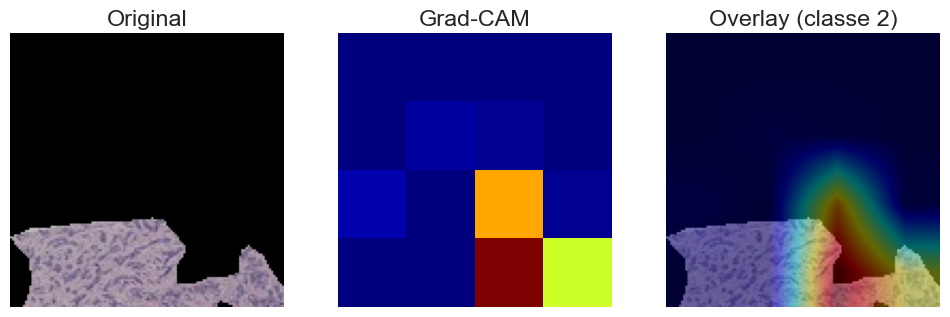

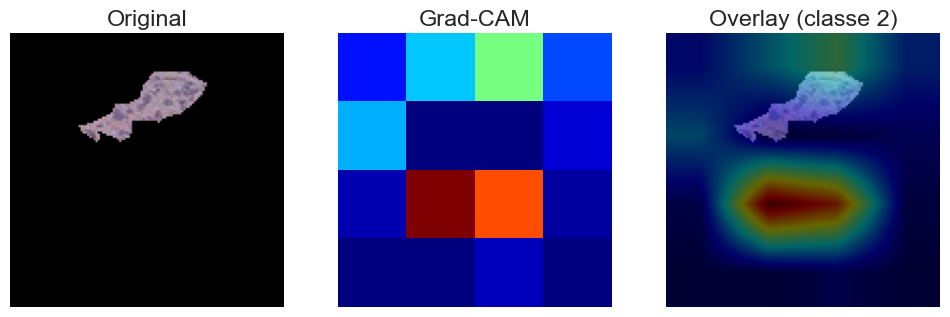

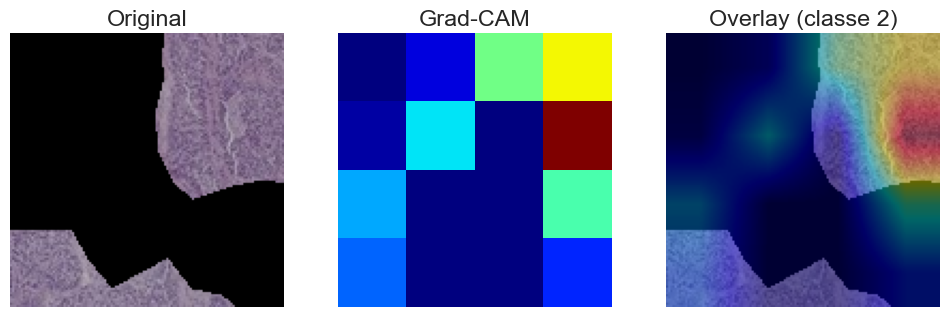

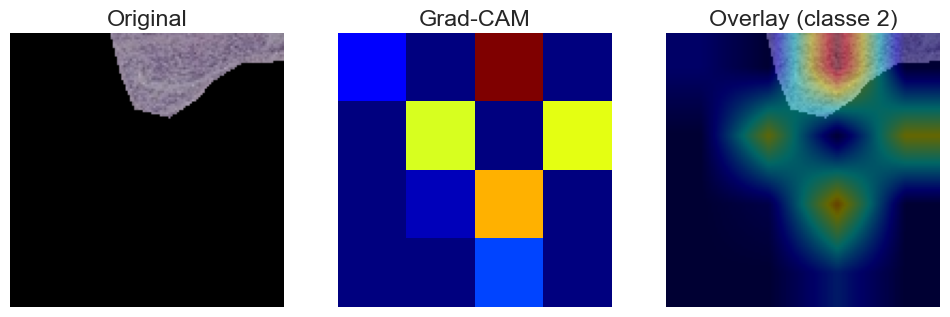

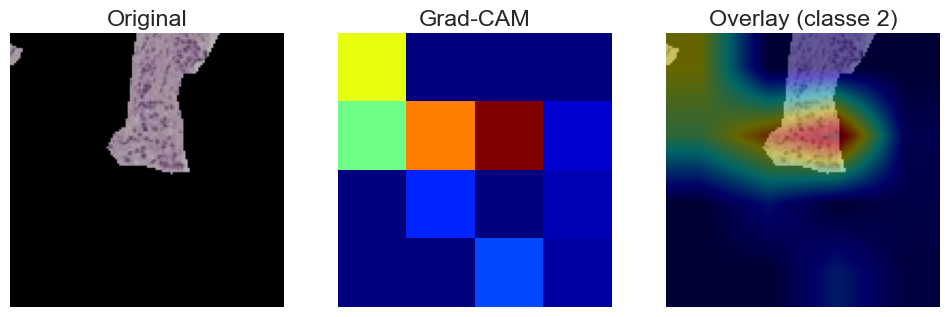

In [ ]:
####################################################################

###################### GradCam test ##########################

####################################################################

def generate_gradcam(model, img_tensor, target_layer, class_idx=None):
    """
    img_tensor: (C, H, W) already with same training transforms (normalize, etc.)
    class_idx: target class to explain (int). If None, uses predicted class.
    """
    activations = {}
    gradients = {}

    def forward_hook(module, inp, out):
        activations["value"] = out.detach()

    def backward_hook(module, grad_in, grad_out):
        # grad_out[0] = gradient w.r.t. layer output
        gradients["value"] = grad_out[0].detach()

    # register hooks
    h_f = target_layer.register_forward_hook(forward_hook)
    h_b = target_layer.register_full_backward_hook(backward_hook)

    model.zero_grad()

    # prepare input: (1, C, H, W)
    img = img_tensor.unsqueeze(0).to(device)

    # FORWARD
    scores = model(img)  # (1, num_classes)

    # choose target class
    if class_idx is None:
        class_idx = scores.argmax(dim=1).item()

    score = scores[0, class_idx]

    # BACKWARD
    score.backward()

    # get activation and gradient from target layer
    A = activations["value"]      # (1, C, H', W')
    dA = gradients["value"]       # (1, C, H', W')

    # weights: spatial average of gradients
    # shape: (1, C, 1, 1)
    weights = dA.mean(dim=(2, 3), keepdim=True)

    # linear combination of activation maps
    cam = (weights * A).sum(dim=1)  # (1, H', W')
    cam = nn_functional.relu(cam)   # ReLU

    cam = cam[0]                    # (H', W')
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)       # normalize to [0,1]

    cam = cam.cpu().numpy()

    # remove hooks
    h_f.remove()
    h_b.remove()

    return cam, class_idx

def overlay_cam_on_image(img_rgb, cam, alpha=0.4):
    """
    img_rgb: numpy (H, W, 3) in [0,255], uint8
    cam: numpy (H', W') in [0,1]
    """
    H, W, _ = img_rgb.shape

    # resize CAM to image size
    cam_resized = cv2.resize(cam, (W, H))

    # convert to 0-255
    cam_uint8 = np.uint8(255 * cam_resized)

    # apply colormap
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # blend heatmap + image
    overlay = (alpha * heatmap + (1 - alpha) * img_rgb).astype(np.uint8)
    return overlay


images = ["0000","0003","0068","0077","0101"]

for image in images:
    # 1. load original image
    img_pil = Image.open(f"C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/tile_test_images/img_{image}.png").convert("RGB")

    # 2. image for visualization (without normalize)
    img_vis = np.array(img_pil)  # (H,W,3) uint8

    # 3. image for model
    img_tensor = pass_transforms(img_pil)   # (C,H,W)

    # 4. target layer
    # Check backbone class name to decide which layer to grab
    backbone_type = type(model.backbone).__name__.lower()
    
    if "densenet" in backbone_type:
        # DenseNet uses .features, take last layer (usually norm5)
        target_layer = model.backbone.features[-1]
        
    elif "convnext" in backbone_type:
        # ConvNeXt uses .stages, take last block of last stage
        target_layer = model.backbone.stages[-1].blocks[-1]
        
    elif "efficientnet" in backbone_type:
        # EfficientNet (timm) usually uses .conv_head or .blocks[-1]
        target_layer = model.backbone.conv_head
        
    elif "resnet" in backbone_type:
        # ResNet uses .layer4
        target_layer = model.backbone.layer4[-1]
        
    else:
        raise AttributeError(f"Architecture {backbone_type} not mapped for GradCAM. Check model structure.")

    # 5. GradCAM
    cam, class_idx = generate_gradcam(model, img_tensor, target_layer)

    # 6. Overlay
    overlay = overlay_cam_on_image(img_vis, cam)

    # 7. Show results
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img_vis); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Grad-CAM"); plt.imshow(cam, cmap="jet"); plt.axis("off")
    plt.subplot(1,3,3); plt.title(f"Overlay (class {class_idx})"); plt.imshow(overlay); plt.axis("off")
    plt.show()


In [550]:
len(final_submission_df)

477

### Guiding trials - Trials with good performance on test
--- **Trial 11: convnext_tiny | K=79 | LRs: 1.0e-03/9.8e-05** ---<p/>
    **Optim: Lion - Normalization: batchnorm - Label Smoothing: 0.19477150725059084**<p/>
🔓 Últimos 79 tensores de parâmetros descongelados (Total: 184)<p/>
Porcentagem descongelada: 42.93478260869565%<p/>
Training 150 epochs...<p/>
Early stopping triggered after 112 epochs.<p/>
Best model restored from epoch 82 with val_f1 0.5892<p/>
[I 2025-12-11 16:27:36,193] Trial 11 finished with value: 0.589158134453373 and parameters: {'model_name': 'convnext_tiny', 'unfreeze_k': 79, 'lr_head': 0.000999918655230289, 'lr_finetune': 9.834794105387519e-05, 'label_smoothing': 0.19477150725059084, 'norm_method': 'batchnorm', 'optimizer': 'Lion'}. Best is trial 11 with value: 0.589158134453373.
<br>

--- **Trial 13: convnext_small | K=59 | LRs: 3.9e-05/2.0e-05**** ---<p/>
    **Optim: Lion - Normalization: layernorm - Label Smoothing: 0.053237268356204764**<p/>
🔓 Últimos 59 tensores de parâmetros descongelados (Total: 346)<p/>
Porcentagem descongelada: 17.052023121387283%<p/>
Best model restored from epoch 72 with val_f1 0.5171<p/>
[I 2025-12-10 07:22:21,758] Trial 13 finished with value: 0.5170649602545114 and parameters: {'model_name': 'convnext_small', 'unfreeze_k': 59, 'lr_head': 3.887249532496421e-05, 'lr_finetune': 2.0483455771295596e-05, 'label_smoothing': 0.053237268356204764, 'norm_method': 'layernorm', 'optimizer': 'Lion'}.


## Transfer v1 Submit

In [ ]:
# ==========================================
# 1. SETUP MAPPINGS & CONFIG
# ==========================================
# Invert your label_to_idx dictionary to get names back
idx_to_label = {
    0: "Luminal A",
    1: "Luminal B",
    2: "HER2(+)",
    3: "Triple negative",
}

# Path to your test images
TEST_IMG_FOLDER = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_preprocessed_images" 
# Path to your best saved model
MODEL_PATH = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/ConvNeXt_Run_01_warmup_model.pt" # Update this filename if needed


# ==========================================
# 3. PREPARE DATA & MODEL
# ==========================================
# Use the same transforms as validation (no augmentation, just resize/norm)
# Assuming 'val_transforms' or 'train_transforms' is defined in your notebook. 
# If not, copy your composition here.
test_dataset = TestDataset(TEST_IMG_FOLDER, transforms=train_transforms) # Applyin same transforms as in validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test Images found: {len(test_dataset)}")

# Initialize the model structure (Make sure TransferConvNeXt_v1 is defined in memory)
# If you switched to DenseNet, use MedicalTransferModel(model_name='densenet121', ...)
model = SimpleTransfer_v1(model_name="densenet121", num_classes=4).to(device)

# Load the weights
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print("Model loaded successfully.")

# ==========================================
# 4. RUN PREDICTION LOOP
# ==========================================
all_preds = []
all_names = []

print("Starting inference...")
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        
        # Forward pass
        logits = model(images)
        
        # Get predictions (class index with highest probability)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Decode indices to string labels
        pred_labels = [idx_to_label[p] for p in preds]
        
        all_preds.extend(pred_labels)
        all_names.extend(filenames)

# ==========================================
# 5. SAVE SUBMISSION
# ==========================================
submission_df = pd.DataFrame({
    "sample_index": all_names,
    "label": all_preds
})

# Save to CSV
submission_df.to_csv("C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/submissions/submission_transfer_v1.csv", index=False)

print("✅ Submission saved")
print(submission_df.head())

## Partial Transfer Submit

In [ ]:
# ==========================================
# 1. SETUP MAPPINGS & CONFIG
# ==========================================

idx_to_label = {
    0: "Luminal A",
    1: "Luminal B",
    2: "HER2(+)",
    3: "Triple negative",
}

# Path to your test images
TEST_IMG_FOLDER = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_preprocessed_images" 
# Path to your best saved model
MODEL_PATH = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Blur_NoNorm_AllTuned_BaseModel_Study_22_model.pt" # Update this filename if needed

# ==========================================
# 3. PREPARE DATA & MODEL
# ==========================================

test_dataset = TestDataset(TEST_IMG_FOLDER, transforms=pass_transforms) # Applying same transforms as in validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test Images found: {len(test_dataset)}")

model = SimpleTransfer_v1(model_name="convnext_tiny", norm_method="batchnorm", num_classes=4).to(device)

# Load the weights
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
print("Model loaded successfully.")

# ==========================================
# 4. RUN PREDICTION LOOP
# ==========================================
all_preds = []
all_names = []

print("Starting inference...")
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        
        # Forward pass
        logits = model(images)
        
        # Get predictions (class index with highest probability)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Decode indices to string labels
        pred_labels = [idx_to_label[p] for p in preds]
        
        all_preds.extend(pred_labels)
        all_names.extend(filenames)

# ==========================================
# 5. SAVE SUBMISSION
# ==========================================
submission_df = pd.DataFrame({
    "sample_index": all_names,
    "label": all_preds
})

# Save to CSV
submission_df.to_csv("C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/submissions/submission_Blur_NoNorm_AllTuned_BaseModel_22.csv", index=False)

print("✅ Submission saved")
print(submission_df.head())

Test Images found: 477
Model loaded successfully.
Starting inference...


100%|██████████| 8/8 [00:14<00:00,  1.84s/it]

✅ Submission saved
   sample_index      label
0  img_0000.png  Luminal A
1  img_0001.png  Luminal A
2  img_0002.png    HER2(+)
3  img_0003.png  Luminal B
4  img_0004.png  Luminal A


## Ensemble Single View

In [ ]:
gatekeeper_model = SimpleTransfer_v1(  
    model_name='efficientnet_b0', 
    num_classes=2, 
    pretrained=True,
    norm_method='groupnorm',
).to(device)

luminal_specialist_model = SimpleTransfer_v1(  
    model_name='convnext_tiny', 
    num_classes=2, 
    pretrained=True,
    norm_method='groupnorm',
).to(device)

aggressive_specialist_model = SimpleTransfer_v1(
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='groupnorm',
).to(device)

# ==========================================
# 1. SETUP MAPPINGS & CONFIG
# ==========================================
idx_to_label = {
    0: "Luminal A",
    1: "Luminal B",
    2: "HER2(+)",
    3: "Triple negative",
}

# Path to your test images
TEST_IMG_FOLDER = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/test_preprocessed_images" 
# Path to your best saved model
GATEKEEPER_PATH = "C:\Documents\Polimi\AN2DL\competition_2\Challenge-2\Approach1\models\optim_models\optuna_Gatekeeper_15_model.pt" 
SPECIALIST_LUM_PATH = "C:\Documents\Polimi\AN2DL\competition_2\Challenge-2\Approach1\models\optim_models\optuna_Luminal_Specialist_18_model.pt"
SPECIALIST_AGG_PATH = "C:\Documents\Polimi\AN2DL\competition_2\Challenge-2\Approach1\models\optim_models\optuna_Aggressive_Specialist_24_model.pt"

# ==========================================
# 2. DEFINE TEST DATASET
# ==========================================
class TestDataset(Dataset):
    def __init__(self, img_folder, transforms=None):
        self.img_folder = img_folder
        self.transforms = transforms
        # List all png images, sorted to ensure order
        self.image_names = sorted([f for f in os.listdir(img_folder) if (f.endswith('.png') and f.startswith('img_'))])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_folder, img_name)
        
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms:
            img = self.transforms(img)
            
        return img, img_name

# ==========================================
# 3. PREPARE DATA & MODEL
# ==========================================

test_dataset = TestDataset(TEST_IMG_FOLDER, transforms=pass_transforms) # Applyin same transforms as in validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Test Images found: {len(test_dataset)}")


# Load the weights
gatekeeper_model.load_state_dict(torch.load(GATEKEEPER_PATH))
luminal_specialist_model.load_state_dict(torch.load(SPECIALIST_LUM_PATH))
aggressive_specialist_model.load_state_dict(torch.load(SPECIALIST_AGG_PATH))


print("Sub-Models loaded successfully.")

full_model = HierarchicalSoftModel(gatekeeper_model, luminal_specialist_model, aggressive_specialist_model)
full_model.to(device)

all_preds = []
all_names = []

print("Intiating Soft Voting...")

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
        
      
        final_probs = full_model(images) 
       
        preds = torch.argmax(final_probs, dim=1).cpu().numpy()
        
        pred_labels = [idx_to_label[p] for p in preds]
        
        all_preds.extend(pred_labels)
        all_names.extend(filenames)

# Salvar CSV
submission_df = pd.DataFrame({"sample_index": all_names, "label": all_preds})
submission_df.to_csv("C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/submissions/submission_tuned_soft_voting2.csv", index=False)
print("✅ Submission saved")
print(submission_df.head())

Test Images found: 477
Sub-Models loaded successfully.
Intiating Soft Voting...


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

✅ Submission saved
   sample_index            label
0  img_0000.png          HER2(+)
1  img_0001.png          HER2(+)
2  img_0002.png  Triple negative
3  img_0003.png        Luminal A
4  img_0004.png        Luminal A


## Tile Ensemble Single View

In [ ]:
gatekeeper_model = SimpleTransfer_v1(  
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='layernorm',
).to(device)
#try: 24 dnet layernorm 68; 21 dnet layernorm 71; 19 dnet layernorm 72; 16 dnet layernorm 71; 15 same; 11 same
#best: 12 dnet layernorm 72

luminal_specialist_model = SimpleTransfer_v1(  
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)
# try: 24 dnet batchnorm 69; 17 same 67; 23 same 67; 19 same 67; 20 same 65
# best: 22 dnet batchnorm 69

aggressive_specialist_model = SimpleTransfer_v1(
    model_name='convnext_tiny', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)
# try: 24 ctiny batchnorm 70; 21 same 73; 16 csmall batchnorm 72; 15 same 68; 9 same 71; 14 ctiny batchnorm 71; 2 same 70; 3 ctiny layernorm 68 
# best 23 ctiny batchnorm 73

# ==========================================
# SETUP MAPPINGS & CONFIG
# ==========================================
# Invert your label_to_idx dictionary to get names back
idx_to_label = {
    0: "Luminal A",
    1: "Luminal B",
    2: "HER2(+)",
    3: "Triple negative",
}

# Path to your best saved model
GATEKEEPER_PATH =  "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Tile_Gatekeeper_21_model.pt"
SPECIALIST_LUM_PATH = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Tile_Luminal_Specialist_17_model.pt"
SPECIALIST_AGG_PATH = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Tile_Aggressive_Specialist_21_model.pt"

# ==========================================
# PREPARE DATA & MODEL
# ==========================================

test_dataset = TestDataset(TEST_TILE_FOLDER, transforms=pass_transforms) # Applyin same transforms as in validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

print(f"Test Images found: {len(test_dataset)}")

# Load the weights
gatekeeper_model.load_state_dict(torch.load(GATEKEEPER_PATH))
luminal_specialist_model.load_state_dict(torch.load(SPECIALIST_LUM_PATH))
aggressive_specialist_model.load_state_dict(torch.load(SPECIALIST_AGG_PATH))


print("Sub-Models loaded successfully.")

full_model = HierarchicalSoftModel(gatekeeper_model, luminal_specialist_model, aggressive_specialist_model)
full_model.to(device)

all_probs = []
all_tile_names = []

print("Intiating Soft Voting...")

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
       
        final_probs = full_model(images) 
        
        all_probs.append(final_probs.cpu().numpy())
        all_tile_names.extend(filenames)

all_probs_concat = np.concatenate(all_probs, axis=0)

# ==========================================
# PREPARAE DATAFRAME WITH PREDICTIONS
# ==========================================

tile_preds_df = pd.DataFrame(all_probs_concat, columns=["P_LumA", "P_LumB", "P_HER2", "P_TN"])
tile_preds_df["tile_index"] = all_tile_names

print("✅ Inferência dos tiles concluída.")
print(tile_preds_df.head())

final_submission_df = tile_vote(
    correspondance_test_df, 
    tile_preds_df, 
    idx_to_label, 
    top_k=10  
)

# Salvar
final_submission_df[["sample_index", "label"]].to_csv(
    "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/submissions/ensemble_tile_softvoting_submission_21_17_21.csv", 
    index=False
)

print("✅ Submissão final (agregada) salva!")
print(final_submission_df.head())


Test Images found: 17806
Sub-Models loaded successfully.
Intiating Soft Voting...


100%|██████████| 140/140 [01:40<00:00,  1.39it/s]


✅ Inferência dos tiles concluída.
     P_LumA    P_LumB    P_HER2      P_TN    tile_index
0  0.305390  0.023510  0.622505  0.048595  img_0000.png
1  0.153493  0.322217  0.475063  0.049227  img_0001.png
2  0.801848  0.194402  0.002078  0.001672  img_0002.png
3  0.376682  0.581728  0.038652  0.002939  img_0003.png
4  0.062869  0.595305  0.333197  0.008629  img_0004.png
Agregando 3616 tiles em pacientes únicos...


Voting: 100%|██████████| 477/477 [00:00<00:00, 826.18it/s] 

✅ Submissão final (agregada) salva!
   sample_index      label  confidence
0  img_0000.png  Luminal A    0.409353
1  img_0001.png  Luminal B    0.450275
2  img_0002.png  Luminal B    0.765808
3  img_0003.png  Luminal B    0.512140
4  img_0004.png  Luminal B    0.529091


In [ ]:
gatekeeper_model = SimpleTransfer_v1(  
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='layernorm',
).to(device)
#try: 24 dnet layernorm 68; 21 dnet layernorm 71; 19 dnet layernorm 72; 16 dnet layernorm 71; 15 same; 11 same
#best: 12 dnet layernorm 72

luminal_specialist_model = SimpleTransfer_v1(  
    model_name='densenet121', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)
# try: 24 dnet batchnorm 69; 17 same 67; 23 same 67; 19 same 67; 20 same 65
# best: 22 dnet batchnorm 69

aggressive_specialist_model = SimpleTransfer_v1(
    model_name='convnext_tiny', 
    num_classes=2, 
    pretrained=True,
    norm_method='batchnorm',
).to(device)
# try: 24 ctiny batchnorm 70; 21 same 73; 16 csmall batchnorm 72; 15 same 68; 9 same 71; 14 ctiny batchnorm 71; 2 same 70; 3 ctiny layernorm 68 
# best 23 ctiny batchnorm 73

# ==========================================
# SETUP MAPPINGS & CONFIG
# ==========================================
# Invert your label_to_idx dictionary to get names back
idx_to_label = {
    0: "Luminal A",
    1: "Luminal B",
    2: "HER2(+)",
    3: "Triple negative",
}

# Path to your best saved model
GATEKEEPER_PATH =  "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Tile_Gatekeeper_24_model.pt"
SPECIALIST_LUM_PATH = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Tile_Luminal_Specialist_24_model.pt"
SPECIALIST_AGG_PATH = "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/models/optim_models/optuna_Tile_Aggressive_Specialist_24_model.pt"

# ==========================================
# PREPARE DATA & MODEL
# ==========================================

test_dataset = TestDataset(TEST_TILE_FOLDER, transforms=pass_transforms) # Applyin same transforms as in validation
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

print(f"Test Images found: {len(test_dataset)}")

# Load the weights
gatekeeper_model.load_state_dict(torch.load(GATEKEEPER_PATH))
luminal_specialist_model.load_state_dict(torch.load(SPECIALIST_LUM_PATH))
aggressive_specialist_model.load_state_dict(torch.load(SPECIALIST_AGG_PATH))


print("Sub-Models loaded successfully.")

full_model = HierarchicalSoftModel(gatekeeper_model, luminal_specialist_model, aggressive_specialist_model)
full_model.to(device)

all_probs = []
all_tile_names = []

print("Intiating Soft Voting...")

with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(device)
       
        final_probs = full_model(images) 
        
        all_probs.append(final_probs.cpu().numpy())
        all_tile_names.extend(filenames)

all_probs_concat = np.concatenate(all_probs, axis=0)

# ==========================================
# PREPARAE DATAFRAME WITH PREDICTIONS
# ==========================================

tile_preds_df = pd.DataFrame(all_probs_concat, columns=["P_LumA", "P_LumB", "P_HER2", "P_TN"])
tile_preds_df["tile_index"] = all_tile_names

print("✅ Inferência dos tiles concluída.")
print(tile_preds_df.head())

final_submission_df = tile_vote(
    correspondance_test_df, 
    tile_preds_df, 
    idx_to_label, 
    top_k=7  
)

# Salvar
final_submission_df[["sample_index", "label"]].to_csv(
    "C:/Documents/Polimi/AN2DL/competition_2/Challenge-2/Approach1/submissions/ensemble_tile_softvoting_submission_24_24_24.csv", 
    index=False
)

print("✅ Submissão final (agregada) salva!")
print(final_submission_df.head())


Test Images found: 17806
Sub-Models loaded successfully.
Intiating Soft Voting...


100%|██████████| 140/140 [01:20<00:00,  1.74it/s]


✅ Inferência dos tiles concluída.
     P_LumA    P_LumB    P_HER2      P_TN    tile_index
0  0.146952  0.132593  0.636704  0.083752  img_0000.png
1  0.252497  0.325339  0.334978  0.087186  img_0001.png
2  0.427327  0.267126  0.049555  0.255992  img_0002.png
3  0.512951  0.432568  0.050291  0.004190  img_0003.png
4  0.407227  0.550948  0.037329  0.004496  img_0004.png
Agregando 3616 tiles em pacientes únicos...


Voting: 100%|██████████| 477/477 [00:00<00:00, 1018.70it/s]

✅ Submissão final (agregada) salva!
   sample_index      label  confidence
0  img_0000.png  Luminal A    0.334932
1  img_0001.png  Luminal A    0.423713
2  img_0002.png  Luminal B    0.698051
3  img_0003.png  Luminal B    0.434816
4  img_0004.png  Luminal B    0.509600
